# Importing Libraries

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import numpy as np
import calmap
from random import randrange
from pandas import Series
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from neuralprophet import NeuralProphet
import warnings
import pmdarima as pm
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from time import time
import seaborn as sns
import statsmodels.api as sm
from sklearn.cluster import DBSCAN
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.layers import LSTM
from keras import callbacks
from keras import optimizers
import math


from spectralcluster import SpectralClusterer

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from functools import reduce


 # Phase 2: Provisioning

## Importing Dataset

Using glob we scan the directory of a local folder, getting all files in the process. Using regex we filter out any file type that isn't .csv. We name all files apropriately, read the file and cast them to the appropriate variables. 

In [3]:
## Find all .csv in specified directory
# directory path
dir = r"project_datasets\\"
# glob finds and puts all the file paths into a list
all_files = glob.glob(dir + "*.csv")

In [4]:
## Using RegEx take the name and format it (Format => "df_A")
pattern = re.compile(r'(?<=\\)(.*?)(?=\.)')
def get_file_names(x):
    files = x
    saved = []
    for file in files:
        for name in re.findall(pattern, file):
            name = name.replace("data","df")
            ## .lower() could be removed it's just that our existing document uses lower case (df_a, df_d)
            name = name.lower()
            saved.append(name)
    return saved

In [5]:
## Read all the file name and paths and assign them to variable
dataframe_names = get_file_names(all_files)
for index, item in enumerate(dataframe_names):
    globals()['%s' % item] = pd.read_csv(all_files[index])

In [6]:
print("Available Dataframes:")
print(dataframe_names)

Available Dataframes:
['df_a', 'df_aa', 'df_ab', 'df_ac', 'df_ad', 'df_b', 'df_c', 'df_d', 'df_e', 'df_f', 'df_g', 'df_h', 'df_i', 'df_j', 'df_k', 'df_m', 'df_n', 'df_o', 'df_p', 'df_q', 'df_r', 'df_s', 'df_t', 'df_u', 'df_v', 'df_w', 'df_x', 'df_y', 'df_z']


## Converting our dataframes to Time Series

We convert the EventDt column in each avaiable dataframe to DateTime format, after which we set it as an index and then we resmaple the data on a 5 minute frequency.
Addtionally we add a daily, weekly and monthly variant of each dataframe that assist us in the data analysis at a later point in this notebook.

In [7]:
## Convert all column types to date_time and transform dataframes to time-series
for item in dataframe_names:
    globals()['%s' % item]["EventDt"] = pd.to_datetime(globals()['%s' % item]["EventDt"])
    globals()['%s' % item] = globals()['%s' % item].set_index(globals()['%s' % item]["EventDt"])
    globals()['%s' % item] = globals()['%s' % item].resample(rule="5T").mean()

In [8]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315647 entries, 2018-11-18 16:10:00 to 2021-11-18 16:00:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Temp    258390 non-null  float64
dtypes: float64(1)
memory usage: 4.8 MB


In [9]:
## Added additional dataframes with resampled data in different formats (daily, weekly, monthly)
for item in dataframe_names:
    globals()['%s_daily' % item] = globals()['%s' % item].resample(rule="D").mean()
    globals()['%s_weekly' % item] = globals()['%s' % item].resample(rule="W").mean()
    globals()['%s_monthly' % item] = globals()['%s' % item].resample(rule="M").mean()

## Visualisation 

Before we went any farther with our research, we wanted to see what each gadget was doing and if it was being read correctly.

Text(0.5, 1.0, 'Linear graph')

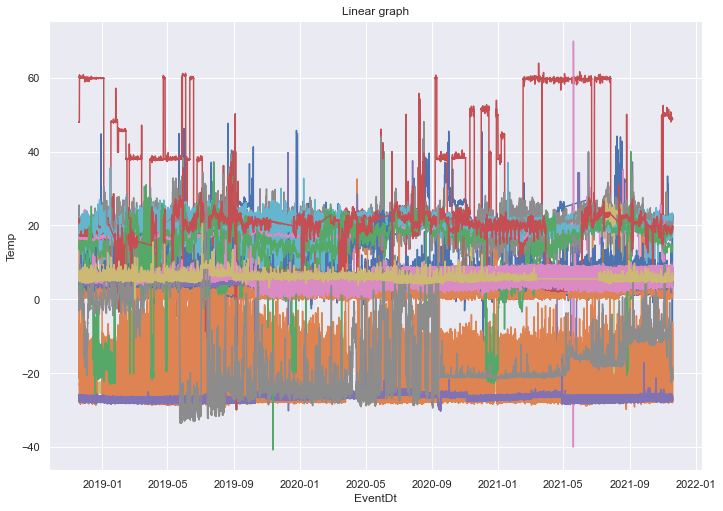

In [16]:
#pic size
sns.set(rc={'figure.figsize':(11.7,8.27)})
#fix the date and maybe zoom in or smt
data = [df_a,df_aa,df_ab,df_ac,df_ad,df_b,df_c,df_d,df_e,df_f,df_g,df_h,df_i,df_j,
        df_k,df_m,df_n,df_o,df_p,df_q,df_r,df_s,df_t,df_u,df_v,df_w,df_x,df_y,df_z]

fig, ax = plt.subplots()

for dataset in data:
    sns.lineplot(x='EventDt', y='Temp', data=dataset, ax=ax) #first dataset

plt.title("Linear graph")

As can be observed, the representation of each sensor is a jumble, making it difficult to understand what is going on within. To approach the analysis through this research, we will first compile average temperatures for each device to evaluate where they stand from freezing to warming.

## Average Temperature Dictionary

To cut-down on load times, instead of plotting each dataframe values directly, we create a dictionary with the names and average temperature for each of our devices. Said dictionary is later plotted using SeaBorn barplot.

In [10]:
average_temps = []
for item in dataframe_names:
#     mean_temp = globals()['%s' % item]["Temp"].mean()
    mean_temp = globals()['%s' % item]["Temp"].quantile(.35)
    average_temps.append(mean_temp)
    
mean_temp_dev_dictionary = {"Device":dataframe_names,"Mean Temperature":average_temps}
mean_temp_dev = pd.DataFrame.from_dict(mean_temp_dev_dictionary)
mean_temp_dev.T

0      1      2      3      4     5      6      7   \
Device             df_a  df_aa  df_ab  df_ac  df_ad  df_b   df_c   df_d   
Mean Temperature  17.33  -21.0  18.83  21.87  19.41  5.55  14.15  16.84   

                     8      9   ...     19    20    21    22     23    24  \
Device             df_e   df_f  ...   df_q  df_r  df_s  df_t   df_u  df_v   
Mean Temperature -24.13  21.75  ...  18.89  4.53  0.96  13.0  19.53  4.14   

                    25    26    27    28  
Device            df_w  df_x  df_y  df_z  
Mean Temperature  6.36  5.19 -21.1  5.54  

[2 rows x 29 columns]

We opted to approach it through visuals from the coldest to the warmest temperature per device to see where each of the standing and categorize it after the average temperature conversion.

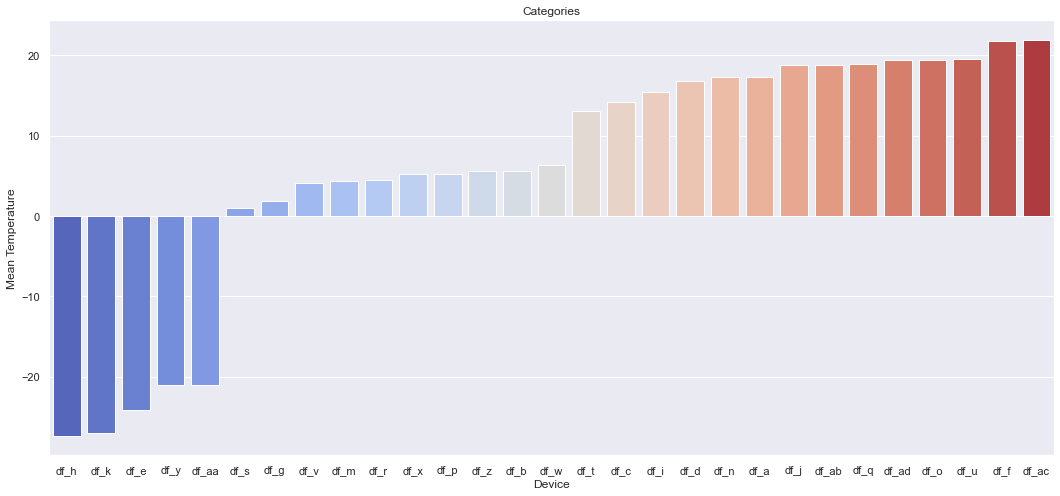

In [11]:
#sns.set_theme(style="whitegrid")
#sns.set_palette(sns.color_pallete("icefire"),as_cmap=True)
sns.set(rc={'figure.figsize':(18,8)})
sns.barplot(x="Device", 
            y="Mean Temperature", 
            data=mean_temp_dev,
            order=mean_temp_dev.sort_values('Mean Temperature').Device,
            palette = "coolwarm").set(title='Categories')

plt.show()

After plotting the dictionary we can easily see the average temperature for each dataframe and compare them to one another. This will help us with categorizing and labeling our dataframes.

## Categorizing Dataframes

After careful consideration and discussion we decided to seperate our dataframes into three distinct categories: Freezer, Fridge, Pantry

In [12]:
#barchart per category
#check the order
mean_temp_dev.sort_values(by='Mean Temperature',ascending=True).T

11     14     8     27     1     21    10    24    15  \
Device             df_h   df_k   df_e  df_y  df_aa  df_s  df_g  df_v  df_m   
Mean Temperature -27.33 -26.97 -24.13 -21.1  -21.0  0.96  1.91  4.14  4.37   

                    20  ...     16     0      13     2      19     4      17  \
Device            df_r  ...   df_n   df_a   df_j  df_ab   df_q  df_ad   df_o   
Mean Temperature  4.53  ...  17.24  17.33  18.83  18.83  18.89  19.41  19.43   

                     23     9      3   
Device             df_u   df_f  df_ac  
Mean Temperature  19.53  21.75  21.87  

[2 rows x 29 columns]

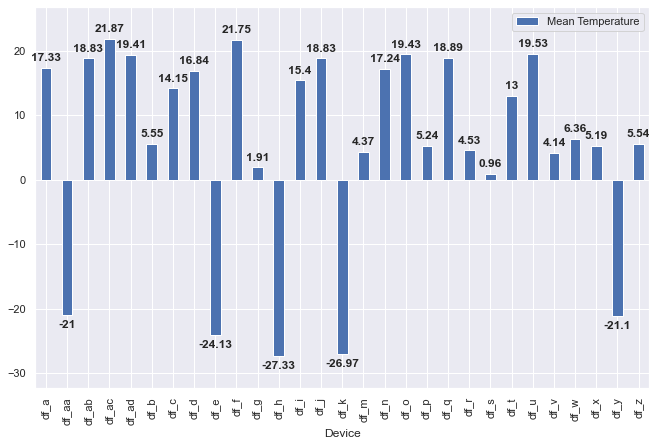

In [13]:
ax=mean_temp_dev.plot.bar(x='Device',
                   y='Mean Temperature',
                   figsize=(11,7),
                   )
#label for first visual
ax.bar_label(ax.containers[0], label_type='edge', fontweight='bold',padding=5)
ax.margins(y=0.1)

In [14]:
#categories
categories = []
customer_types = [
"",
"Food counter",
"",
"Medical facility",
"",
"Pharmacy",
"",
"Food production",
"Food production",
"Food counter",
"Food transport",
"Food production",
"",
"",
"Lab",
"Medical facility",
"",
"",
"Medical facility",
"Food production",
"Food counter",
"Food production",
"",
"",
"Medical facility",
"Pharmacy",
"Pharmacy",
"Lab",
"Pharmacy",
]

for value in mean_temp_dev['Mean Temperature']:
    if value < 0: 
        categories.append('Freezer')
    elif 0 <= value <= 8: 
        categories.append('Refrigerator')
    elif 14 <= value < 22:
        categories.append('Mapping')
    else: 
        categories.append('Unknown')

mean_temp_dev['Categories']  = categories
mean_temp_dev["Customer type"] = customer_types
mean_temp_dev.T

0             1        2                 3        4   \
Device               df_a         df_aa    df_ab             df_ac    df_ad   
Mean Temperature    17.33         -21.0    18.83             21.87    19.41   
Categories        Mapping       Freezer  Mapping           Mapping  Mapping   
Customer type              Food counter           Medical facility            

                            5        6                7                8   \
Device                    df_b     df_c             df_d             df_e   
Mean Temperature          5.55    14.15            16.84           -24.13   
Categories        Refrigerator  Mapping          Mapping          Freezer   
Customer type         Pharmacy           Food production  Food production   

                            9   ...               19            20  \
Device                    df_f  ...             df_q          df_r   
Mean Temperature         21.75  ...            18.89          4.53   
Categories             Mapping  ...          Mapping  Refrigerator   
Customer type     Food counter  ...  Food production  Food counter   

                               21       22       23                24  \
Device                       df_s     df_t     df_u              df_v   
Mean Temperature             0.96     13.0    19.53              4.14   
Categories           Refrigerator  Unknown  Mapping      Refrigerator   
Customer type     Food production                    Medical facility   

                            25            26       27            28  
Device                    df_w          df_x     df_y          df_z  
Mean Temperature          6.36          5.19    -21.1          5.54  
Categories        Refrigerator  Refrigerator  Freezer  Refrigerator  
Customer type         Pharmacy      Pharmacy      Lab      Pharmacy  

[4 rows x 29 columns]

In [351]:
#warning message
warnings.filterwarnings("ignore")

mean_temp_dev['Categories'] = mean_temp_dev['Categories'].apply(lambda x: x.strip())

# Modify Categories based on Customer Type
for x in range(len(customer_types)):
    if mean_temp_dev['Categories'][x] == "Freezer":
        ## Code for Freezer
        pass
    elif mean_temp_dev['Categories'][x] == "Refrigerator":
        ## Code for fridge
        pass
    elif mean_temp_dev['Categories'][x] == "Mapping":
        ## Code for Mapping
        if mean_temp_dev['Customer type'][x] == "Medical facility":
            mean_temp_dev['Categories'][x] = "Incubator"
        elif mean_temp_dev['Customer type'][x] == "Food production":
            if mean_temp_dev['Mean Temperature'][x] > 17:
                mean_temp_dev['Categories'][x] = "Production area"
            else:
                mean_temp_dev['Categories'][x] = "Storage"
mean_temp_dev

Device  Mean Temperature       Categories     Customer type
0    df_a             17.33          Mapping                  
1   df_aa            -21.00          Freezer      Food counter
2   df_ab             18.83          Mapping                  
3   df_ac             21.87        Incubator  Medical facility
4   df_ad             19.41          Mapping                  
5    df_b              5.55     Refrigerator          Pharmacy
6    df_c             14.15          Mapping                  
7    df_d             16.84          Storage   Food production
8    df_e            -24.13          Freezer   Food production
9    df_f             21.75          Mapping      Food counter
10   df_g              1.91     Refrigerator    Food transport
11   df_h            -27.33          Freezer   Food production
12   df_i             15.40          Mapping                  
13   df_j             18.83          Mapping                  
14   df_k            -26.97          Freezer               Lab
15   df_m              4.37     Refrigerator  Medical facility
16   df_n             17.24          Mapping                  
17   df_o             19.43          Mapping                  
18   df_p              5.24     Refrigerator  Medical facility
19   df_q             18.89  Production area   Food production
20   df_r              4.53     Refrigerator      Food counter
21   df_s              0.96     Refrigerator   Food production
22   df_t             13.00          Unknown                  
23   df_u             19.53          Mapping                  
24   df_v              4.14     Refrigerator  Medical facility
25   df_w              6.36     Refrigerator          Pharmacy
26   df_x              5.19     Refrigerator          Pharmacy
27   df_y            -21.10          Freezer               Lab
28   df_z              5.54     Refrigerator          Pharmacy

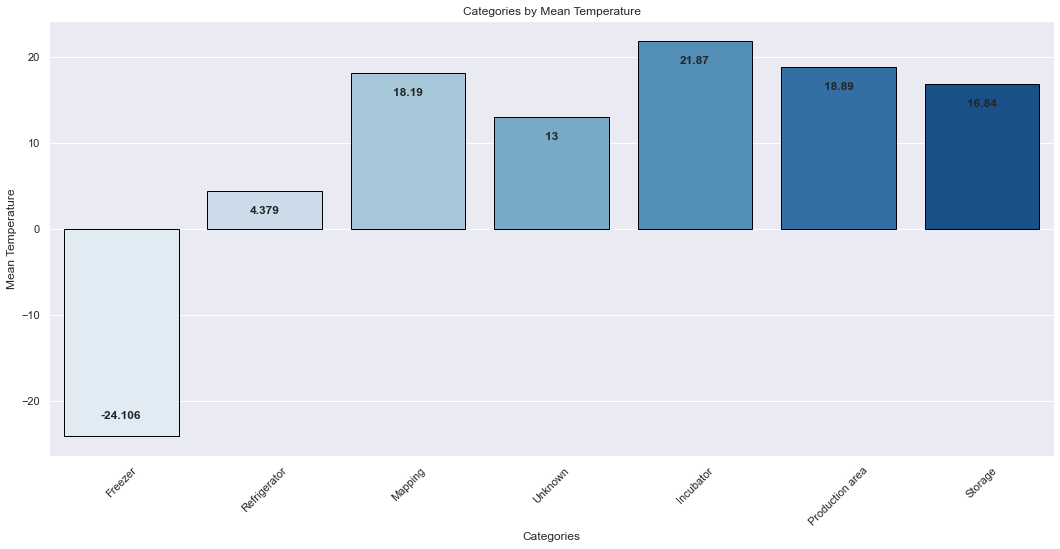

In [287]:
#barchart per group
plot = sns.barplot(data=mean_temp_dev,
                x="Categories",
                y="Mean Temperature",
                palette = "Blues",
                ci=None,
                edgecolor="black",
                order=["Freezer", "Refrigerator","Mapping",'Unknown','Incubator',"Production area","Storage"])

plt.bar_label(plot.containers[0], label_type='edge',padding=-25, fontweight='bold')

plt.title('Categories by Mean Temperature')
plt.xticks(rotation=45)
plt.show()

As can be seen, each gadget was assigned to one of three groups:
- ``Freezer``: devices with temperature lower than 0.
- ``Refrigerator``: devices with temperature higher or equal than 0, but lower or equal than 8.
- ``Mapping``: devices with temperature higher or equal than 14, but lower than 22.
- ``Unknown``: devices with temperature outside the temperature range and we do not know for what it's being use.
- ``Incubator``: devices with the mapping temperature but use in the medical facility.
- ``Production Area``: devices with temperature higher than 17, but lower than 22 and use in food production.
- ``Storage``: devices with temperature higher or equal than 14, but lower than 17 and use in food production.

Because the data does not contain any labeling, such categorization is an obvious technique taken by group members through the usage of external resources.

Following the categorization of the devices, we want to observe each device's pattern through a line plot, which will allow us to approach any potential anomalies and subsequently approach the selection of view devices to make the research more comfortable.

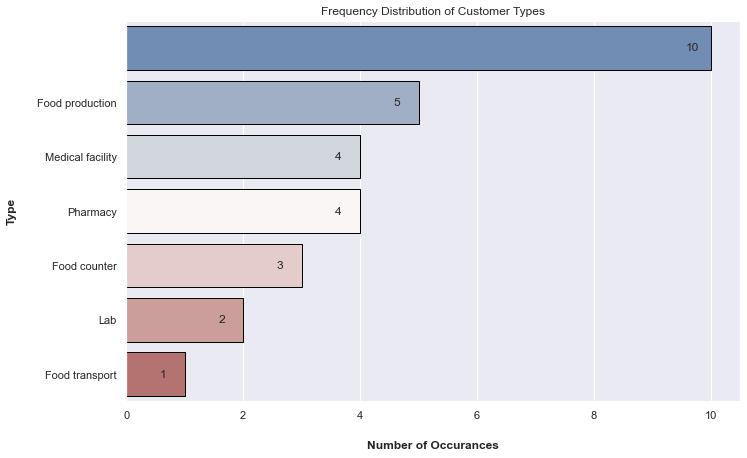

In [42]:
#barchart per customer type
#size
fig=plt.figure(figsize=(11,7))

#categorical distribution 
distribution = mean_temp_dev['Customer type'].value_counts()

#visual
plot = sns.barplot(distribution.values,
                   distribution.index,
                   palette = "vlag",
                   edgecolor="black")

plt.bar_label(plot.containers[0], label_type='edge',padding=-25)

#additionals
plt.title('Frequency Distribution of Customer Types')
plt.ylabel('Type',fontweight='bold',labelpad=20)
plt.xlabel('Number of Occurances',fontweight='bold',labelpad=20)
plt.show()

# Analysis of Elimination

Here we plot every dataframe divided based on category from which we will pick the most apropriate dataset to train our model on. In order for dataframe to be deemed apropriate for further analysis it needs to fufill the following conditions:
- Data Consistency
- None or very little missing values
- Upper and lower alarm threshold (Optional)

## Elimination of the First Category (Line Plots)

Elimination will be aided by a series of generic graphics, such as line plots to assess consistency, followed by box plots to identify missing values (outliers), and finally a final selection of a device per group.

### Freezer Category

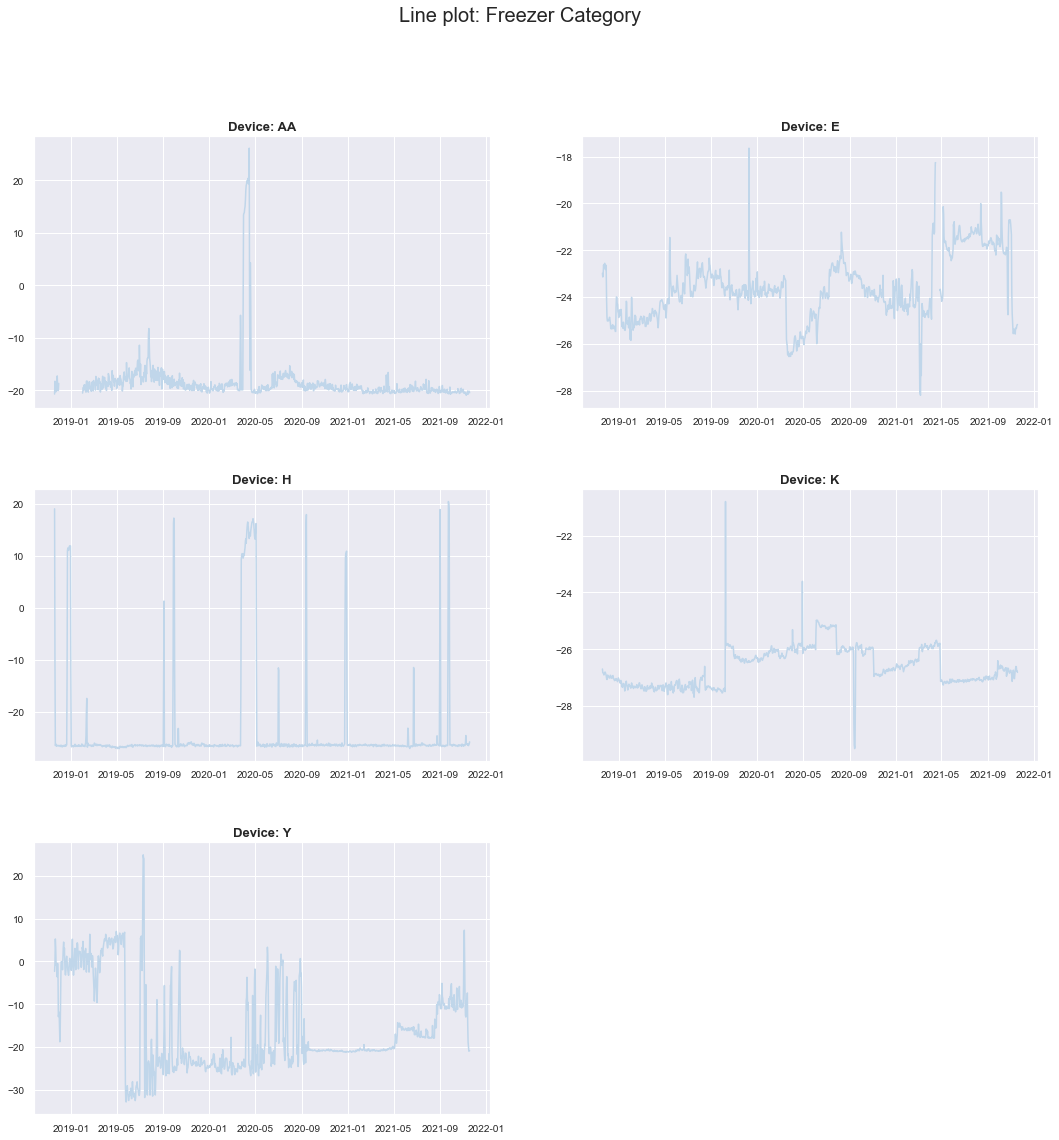

In [117]:
## AA, E, H, K, Y
# Height Margin
# plt.subplots_adjust(hspace=0.5)
fig, axes = plt.subplots(3,2, figsize=(18,18),constrained_layout=True)
fig.subplots_adjust(hspace=.3)
fig.suptitle('Line plot: Freezer Category',fontsize=20)

datalist = ["df_aa_daily","df_e_daily","df_h_daily","df_k_daily","df_y_daily",]
titles = ['Device: AA','Device: E','Device: H','Device: K','Device: Y',]
i = -1
j = 0
for idx, (dataset,title) in enumerate(zip(datalist,titles)):
    ## Change Modulo to from 2 to 3 to make a 3-column plot
    if idx % 2 == 0:
        i = i + 1
        j = 0
    else: j = j + 1
    axes[i,j].plot(globals()['%s' % dataset]["Temp"],color='#C0D6EA')
    axes[i,j].set_title(title,fontweight='bold',fontsize=13)

#fig.suptitle('Fridge Category')

#remove useless axes
fig.delaxes(axes[2,1])
plt.draw()

As can be seen, there are 5 devices in the freezer category, all of which detect a small number of anomalies and appear to be consistent in their patterns; however, with so many devices, it will be difficult to approach an analysis for all of them; therefore, to limit our research, we will cut out E and Y devices due to their unprogized prattens that could complicate the modeling, and we will leave them out.

### Refrigerator Category

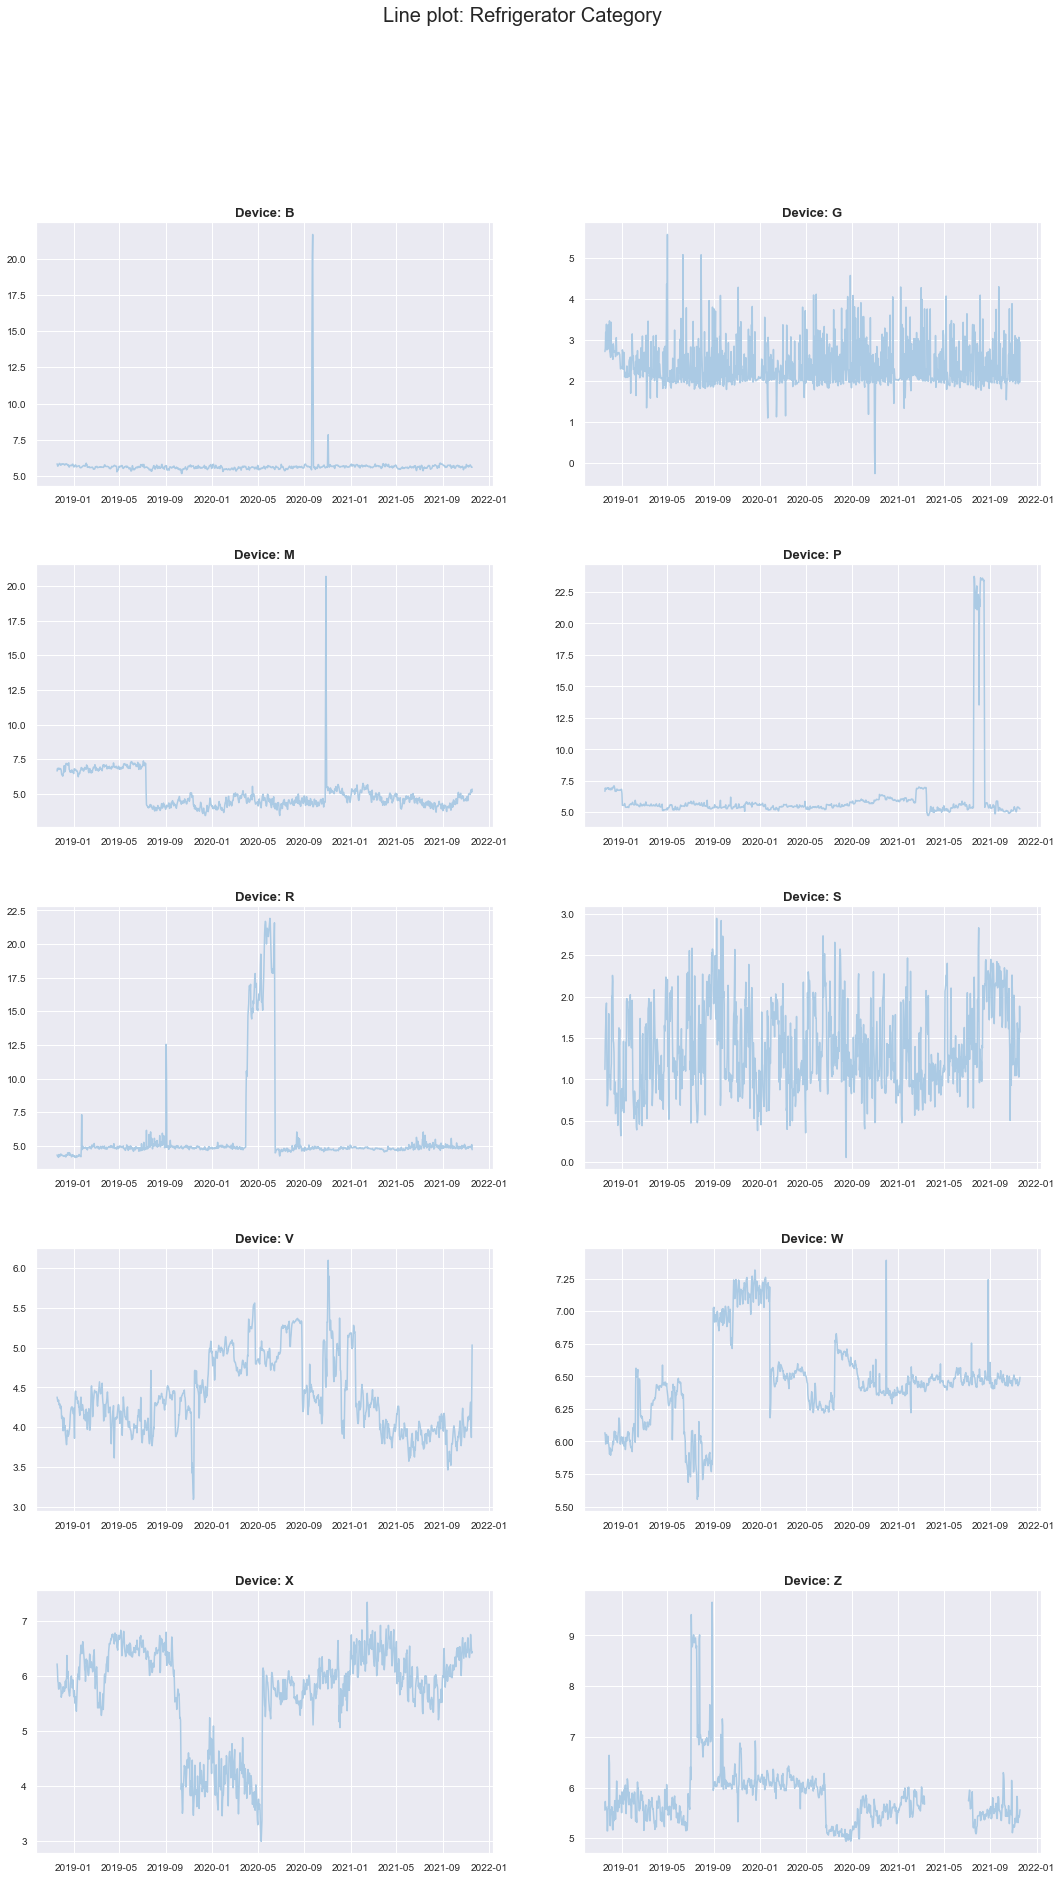

In [116]:
## B, G, M, P, R, S, V, W, X, Z
# Height Margin
# plt.subplots_adjust(hspace=0.5)
fig, axes = plt.subplots(5,2, figsize=(18,30),constrained_layout=True)
fig.subplots_adjust(hspace=.3)
fig.suptitle('Line plot: Refrigerator Category',fontsize=20)

datalist = ["df_b_daily","df_g_daily","df_m_daily","df_p_daily","df_r_daily","df_s_daily","df_v_daily","df_w_daily","df_x_daily","df_z_daily"]
titles = ['Device: B','Device: G','Device: M','Device: P','Device: R','Device: S','Device: V','Device: W','Device: X','Device: Z']

i = -1
j = 0
for idx, (dataset,title) in enumerate(zip(datalist,titles)):
    ## Change Modulo to from 2 to 3 to make a 3-column plot
    if idx % 2 == 0:
        i = i + 1
        j = 0
    else: j = j + 1
    axes[i,j].plot(globals()['%s' % dataset]["Temp"],color='#abcae4')
    axes[i,j].set_title(title,fontweight='bold',fontsize=13)
plt.show()

In comparison to the freezer, the fridge approached more devices on its scale and thus more possible dor analysis, but it also stayed above due to a complication of the amount provided, which could slow down the research and modeling. For future steps, we would like to stick with device B, S, and G because of their lack of anomalies and pattern consistency.

### Mapping Category

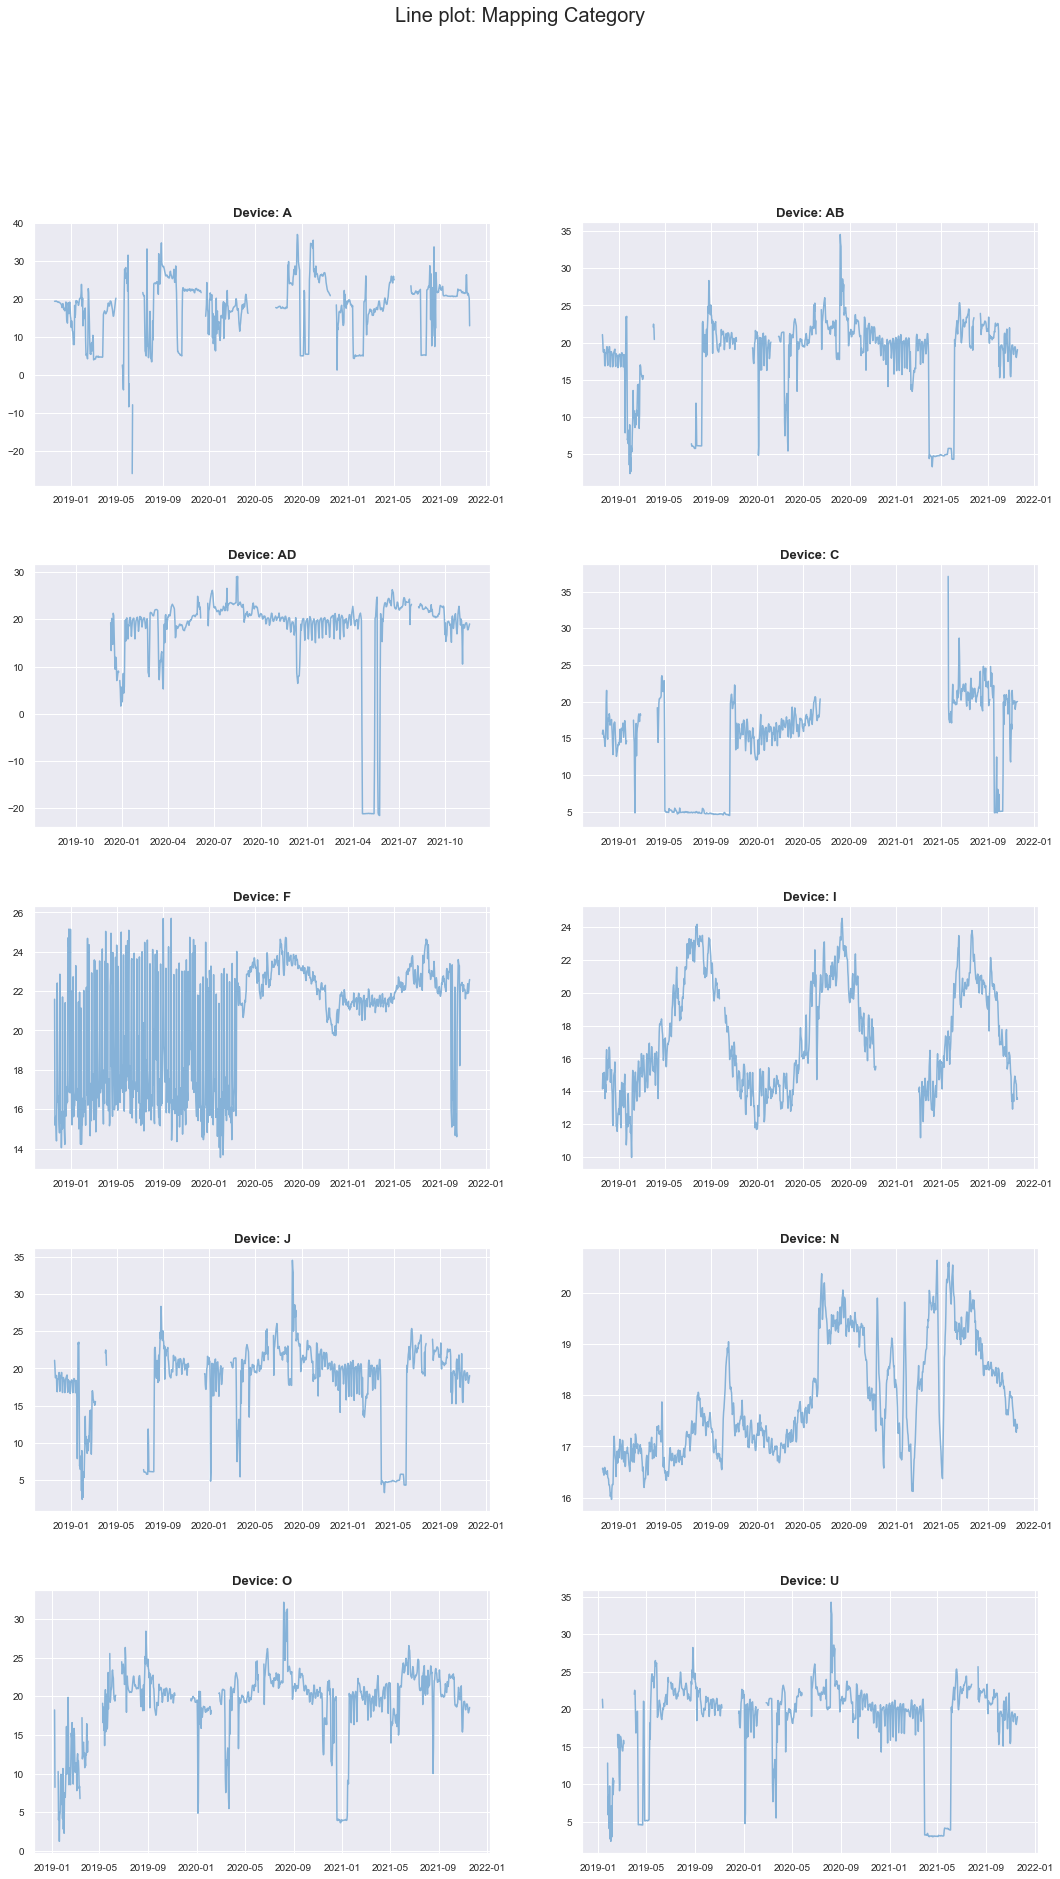

In [114]:
## A, AB, AD, C, F, I, J, N, O, U
#image
fig, axes = plt.subplots(5,2, figsize=(18,30),constrained_layout=True)
fig.subplots_adjust(hspace=.3)
fig.suptitle('Line plot: Mapping Category',fontsize=20)

datalist = ["df_a_daily","df_ab_daily","df_ad_daily","df_c_daily","df_f_daily","df_i_daily","df_j_daily","df_n_daily","df_o_daily","df_u_daily",]
titles = ['Device: A','Device: AB','Device: AD','Device: C','Device: F','Device: I','Device: J','Device: N','Device: O','Device: U',]
i = -1
j = 0
for idx, (dataset,title) in enumerate(zip(datalist,titles)):
    ## Change Modulo to from 2 to 3 to make a 3-column plot
    if idx % 2 == 0:
        i = i + 1
        j = 0
    else: j = j + 1
    axes[i,j].plot(globals()['%s' % dataset]["Temp"],color='#86b2d8')
    axes[i,j].set_title(title,fontweight='bold',fontsize=13)

plt.show()

When it came to the pantry, it can be seen that the majority of the devices ended up in this group, which could be due to the scale range that we provided, but within a follow-up for the freezer and fridge, this part allowed us to see the pattern and provide additional limitations so that we could continue with our analysis phase.

### Rest of the categories: Incubator, Production Area and Storage 

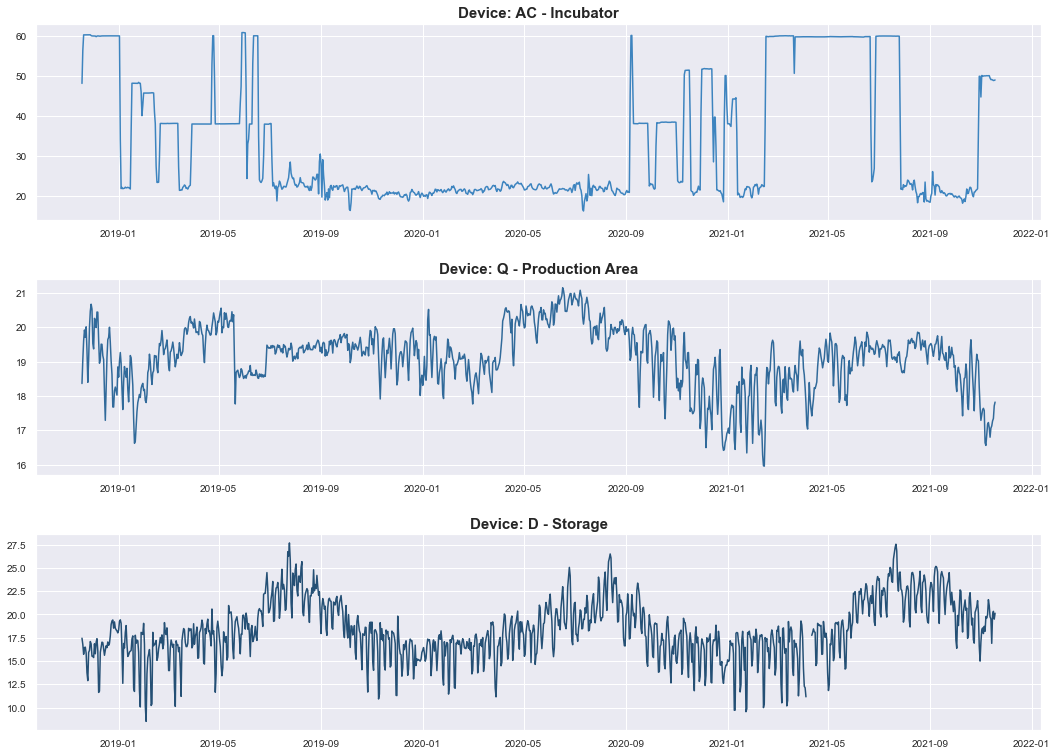

In [118]:

fig, axes = plt.subplots(3,1, figsize=(18,13))
fig.subplots_adjust(hspace=.3)
axes[0].plot(df_ac_daily["Temp"],color='#3d84bf')
axes[1].plot(df_q_daily["Temp"],color='#316a9a')
axes[2].plot(df_d_daily["Temp"],color='#255075')

axes[0].set_title('Device: AC - Incubator', fontsize=15,fontweight='bold')
axes[1].set_title('Device: Q - Production Area', fontsize=15,fontweight='bold')
axes[2].set_title('Device: D - Storage', fontsize=15,fontweight='bold')

plt.show()

## Elimination of the Second Category (Box Plots)

After manually selecting three devices from each category, we're ready to dig further into them, moving on to a second categorical elimination in the form of box plots, where we can see their outliers and eliminate the devices with the most of them.

### Freezers

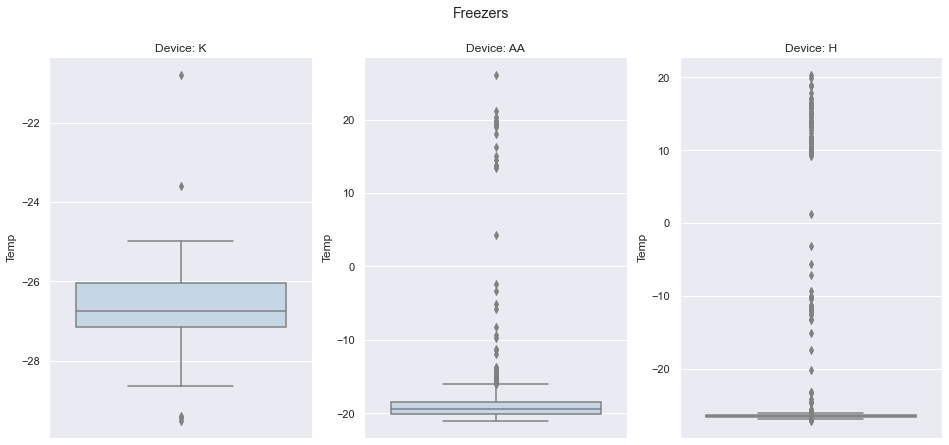

In [47]:
fig, axes = plt.subplots(1,3, figsize=(16,7))
fig.suptitle('Freezers')
sns.boxplot(ax=axes[0],y="Temp",data=df_k_daily,color='#C0D6EA')
sns.boxplot(ax=axes[1],y="Temp",data=df_aa_daily,color='#C0D6EA')
sns.boxplot(ax=axes[2],y="Temp",data=df_h_daily,color='#C0D6EA')
axes[0].set_title('Device: K')
axes[1].set_title('Device: AA')
axes[2].set_title('Device: H')
plt.show()

Based on the results, we will choose **device K** since it has less outliers than devices AA and H, which can be easily spotted within a large number of them, slowing down our research and harming further modeling. As a consequence, we will continue to use device K for future study.

### Refrigerators

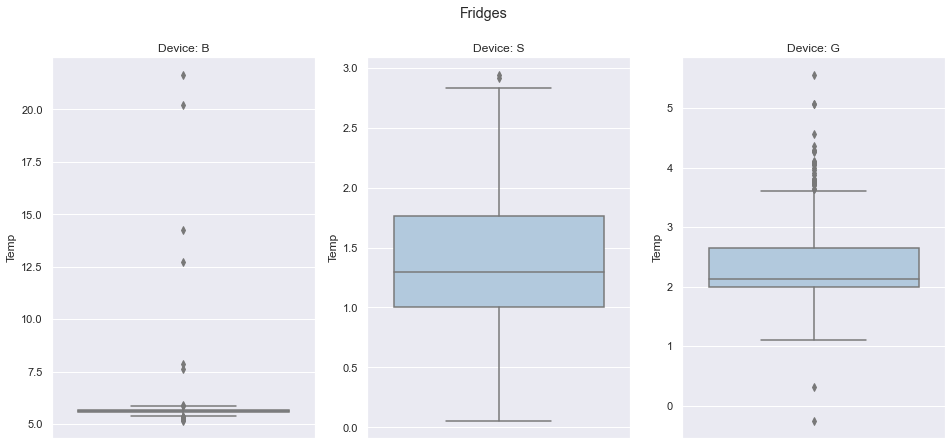

In [48]:
fig, axes = plt.subplots(1,3, figsize=(16,7))
fig.suptitle('Fridges')
sns.boxplot(ax=axes[0],y="Temp",data=df_b_daily,color='#abcae4')
sns.boxplot(ax=axes[1],y="Temp",data=df_s_daily,color='#abcae4')
sns.boxplot(ax=axes[2],y="Temp",data=df_g_daily,color='#abcae4')
axes[0].set_title('Device: B')
axes[1].set_title('Device: S')
axes[2].set_title('Device: G')
plt.show()

In the case of the refrigerator, it is clear that **device B** will be eliminated due to its outliers, and that device G will be eliminated due to the outliers accumulating in the scale from 5 to 4 degrees. As a result, we will stick with device S, even though it contributed to a few of the outliers, because it is more useful for further research and modeling than the other two.

### Mappings

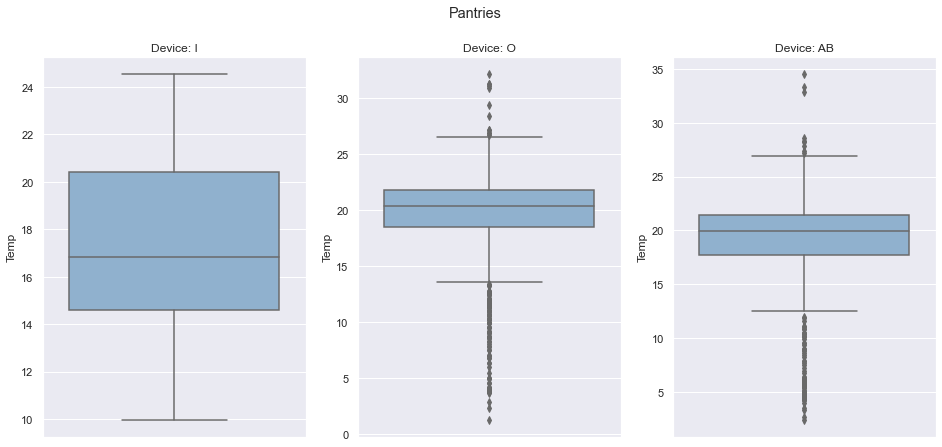

In [49]:
fig, axes = plt.subplots(1,3, figsize=(16,7))
fig.suptitle('Pantries')
sns.boxplot(ax=axes[0],y="Temp",data=df_i_daily,color='#86b2d8')
sns.boxplot(ax=axes[1],y="Temp",data=df_o_daily,color='#86b2d8')
sns.boxplot(ax=axes[2],y="Temp",data=df_ab_daily,color='#86b2d8')
axes[0].set_title('Device: I')
axes[1].set_title('Device: O')
axes[2].set_title('Device: AB')
plt.show()

Following the same pattern as before, we will stick to **device I** as our main research recognition for the pantry category, based on the outliers in device D and AB. This is done with the idea that trained models with outliers will increase error variance and reduce the power of statistical tests for our modeling, so we approached to be sticking with device I.

### Rest of the categories: Incubator, Production Area and Storage

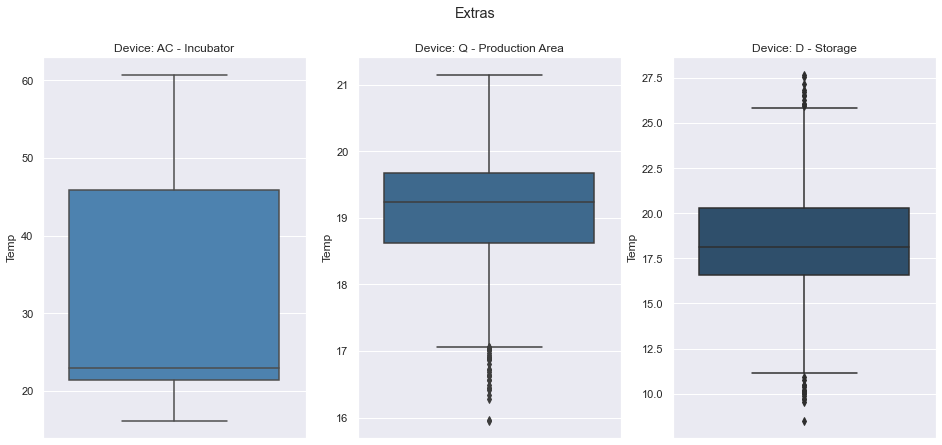

In [50]:
fig, axes = plt.subplots(1,3, figsize=(16,7))
fig.suptitle('Extras')
sns.boxplot(ax=axes[0],y="Temp",data=df_ac_daily,color='#3d84bf')
sns.boxplot(ax=axes[1],y="Temp",data=df_q_daily,color='#316a9a')
sns.boxplot(ax=axes[2],y="Temp",data=df_d_daily,color='#255075')

axes[0].set_title('Device: AC - Incubator')
axes[1].set_title('Device: Q - Production Area')
axes[2].set_title('Device: D - Storage')

plt.show()

Following the same pattern as before, even if device AC does not appear to have any outliers, it is still the device that requires additional supporting data to proceed with further research, thus the second apparent choice is **device D**, which has the second fewest outliers.

## Final Choice

Based on the analysis that we've done, we decide to use **Device K** for the freezer, **Device S** for the Refrigerator, **Device I** for the mapping, and lastly **Device D** as a storage. All of these devices will be accompanied for the following step, which will include a deeper dig into them in terms of missing data, a general session overview, restrictions, and so on, as well as preparing them for modeling.

# Analysis for Device K (Freezer)

This chapter is devoted to the examination of a device K that underpins a category. To prepare for modeling, the freezer will track its activity over months, look for seasonality, outliers, and other factors.

## Seasonality Overview

From the plot below, we can see that on the first plot is showing the outliers from device K in each month, the second plot is showing the overview for the entire week, and lastly the third plot is showing us the overview for the whole day (24 Hours).

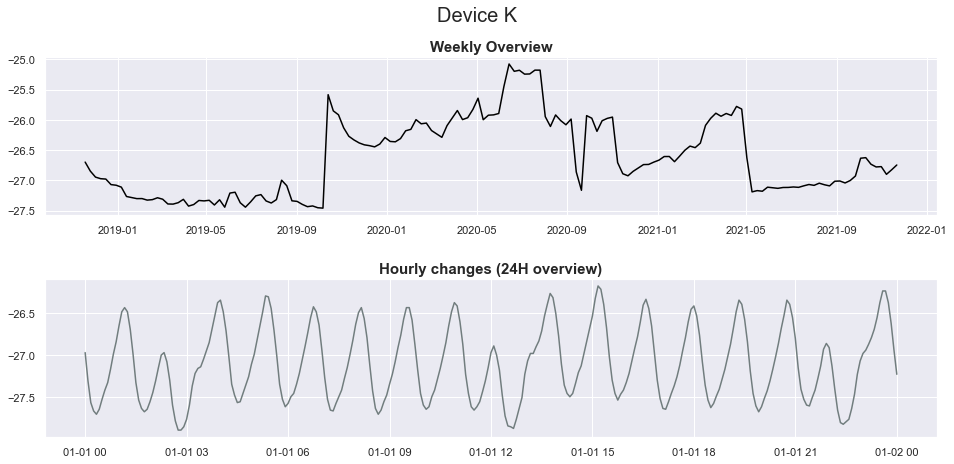

In [51]:
df_k_copy = df_k_daily.copy()
df_k_copy["Month"] = df_k_copy.index.to_period('M')

df_k_zoom = df_k.loc["2019-01-01 00:00:00":"2019-01-02 00:00:00"]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,7))
plt.subplots_adjust(hspace=0.4)
fig.suptitle('Device K',fontsize=20)
axes[0].plot(df_k_weekly,color='black' )
axes[1].plot(df_k_zoom,color='#717D7E')
axes[0].set_title('Weekly Overview', fontsize=15,fontweight='bold')
axes[1].set_title('Hourly changes (24H overview)', fontsize=15,fontweight='bold')

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)  
plt.show()

The seasonal overview shows the spikes in temperature over time in a week's time frame, followed by hourly fluctuations. It can be seen that device K has some ups and downs in temperature, which is not a good indicator, but it is necessary to study more.

## Monthly Examination
This will be a representation of the temperature view across the months in order to track the device's progress.

In [52]:
#copy the dataset
df_k_try=df_k.copy()
#convert dates variables into week, day and month
df_k_try["week"] = df_k_try.index.isocalendar().week
df_k_try["dayofmonth"] = df_k_try.index.day
df_k_try["month"] = df_k_try.index.month
#df_k_try['year']=df_k_try.index.year

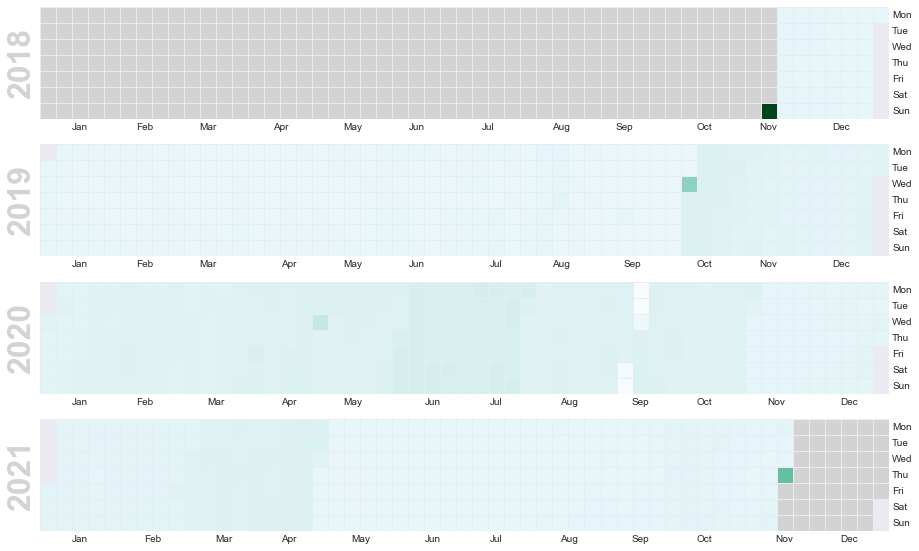

In [55]:
#visualise the heatmap with each month and each day of the week
fig, ax = calmap.calendarplot(df_k_try['Temp'],
                              fillcolor='lightgrey',
                              #dayticks=[0, 2, 4, 6] can zoom into particular days
                              cmap='BuGn',
                              fig_kws={"figsize":(16,8)})

On the basis of the preceding representative, the day-by-day representation of temperature over time may be noticed. The device is mostly stable, with a few black patches that demonstrate some spiking and light grey representing the start and end of the dataset provided. This shows promising results, but it's also a good idea to take a closer look because that's where the next visualisation will appear.

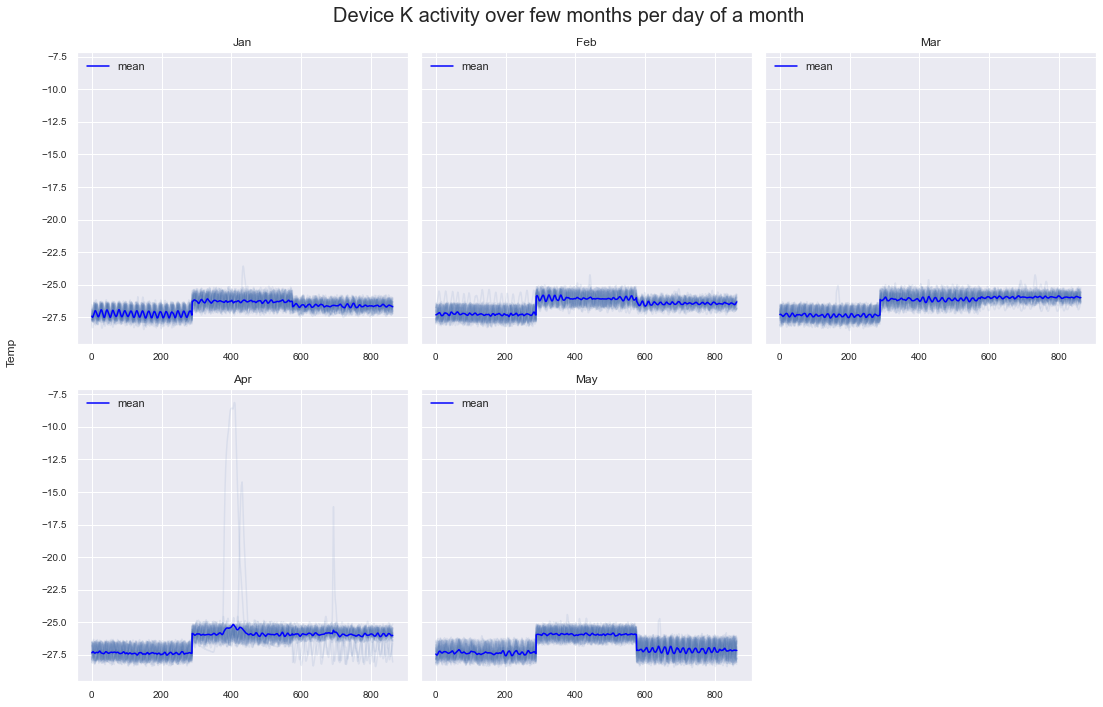

In [56]:
#retrived from: https://github.com/KishManani/MSTL/blob/main/mstl_decomposition.ipynb 

#plot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[15, 10], sharey=True)
fig.subplots_adjust(hspace=.5)
ax = ax.flatten()
sns_blue = sns.color_palette(as_cmap=True)
months = ["Jan", "Feb", "Mar", "Apr", "May"]
for x, month in enumerate(months):

    #origin
    daily_ts = []
    for _, ts in (
        df_k_try[["Temp", "dayofmonth", "month"]]
        .query(f"month == {x+1}") #next month
        .groupby("dayofmonth")
    ):
        daily_ts.append(ts.reset_index()["Temp"])
        ts.reset_index()["Temp"].plot(
            alpha=0.1, ax=ax[x], color=sns_blue, label="_no_legend_"
        )
        ax[x].set_title(month)

    #mean
    pd.concat(daily_ts, axis=1).mean(axis=1).plot(
        ax=ax[x], color="blue", label="mean", legend=True
    )
    ax[x].legend(loc="upper left", frameon=False)


fig.text(-0.02, 0.5, "Temp", va="center", rotation="vertical")
fig.suptitle("Device K activity over few months per day of a month",fontsize=20)
fig.delaxes(ax[-1])
fig.tight_layout()

There isn't much of a variation displayed throughout the course of each month; there is a large surge in April, but the remainder is rather consistent.

## Upper and Lower Limits
As we can see from the plot below that the upper limit from Device K is -20 degrees and the lower limit is below -20 degrees.

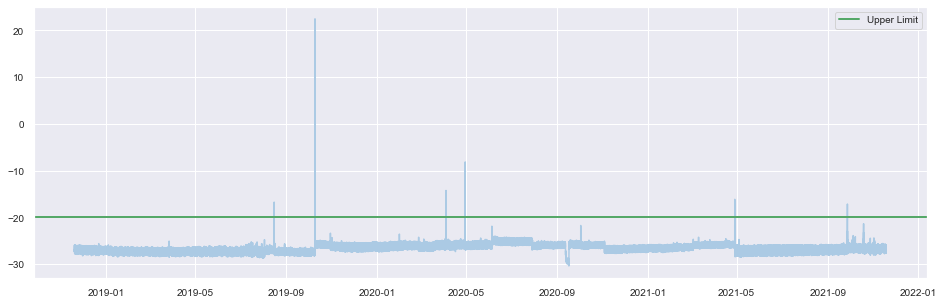

In [57]:
fig, axes = plt.subplots(1,1, figsize=(16,5))
plt.plot(df_k, color='#abcae4')
plt.axhline(y=-20,color='g',linestyle='-',label='Upper Limit',linewidth=2)

plt.legend(prop={'size': 10})

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 

plt.show()

As can be observed, there are a few spikes that exceed the device's upper limit, which is definitely an issue that has to be resolved. This is where the additional steps come in useful to allocate and resolve such outliers, as well as prepare the device K for further interaction.

## Missing Data
Here we can check upon missing values of device K.

In [58]:
df_k.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315648 entries, 2018-11-18 16:40:00 to 2021-11-18 16:35:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Temp    315589 non-null  float64
dtypes: float64(1)
memory usage: 12.9 MB


In [59]:
df_k.isna().sum()

Temp    59
dtype: int64

It can be seen that device K has a total of 59 missing values, which can be used to expand on and allocate with visuals. The following step will be implemented, which will aid in the detection of outliers.

## Outliers Analysis

With that in mind, let's look at the outliers using a density plot and a box plot. Outliers are data points that are markedly different from the rest. On the boxplot, this will be clearly visible.

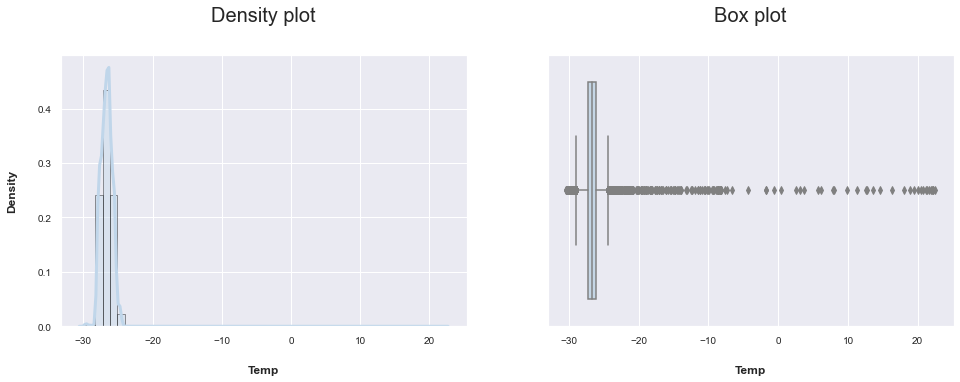

In [60]:
#desntiy plot
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df_k['Temp'],
             color='#C0D6EA',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
plt.margins(0.05)

#extras
plt.title('Density plot',fontsize=20,y=1.1)
plt.ylabel('Density',fontweight='bold',labelpad=20)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

#box plot
plt.subplot(1,2,2)
sns.boxplot(df_k['Temp'],color='#C0D6EA')
plt.margins(0.05)

#extras
plt.title('Box plot',fontsize=20,y=1.1)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

plt.show()

As can be seen for device K, there is a strong bias toward negative temperatures, which is understandable given that it is a freezer; nevertheless, it is also clear that it has a significant number of outliers, which will be resolved in a subsequent stage using IQR.

The Inter-Quartile Range proximity rule is abbreviated as IQR. Where Q1 and Q3 are the dataset's 25th and 75th percentiles, respectively, and IQR is the inter-quartile range, calculated as Q3 – Q1.

In [61]:
#IQR method 
#Finding the IQR
per25 = df_k['Temp'].quantile(0.25)
per75 = df_k['Temp'].quantile(0.75)

#Finding the upper and lower limits
IQR=per75-per25
u_limit = per75 + 1.5 * IQR
l_limit = per25 - 1.5 * IQR

#Finding the outliers
trimed_df_k = df_k[df_k['Temp'] > u_limit]
trimed_df_k = df_k[df_k['Temp'] < l_limit]
trimed_df_k.sample(5)

Temp
EventDt                   
2020-09-14 21:15:00 -29.52
2020-09-13 23:00:00 -29.57
2020-09-14 06:35:00 -29.52
2020-09-15 08:45:00 -29.48
2020-09-14 08:30:00 -29.75

As can be seen, the range is somewhat narrow, with the majority of the values being negative, which is an obvious observation. Let's look at the same graphs but with trimmed data to see the difference.

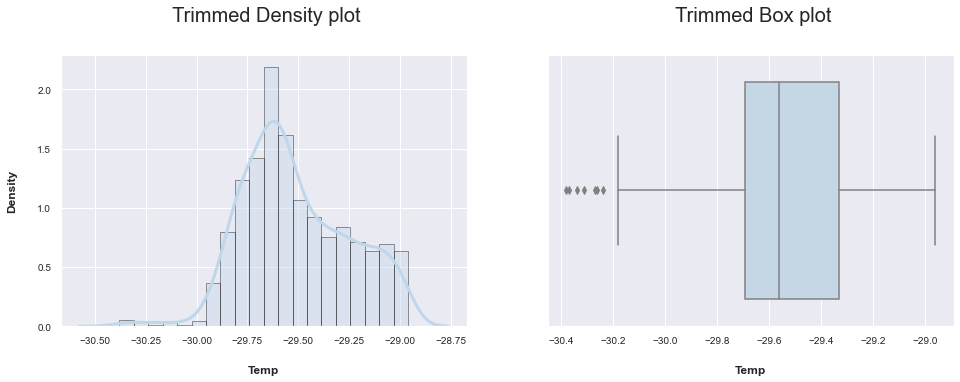

In [62]:
#desntiy plot
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(trimed_df_k['Temp'],
             color='#C0D6EA',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
plt.margins(0.05)

#extras
plt.title(' Trimmed Density plot',fontsize=20,y=1.1)
plt.ylabel('Density',fontweight='bold',labelpad=20)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

#box plot
plt.subplot(1,2,2)
sns.boxplot(trimed_df_k['Temp'],color='#C0D6EA')
plt.margins(0.05)

#extras
plt.title(' Trimmed Box plot',fontsize=20,y=1.1)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

plt.show()

While the density plot has more consistency, the boxplot still has some outliers, and to eliminate them, it is useful to utilize the capping approach, which will help to eliminate more values.

In [65]:
# an option to resolve outlier for like a final is to use capping
cap_df_k = df_k.copy()
#use a method for upper and lower limits
cap_df_k ['Temp'] = np.where(
   cap_df_k ['Temp'] > u_limit,
    u_limit,
    np.where(
        cap_df_k ['Temp'] < l_limit,
        l_limit,
        cap_df_k ['Temp']
    )
)

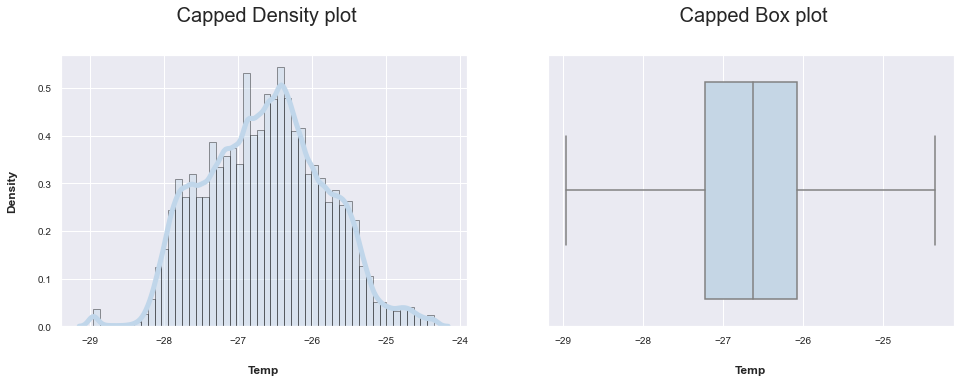

In [66]:
#visualise the capping as a final result
#desntiy plot
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(cap_df_k['Temp'],
             color='#C0D6EA',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 5})
plt.margins(0.05)

#extras
plt.title(' Capped Density plot',fontsize=20,y=1.1)
plt.ylabel('Density',fontweight='bold',labelpad=20)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

#box plot
plt.subplot(1,2,2)
sns.boxplot(cap_df_k ['Temp'],
            color='#C0D6EA')
plt.margins(0.05)

#extras
plt.title(' Capped Box plot',fontsize=20,y=1.1)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

plt.show()

The destribution of temperature values is obvious now that the density and box plot have evolved, but in order to retain such limits in the future interaction, they must be analyzed by clustering and then removed from the dataset.

## Clustering The Outliers

Here we're going to figure out the outliers, to be able to get a closer analysis we're going to split the df_k by year.

### The First Year of Df_K (2018)

In [53]:
df_k_FirstYear = df_k.dropna()
var = datetime(2019, 1, 1)
df_k_FirstYear = df_k_FirstYear[df_k_FirstYear.index < var]
df_k_FirstYear

Temp
EventDt                   
2018-11-18 16:40:00 -25.93
2018-11-18 16:45:00 -26.14
2018-11-18 16:50:00 -26.44
2018-11-18 16:55:00 -26.80
2018-11-18 17:00:00 -27.04
...                    ...
2018-12-31 23:35:00 -26.64
2018-12-31 23:40:00 -26.42
2018-12-31 23:45:00 -26.37
2018-12-31 23:50:00 -26.45
2018-12-31 23:55:00 -26.65

[12470 rows x 1 columns]

In [54]:
outliers = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
clusters = outliers.fit_predict(df_k_FirstYear)
df_k_FirstYear['Cluster'] = clusters
df_k_FirstYear

Temp  Cluster
EventDt                            
2018-11-18 16:40:00 -25.93        0
2018-11-18 16:45:00 -26.14        0
2018-11-18 16:50:00 -26.44        0
2018-11-18 16:55:00 -26.80        0
2018-11-18 17:00:00 -27.04        0
...                    ...      ...
2018-12-31 23:35:00 -26.64        0
2018-12-31 23:40:00 -26.42        0
2018-12-31 23:45:00 -26.37        0
2018-12-31 23:50:00 -26.45        0
2018-12-31 23:55:00 -26.65        0

[12470 rows x 2 columns]

In [55]:
df_k_FirstYear['ClusterName'] = df_k_FirstYear['Cluster'].map({0: "Normal data", -1: "Outlier"})
df_k_FirstYear

Temp  Cluster  ClusterName
EventDt                                         
2018-11-18 16:40:00 -25.93        0  Normal data
2018-11-18 16:45:00 -26.14        0  Normal data
2018-11-18 16:50:00 -26.44        0  Normal data
2018-11-18 16:55:00 -26.80        0  Normal data
2018-11-18 17:00:00 -27.04        0  Normal data
...                    ...      ...          ...
2018-12-31 23:35:00 -26.64        0  Normal data
2018-12-31 23:40:00 -26.42        0  Normal data
2018-12-31 23:45:00 -26.37        0  Normal data
2018-12-31 23:50:00 -26.45        0  Normal data
2018-12-31 23:55:00 -26.65        0  Normal data

[12470 rows x 3 columns]

<AxesSubplot:xlabel='EventDt', ylabel='Temp'>

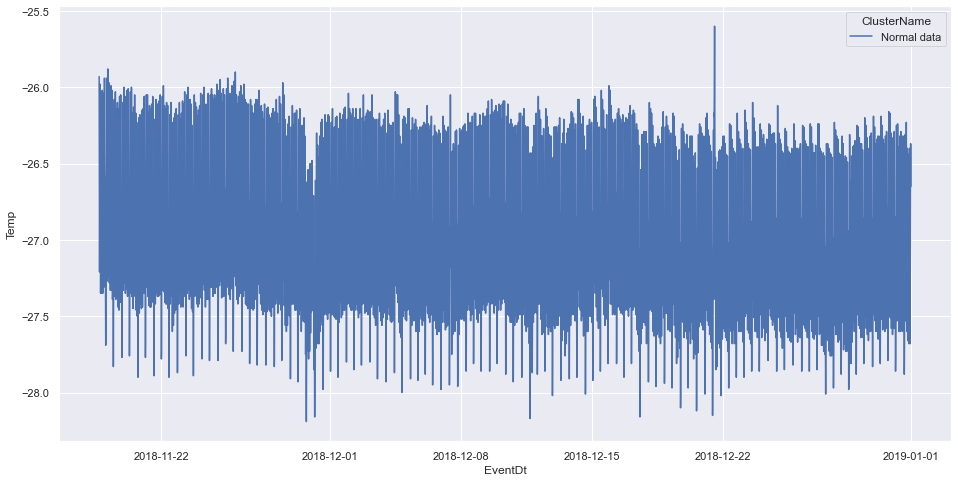

In [56]:
plt.figure(figsize=(16,8))
sns.lineplot(data= df_k_FirstYear, x= df_k_FirstYear.index, y='Temp', hue = 'ClusterName')

In [57]:
ourtlier2018 = df_k_FirstYear[df_k_FirstYear['ClusterName'] == 'Outlier']
outlier2018count = len(ourtlier2018)
outlier2018count

0

### The Second Year of Df_K (2019)

In [20]:
df_k_SecondYear = df_k.dropna()
var = datetime(2019, 1, 1)
var2 = datetime(2020, 1, 1)
df_k_SecondYear = df_k_SecondYear[df_k_SecondYear.index > var]
df_k_SecondYear = df_k_SecondYear[df_k_SecondYear.index < var2]
df_k_SecondYear

Temp
EventDt                   
2019-01-01 00:05:00 -27.31
2019-01-01 00:10:00 -27.57
2019-01-01 00:15:00 -27.67
2019-01-01 00:20:00 -27.71
2019-01-01 00:25:00 -27.65
...                    ...
2019-12-31 23:35:00 -26.52
2019-12-31 23:40:00 -26.43
2019-12-31 23:45:00 -26.29
2019-12-31 23:50:00 -26.11
2019-12-31 23:55:00 -25.97

[105097 rows x 1 columns]

In [21]:
outliers = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
clusters = outliers.fit_predict(df_k_SecondYear)
df_k_SecondYear['Cluster'] = clusters
df_k_SecondYear

Temp  Cluster
EventDt                            
2019-01-01 00:05:00 -27.31        0
2019-01-01 00:10:00 -27.57        0
2019-01-01 00:15:00 -27.67        0
2019-01-01 00:20:00 -27.71        0
2019-01-01 00:25:00 -27.65        0
...                    ...      ...
2019-12-31 23:35:00 -26.52        0
2019-12-31 23:40:00 -26.43        0
2019-12-31 23:45:00 -26.29        0
2019-12-31 23:50:00 -26.11        0
2019-12-31 23:55:00 -25.97        0

[105097 rows x 2 columns]

In [22]:
df_k_SecondYear['ClusterName'] = df_k_SecondYear['Cluster'].map({0: "Normal data", -1: "Outlier"})
df_k_SecondYear

Temp  Cluster  ClusterName
EventDt                                         
2019-01-01 00:05:00 -27.31        0  Normal data
2019-01-01 00:10:00 -27.57        0  Normal data
2019-01-01 00:15:00 -27.67        0  Normal data
2019-01-01 00:20:00 -27.71        0  Normal data
2019-01-01 00:25:00 -27.65        0  Normal data
...                    ...      ...          ...
2019-12-31 23:35:00 -26.52        0  Normal data
2019-12-31 23:40:00 -26.43        0  Normal data
2019-12-31 23:45:00 -26.29        0  Normal data
2019-12-31 23:50:00 -26.11        0  Normal data
2019-12-31 23:55:00 -25.97        0  Normal data

[105097 rows x 3 columns]

<AxesSubplot:xlabel='EventDt', ylabel='Temp'>

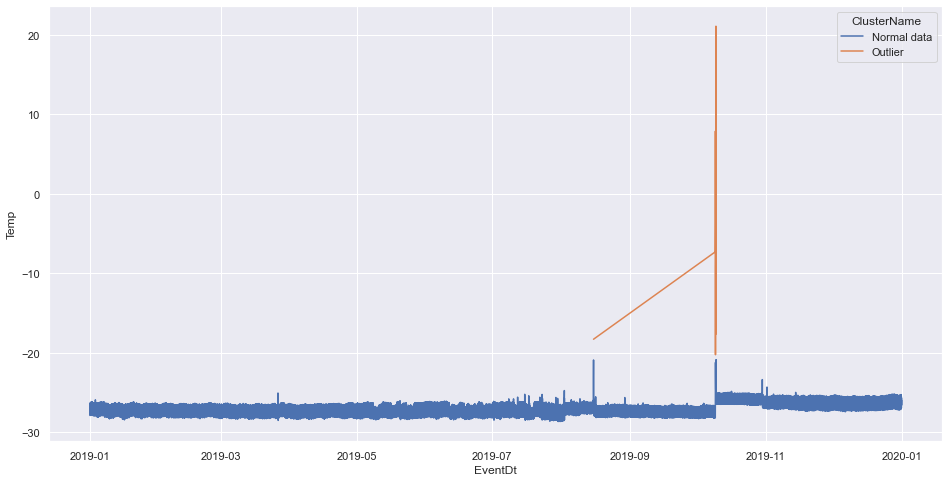

In [23]:
plt.figure(figsize=(16,8))
sns.lineplot(data= df_k_SecondYear, x= df_k_SecondYear.index, y='Temp', hue = 'ClusterName')

In [35]:
ourtlier2019 = df_k_SecondYear[df_k_SecondYear['ClusterName'] == 'Outlier']
outlier2019count = len(ourtlier2019)
outlier2019count

40

### The Third Year of Df_K (2020)

In [40]:
df_k_ThirdYear = df_k.dropna()
var = datetime(2020, 1, 1)
var2 = datetime(2021, 1, 1)
df_k_ThirdYear = df_k_ThirdYear[df_k_ThirdYear.index > var]
df_k_ThirdYear = df_k_ThirdYear[df_k_ThirdYear.index < var2]
df_k_ThirdYear

Temp
EventDt                   
2020-01-01 00:05:00 -25.61
2020-01-01 00:10:00 -25.63
2020-01-01 00:15:00 -25.75
2020-01-01 00:20:00 -25.95
2020-01-01 00:25:00 -26.23
...                    ...
2020-12-31 23:35:00 -27.02
2020-12-31 23:40:00 -26.98
2020-12-31 23:45:00 -26.91
2020-12-31 23:50:00 -26.84
2020-12-31 23:55:00 -26.73

[105380 rows x 1 columns]

In [41]:
outliers = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
clusters = outliers.fit_predict(df_k_ThirdYear)
df_k_ThirdYear['Cluster'] = clusters
df_k_ThirdYear

Temp  Cluster
EventDt                            
2020-01-01 00:05:00 -25.61        0
2020-01-01 00:10:00 -25.63        0
2020-01-01 00:15:00 -25.75        0
2020-01-01 00:20:00 -25.95        0
2020-01-01 00:25:00 -26.23        0
...                    ...      ...
2020-12-31 23:35:00 -27.02        0
2020-12-31 23:40:00 -26.98        0
2020-12-31 23:45:00 -26.91        0
2020-12-31 23:50:00 -26.84        0
2020-12-31 23:55:00 -26.73        0

[105380 rows x 2 columns]

In [42]:
df_k_ThirdYear['ClusterName'] = df_k_ThirdYear['Cluster'].map({0: "Normal data", -1: "Outlier"})
df_k_ThirdYear

Temp  Cluster  ClusterName
EventDt                                         
2020-01-01 00:05:00 -25.61        0  Normal data
2020-01-01 00:10:00 -25.63        0  Normal data
2020-01-01 00:15:00 -25.75        0  Normal data
2020-01-01 00:20:00 -25.95        0  Normal data
2020-01-01 00:25:00 -26.23        0  Normal data
...                    ...      ...          ...
2020-12-31 23:35:00 -27.02        0  Normal data
2020-12-31 23:40:00 -26.98        0  Normal data
2020-12-31 23:45:00 -26.91        0  Normal data
2020-12-31 23:50:00 -26.84        0  Normal data
2020-12-31 23:55:00 -26.73        0  Normal data

[105380 rows x 3 columns]

<AxesSubplot:xlabel='EventDt', ylabel='Temp'>

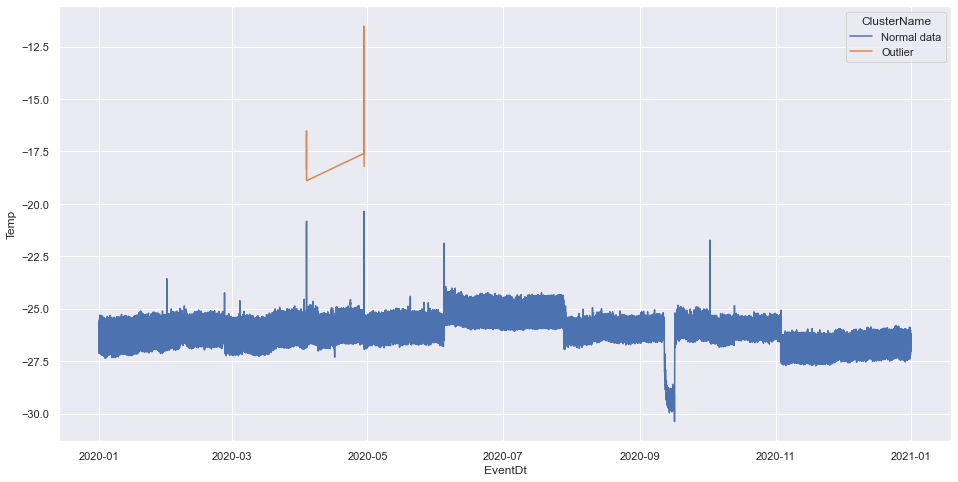

In [43]:
plt.figure(figsize=(16,8))
sns.lineplot(data= df_k_ThirdYear, x= df_k_ThirdYear.index, y='Temp', hue = 'ClusterName')

In [44]:
ourtlier2020 = df_k_ThirdYear[df_k_ThirdYear['ClusterName'] == 'Outlier']
outlier2020count = len(ourtlier2020)
outlier2020count

16

### The Fourth Year of Df_K (2021)

In [45]:
df_k_FourthYear = df_k.dropna()
var = datetime(2021, 1, 1)
var2 = datetime(2022, 1, 1)
df_k_FourthYear = df_k_FourthYear[df_k_FourthYear.index > var]
df_k_FourthYear = df_k_FourthYear[df_k_FourthYear.index < var2]
df_k_FourthYear

Temp
EventDt                   
2021-01-01 00:05:00 -26.48
2021-01-01 00:10:00 -26.31
2021-01-01 00:15:00 -26.25
2021-01-01 00:20:00 -26.28
2021-01-01 00:25:00 -26.37
...                    ...
2021-11-18 16:15:00 -26.95
2021-11-18 16:20:00 -26.76
2021-11-18 16:25:00 -26.54
2021-11-18 16:30:00 -26.54
2021-11-18 16:35:00 -26.77

[92639 rows x 1 columns]

In [46]:
outliers = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
clusters = outliers.fit_predict(df_k_FourthYear)
df_k_FourthYear['Cluster'] = clusters
df_k_FourthYear

Temp  Cluster
EventDt                            
2021-01-01 00:05:00 -26.48        0
2021-01-01 00:10:00 -26.31        0
2021-01-01 00:15:00 -26.25        0
2021-01-01 00:20:00 -26.28        0
2021-01-01 00:25:00 -26.37        0
...                    ...      ...
2021-11-18 16:15:00 -26.95        0
2021-11-18 16:20:00 -26.76        0
2021-11-18 16:25:00 -26.54        0
2021-11-18 16:30:00 -26.54        0
2021-11-18 16:35:00 -26.77        0

[92639 rows x 2 columns]

In [47]:
df_k_FourthYear['ClusterName'] = df_k_FourthYear['Cluster'].map({0: "Normal data", -1: "Outlier"})
df_k_FourthYear

Temp  Cluster  ClusterName
EventDt                                         
2021-01-01 00:05:00 -26.48        0  Normal data
2021-01-01 00:10:00 -26.31        0  Normal data
2021-01-01 00:15:00 -26.25        0  Normal data
2021-01-01 00:20:00 -26.28        0  Normal data
2021-01-01 00:25:00 -26.37        0  Normal data
...                    ...      ...          ...
2021-11-18 16:15:00 -26.95        0  Normal data
2021-11-18 16:20:00 -26.76        0  Normal data
2021-11-18 16:25:00 -26.54        0  Normal data
2021-11-18 16:30:00 -26.54        0  Normal data
2021-11-18 16:35:00 -26.77        0  Normal data

[92639 rows x 3 columns]

<AxesSubplot:xlabel='EventDt', ylabel='Temp'>

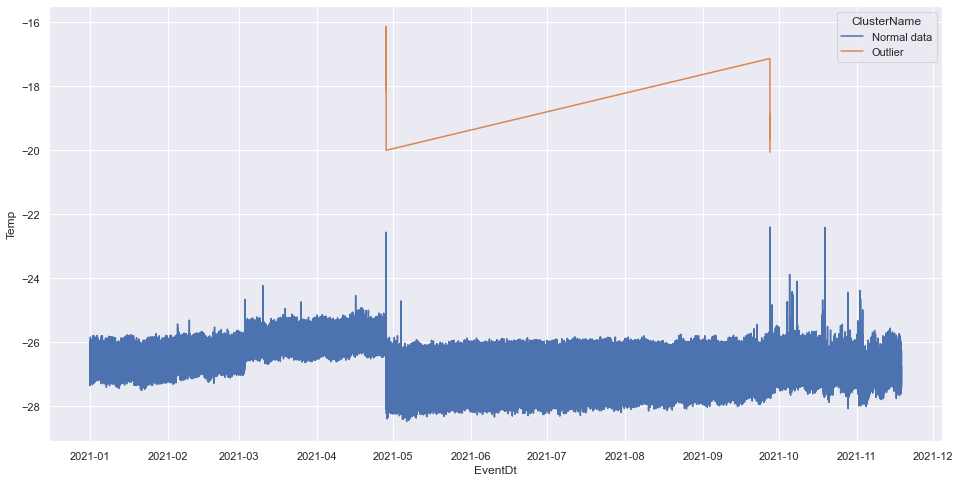

In [48]:
plt.figure(figsize=(16,8))
sns.lineplot(data= df_k_FourthYear, x= df_k_FourthYear.index, y='Temp', hue = 'ClusterName')

In [49]:
ourtlier2021 = df_k_FourthYear[df_k_FourthYear['ClusterName'] == 'Outlier']
outlier2021count = len(ourtlier2021)
outlier2021count

9

## Merge the DF_K Dataframe into One Dataframe

In [75]:
frames = [ourtlier2019, ourtlier2020, ourtlier2021]
result = pd.concat(frames)
allOutlieramount = len(result)

In [134]:
whole_data = [df_k_FirstYear, df_k_SecondYear, df_k_ThirdYear, df_k_FourthYear]
sum_data = pd.concat(whole_data)
sum_data

Temp  Cluster  ClusterName
EventDt                                         
2018-11-18 16:40:00 -25.93        0  Normal data
2018-11-18 16:45:00 -26.14        0  Normal data
2018-11-18 16:50:00 -26.44        0  Normal data
2018-11-18 16:55:00 -26.80        0  Normal data
2018-11-18 17:00:00 -27.04        0  Normal data
...                    ...      ...          ...
2021-11-18 16:15:00 -26.95        0  Normal data
2021-11-18 16:20:00 -26.76        0  Normal data
2021-11-18 16:25:00 -26.54        0  Normal data
2021-11-18 16:30:00 -26.54        0  Normal data
2021-11-18 16:35:00 -26.77        0  Normal data

[315586 rows x 3 columns]

## Checking the Percentage of the Outliers

It's crucial to determine how much the outliers contribute inside the device; aside from displaying them and then clustering them, it's also crucial to determine the percentage it takes for the entire device to determine whether it needs to be checked more closely or replaced, and so on.

In [152]:
allDataAmount = len(sum_data)

#finding the %
def percentage(part, whole):
  Percentage = 100 * int(part)/int(whole)
  return Percentage
percent = percentage(allOutlieramount,allDataAmount)
print(f'Percentage: {round(percent,2)} %')

Percentage: 0.02 %


## Removing the Outliers

In [139]:
drop_Outliers_dfK = sum_data.drop(index = result.index)
drop_Outliers_dfK

Temp  Cluster  ClusterName
EventDt                                         
2018-11-18 16:40:00 -25.93        0  Normal data
2018-11-18 16:45:00 -26.14        0  Normal data
2018-11-18 16:50:00 -26.44        0  Normal data
2018-11-18 16:55:00 -26.80        0  Normal data
2018-11-18 17:00:00 -27.04        0  Normal data
...                    ...      ...          ...
2021-11-18 16:15:00 -26.95        0  Normal data
2021-11-18 16:20:00 -26.76        0  Normal data
2021-11-18 16:25:00 -26.54        0  Normal data
2021-11-18 16:30:00 -26.54        0  Normal data
2021-11-18 16:35:00 -26.77        0  Normal data

[315521 rows x 3 columns]

<AxesSubplot:xlabel='EventDt', ylabel='Temp'>

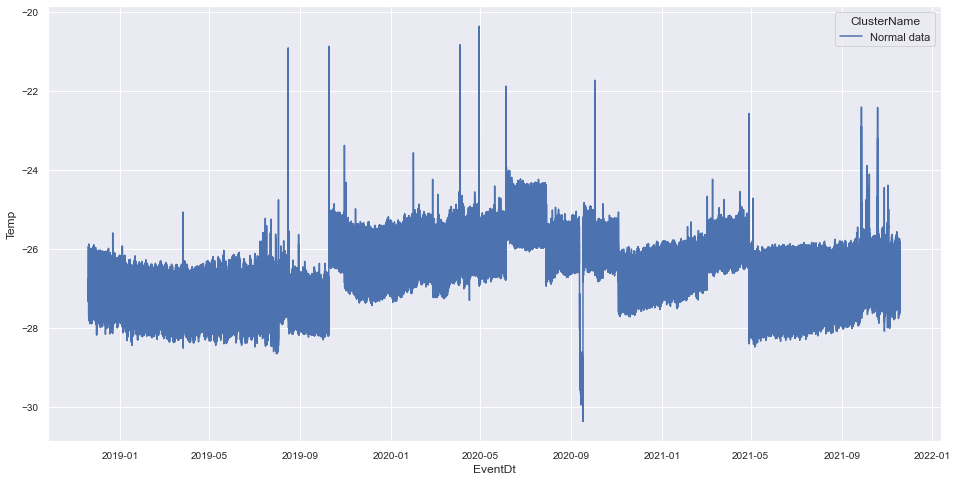

In [151]:
plt.figure(figsize=(16,8))
sns.lineplot(data= drop_Outliers_dfK, color='#C0D6EA', x= drop_Outliers_dfK.index, y='Temp', hue = 'ClusterName')

# Analysis for Device S (Refrigerators)

## Seasonality Overview

From the plot below, we can see that on the first plot is showing the outliers from device S in each month, the second plot is showing the overview for the entire week, and lastly the third plot is showing us the overview for the whole day (24 Hours).

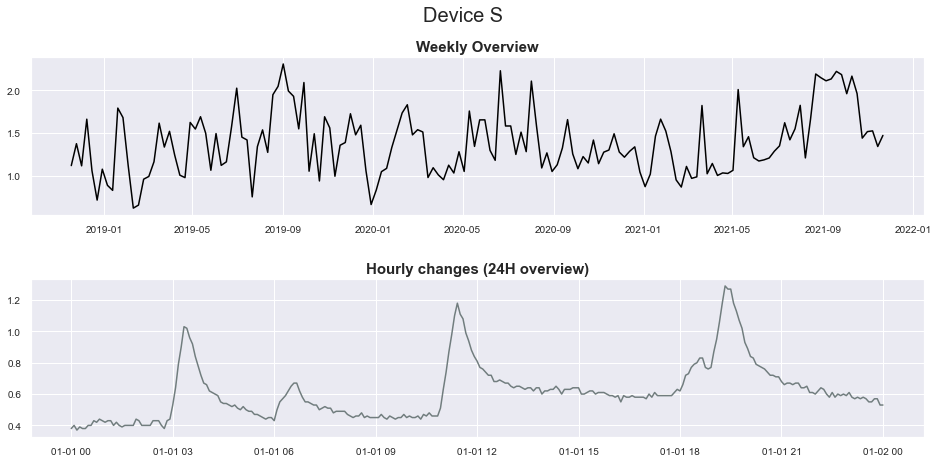

In [119]:
df_s_copy = df_s_daily.copy()
df_s_copy["Month"] = df_s_copy.index.to_period('M')

df_s_zoom = df_s.loc["2019-01-01 00:00:00":"2019-01-02 00:00:00"]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,7))
plt.subplots_adjust(hspace=0.4)
fig.suptitle('Device S',fontsize=20)
axes[0].plot(df_s_weekly,color='black' )
axes[1].plot(df_s_zoom,color='#717D7E')
axes[0].set_title('Weekly Overview', fontsize=15,fontweight='bold')
axes[1].set_title('Hourly changes (24H overview)', fontsize=15,fontweight='bold')

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)  
plt.show()

There are definately more patterns in our weekly overview and hourly changes than on the previous device, which is visible especially on the hourly change and is useful to study more.

## Monthly Examination
This will be a representation of the temperature view across the months in order to track the device's progress.

In [120]:
#copy the dataset
df_s_try=df_s.copy()
#convert dates variables into week, day and month
df_s_try["week"] = df_s_try.index.isocalendar().week
df_s_try["dayofmonth"] = df_s_try.index.day
df_s_try["month"] = df_s_try.index.month

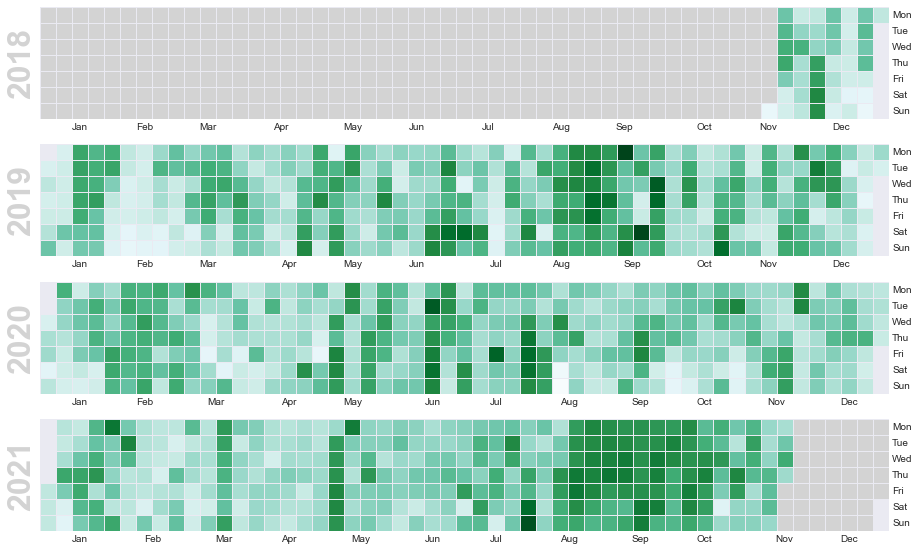

In [121]:
#visualise the heatmap with each month and each day of the week
fig, ax = calmap.calendarplot(df_s_try['Temp'],
                              fillcolor='lightgrey',
                              cmap='BuGn',
                              fig_kws={"figsize":(16,8)})

As can be observed, the device S has more spikes than the device K, as indicated by the darker patches. As can be seen, the months of August to September are the ones in which the device received the most spots, which could imply that that time of year in the area is the warmest, which is why the device went out of range.

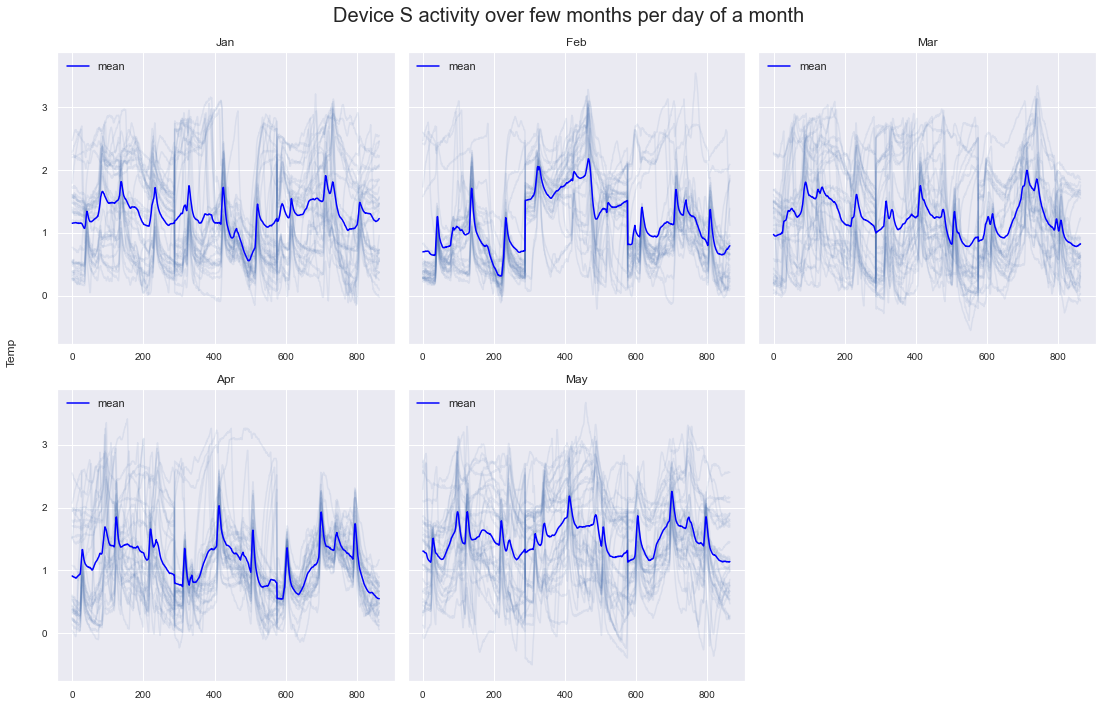

In [122]:
#plot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[15, 10], sharey=True)
fig.subplots_adjust(hspace=.5)
ax = ax.flatten()
sns_blue = sns.color_palette(as_cmap=True)
months = ["Jan", "Feb", "Mar", "Apr", "May"]
for y, month in enumerate(months):

    #origin
    daily_ts = []
    for _, ts in (
        df_s_try[["Temp", "dayofmonth", "month"]]
        .query(f"month == {y+1}") #next month
        .groupby("dayofmonth")
    ):
        daily_ts.append(ts.reset_index()["Temp"])
        ts.reset_index()["Temp"].plot(
            alpha=0.1, ax=ax[y], color=sns_blue, label="_no_legend_"
        )
        ax[y].set_title(month)

    #mean
    pd.concat(daily_ts, axis=1).mean(axis=1).plot(
        ax=ax[y], color="blue", label="mean", legend=True
    )
    ax[y].legend(loc="upper left", frameon=False)


fig.text(-0.02, 0.5, "Temp", va="center", rotation="vertical")
fig.suptitle("Device S activity over few months per day of a month",fontsize=20)
fig.delaxes(ax[-1])
fig.tight_layout()

It can be observed that February has the most unstable behavior of all the months, but it also goes a little off in May. However, as can be seen on camp visual's graphical representation, this is a somewhat unstable device with some problems.  

## Upper and Lower Limits

Upper and lower limits are taken from another dataset; for example, for device S, the upper limit is 25 and the bottom limit is 8; to show this, as well as the device's consistency through time, see the visual below.

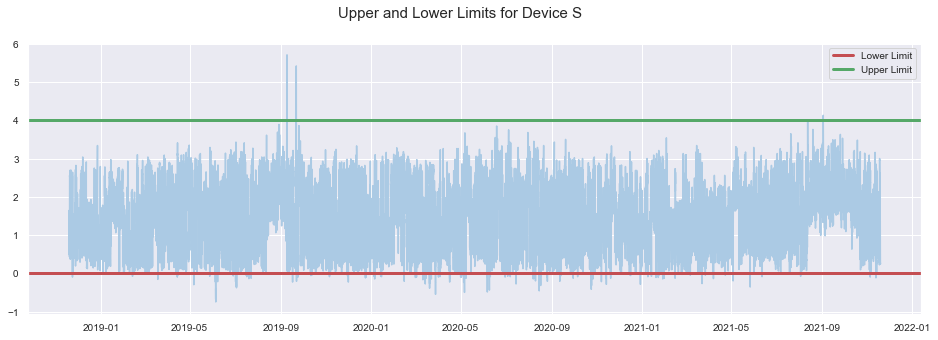

In [123]:
fig, axes = plt.subplots(1,1, figsize=(16,5))
fig.suptitle('Upper and Lower Limits for Device S',fontsize=15)
plt.plot(df_s,color="#abcae4")
plt.axhline(y=0,color='r',linestyle='-',label='Lower Limit',linewidth=3) #taken from another dataset
plt.axhline(y=4,color='g',linestyle='-',label='Upper Limit',linewidth=3)

plt.legend(prop={'size': 10})

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 

plt.show()

As can be seen, there are a few spikes on and off the range; therefore, in order to prevent this from happening in the model, an approach will be used to obtain outlier analysis, clustering, and finally the removal of outliers as a final result.

## Missing Data

Before going deeper into the device's initial analysis, it's a good idea to check for any missing data first, it comes down to similar steps as the previous device.

In [105]:
df_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315647 entries, 2018-11-18 16:50:00 to 2021-11-18 16:40:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Temp    315640 non-null  float64
dtypes: float64(1)
memory usage: 12.9 MB


In [106]:
df_s.isna().sum()

Temp    7
dtype: int64

As can be seen on this analysis, *device S* contains up to 7 missng values, which is much lower compare to the previous device and a total of 315.648.

## Outliers Analyis

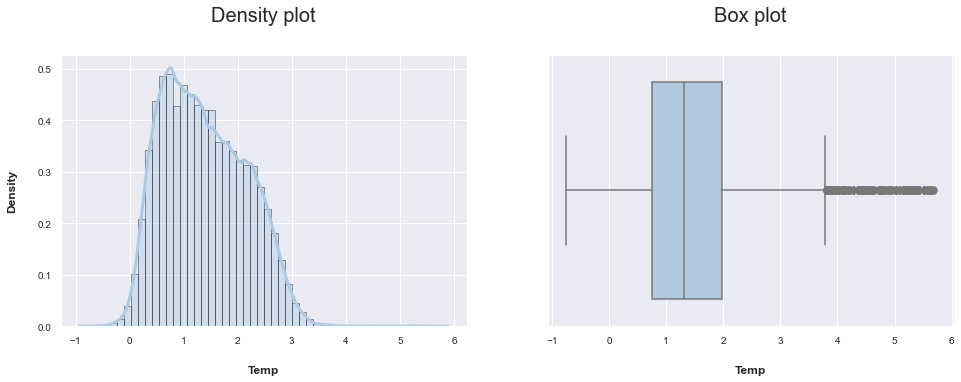

In [34]:
#desntiy plot
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df_s['Temp'],
             color='#abcae4',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
plt.margins(0.05)

#extras
plt.title('Density plot',fontsize=20,y=1.1)
plt.ylabel('Density',fontweight='bold',labelpad=20)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

#box plot
plt.subplot(1,2,2)
sns.boxplot(df_s['Temp'],
             color='#abcae4')
plt.margins(0.05)

#extras
plt.title('Box plot',fontsize=20,y=1.1)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

plt.show()


With that in mind, let's look at the outliers using a density plot and a box plot. Outliers are data points that are markedly different from the rest. On the boxplot, this will be clearly visible.

In [35]:
#IQR method 
#Finding the IQR
perc25_s = df_s['Temp'].quantile(0.25)
perc75_s = df_s['Temp'].quantile(0.75)

#Finding the upper and lower limits
IQR_s = perc75_s - perc25_s
upper_limit_s = perc75_s + 1.5 * IQR_s
lower_limit_s = perc25_s - 1.5 * IQR_s

#Finding the outliers
trimed_df_s=df_s[df_s['Temp'] > upper_limit_s]
#df_s[df_s['Temp'] < lower_limit_s] nothing lower than already the lowest point maybe change the method but will see
trimed_df_s.sample(5)

Temp
EventDt                  
2019-09-21 18:45:00  5.25
2019-09-09 05:30:00  4.60
2019-09-09 00:45:00  3.95
2019-09-21 16:20:00  5.03
2019-09-09 08:15:00  5.57

Based on the samples, the approximate range is in the 3 to 6 range. It is also useful to visualize further to compare the findings of the broad visualisation above.

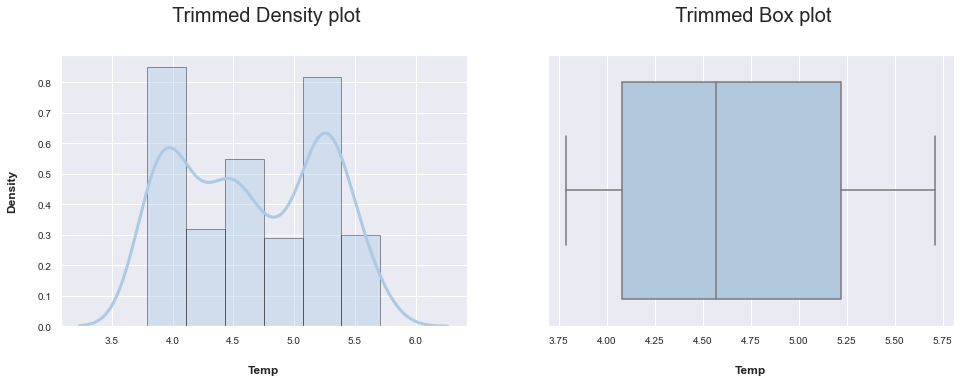

In [36]:
#desntiy plot
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(trimed_df_s['Temp'],
             color='#abcae4',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
plt.margins(0.05)

#extras
plt.title(' Trimmed Density plot',fontsize=20,y=1.1)
plt.ylabel('Density',fontweight='bold',labelpad=20)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

#box plot
plt.subplot(1,2,2)
sns.boxplot(trimed_df_s['Temp'],color='#abcae4')
plt.margins(0.05)

#extras
plt.title(' Trimmed Box plot',fontsize=20,y=1.1)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

plt.show()

The destribution of temperature values is clear now that the density and box plot have evolved, but they must be examined by clustering and then eliminated from the dataset in order to keep such restrictions in future interactions.

## Clustering the Outliers

Here we're going to figure out the outliers, to be able to get a closer analysis we're going to split the Refrigerator(df_s) by year.

### The First Year of Df_S (2018)

In [153]:
df_s_FirstYear = df_s.dropna()
var = datetime(2019, 1, 1)
df_s_FirstYear = df_s_FirstYear[df_s_FirstYear.index < var]
df_s_FirstYear

Temp
EventDt                  
2018-11-18 16:50:00  1.23
2018-11-18 16:55:00  1.24
2018-11-18 17:00:00  1.20
2018-11-18 17:05:00  1.18
2018-11-18 17:10:00  1.17
...                   ...
2018-12-31 23:35:00  0.36
2018-12-31 23:40:00  0.38
2018-12-31 23:45:00  0.38
2018-12-31 23:50:00  0.39
2018-12-31 23:55:00  0.37

[12470 rows x 1 columns]

In [154]:
outliers = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
clusters = outliers.fit_predict(df_s_FirstYear)
df_s_FirstYear['Cluster'] = clusters
df_s_FirstYear

Temp  Cluster
EventDt                           
2018-11-18 16:50:00  1.23        0
2018-11-18 16:55:00  1.24        0
2018-11-18 17:00:00  1.20        0
2018-11-18 17:05:00  1.18        0
2018-11-18 17:10:00  1.17        0
...                   ...      ...
2018-12-31 23:35:00  0.36        0
2018-12-31 23:40:00  0.38        0
2018-12-31 23:45:00  0.38        0
2018-12-31 23:50:00  0.39        0
2018-12-31 23:55:00  0.37        0

[12470 rows x 2 columns]

In [155]:
df_s_FirstYear['ClusterName'] = df_s_FirstYear['Cluster'].map({0: "Normal data", -1: "Outlier"})
df_s_FirstYear

Temp  Cluster  ClusterName
EventDt                                        
2018-11-18 16:50:00  1.23        0  Normal data
2018-11-18 16:55:00  1.24        0  Normal data
2018-11-18 17:00:00  1.20        0  Normal data
2018-11-18 17:05:00  1.18        0  Normal data
2018-11-18 17:10:00  1.17        0  Normal data
...                   ...      ...          ...
2018-12-31 23:35:00  0.36        0  Normal data
2018-12-31 23:40:00  0.38        0  Normal data
2018-12-31 23:45:00  0.38        0  Normal data
2018-12-31 23:50:00  0.39        0  Normal data
2018-12-31 23:55:00  0.37        0  Normal data

[12470 rows x 3 columns]

<AxesSubplot:xlabel='EventDt', ylabel='Temp'>

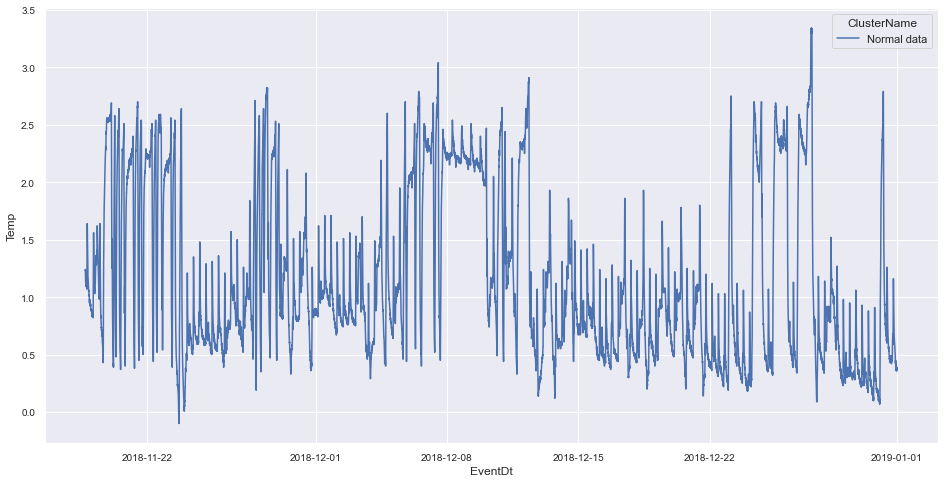

In [156]:
plt.figure(figsize=(16,8))
sns.lineplot(data= df_s_FirstYear, x= df_s_FirstYear.index, y='Temp', hue = 'ClusterName')

In [157]:
ourtlier2018_s = df_s_FirstYear[df_s_FirstYear['ClusterName'] == 'Outlier']
outlier2018count_s = len(ourtlier2018_s)
outlier2018count_s

0

### The Second Year of S (2019)

In [158]:
df_s_SecondYear = df_s.dropna()
var = datetime(2019, 1, 1)
var2 = datetime(2020, 1, 1)
df_s_SecondYear = df_s_SecondYear[df_s_SecondYear.index > var]
df_s_SecondYear = df_s_SecondYear[df_s_SecondYear.index < var2]
df_s_SecondYear

Temp
EventDt                  
2019-01-01 00:05:00  0.40
2019-01-01 00:10:00  0.37
2019-01-01 00:15:00  0.39
2019-01-01 00:20:00  0.38
2019-01-01 00:25:00  0.38
...                   ...
2019-12-31 23:35:00  0.45
2019-12-31 23:40:00  0.45
2019-12-31 23:45:00  0.47
2019-12-31 23:50:00  0.48
2019-12-31 23:55:00  0.47

[105119 rows x 1 columns]

In [159]:
outliers = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
clusters = outliers.fit_predict(df_s_SecondYear)
df_s_SecondYear['Cluster'] = clusters
df_s_SecondYear

Temp  Cluster
EventDt                           
2019-01-01 00:05:00  0.40        0
2019-01-01 00:10:00  0.37        0
2019-01-01 00:15:00  0.39        0
2019-01-01 00:20:00  0.38        0
2019-01-01 00:25:00  0.38        0
...                   ...      ...
2019-12-31 23:35:00  0.45        0
2019-12-31 23:40:00  0.45        0
2019-12-31 23:45:00  0.47        0
2019-12-31 23:50:00  0.48        0
2019-12-31 23:55:00  0.47        0

[105119 rows x 2 columns]

In [160]:
df_s_SecondYear['ClusterName'] = df_s_SecondYear['Cluster'].map({0: "Normal data", -1: "Outlier"})
df_s_SecondYear

Temp  Cluster  ClusterName
EventDt                                        
2019-01-01 00:05:00  0.40        0  Normal data
2019-01-01 00:10:00  0.37        0  Normal data
2019-01-01 00:15:00  0.39        0  Normal data
2019-01-01 00:20:00  0.38        0  Normal data
2019-01-01 00:25:00  0.38        0  Normal data
...                   ...      ...          ...
2019-12-31 23:35:00  0.45        0  Normal data
2019-12-31 23:40:00  0.45        0  Normal data
2019-12-31 23:45:00  0.47        0  Normal data
2019-12-31 23:50:00  0.48        0  Normal data
2019-12-31 23:55:00  0.47        0  Normal data

[105119 rows x 3 columns]

<AxesSubplot:xlabel='EventDt', ylabel='Temp'>

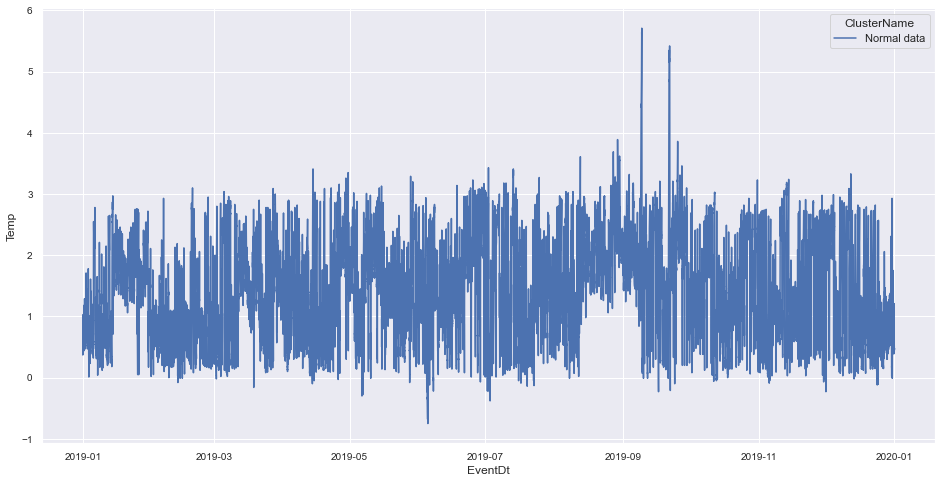

In [161]:
plt.figure(figsize=(16,8))
sns.lineplot(data= df_s_SecondYear, x= df_s_SecondYear.index, y='Temp', hue = 'ClusterName')

In [162]:
ourtlier2019_s = df_s_SecondYear[df_s_SecondYear['ClusterName'] == 'Outlier']
outlier2019count_s = len(ourtlier2019_s)
outlier2019count_s

0

### The Third Year of Df_S (2020)

In [163]:
df_s_ThirdYear = df_s.dropna()
var = datetime(2020, 1, 1)
var2 = datetime(2021, 1, 1)
df_s_ThirdYear = df_s_ThirdYear[df_s_ThirdYear.index > var]
df_s_ThirdYear = df_s_ThirdYear[df_s_ThirdYear.index < var2]
df_s_ThirdYear

Temp
EventDt                  
2020-01-01 00:05:00  0.46
2020-01-01 00:10:00  0.47
2020-01-01 00:15:00  0.47
2020-01-01 00:20:00  0.47
2020-01-01 00:25:00  0.47
...                   ...
2020-12-31 23:35:00  0.67
2020-12-31 23:40:00  0.66
2020-12-31 23:45:00  0.64
2020-12-31 23:50:00  0.67
2020-12-31 23:55:00  0.67

[105401 rows x 1 columns]

In [164]:
outliers = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
clusters = outliers.fit_predict(df_s_ThirdYear)
df_s_ThirdYear['Cluster'] = clusters
df_s_ThirdYear

Temp  Cluster
EventDt                           
2020-01-01 00:05:00  0.46        0
2020-01-01 00:10:00  0.47        0
2020-01-01 00:15:00  0.47        0
2020-01-01 00:20:00  0.47        0
2020-01-01 00:25:00  0.47        0
...                   ...      ...
2020-12-31 23:35:00  0.67        0
2020-12-31 23:40:00  0.66        0
2020-12-31 23:45:00  0.64        0
2020-12-31 23:50:00  0.67        0
2020-12-31 23:55:00  0.67        0

[105401 rows x 2 columns]

In [165]:
df_s_ThirdYear['ClusterName'] = df_s_ThirdYear['Cluster'].map({0: "Normal data", -1: "Outlier"})
df_s_ThirdYear

Temp  Cluster  ClusterName
EventDt                                        
2020-01-01 00:05:00  0.46        0  Normal data
2020-01-01 00:10:00  0.47        0  Normal data
2020-01-01 00:15:00  0.47        0  Normal data
2020-01-01 00:20:00  0.47        0  Normal data
2020-01-01 00:25:00  0.47        0  Normal data
...                   ...      ...          ...
2020-12-31 23:35:00  0.67        0  Normal data
2020-12-31 23:40:00  0.66        0  Normal data
2020-12-31 23:45:00  0.64        0  Normal data
2020-12-31 23:50:00  0.67        0  Normal data
2020-12-31 23:55:00  0.67        0  Normal data

[105401 rows x 3 columns]

<AxesSubplot:xlabel='EventDt', ylabel='Temp'>

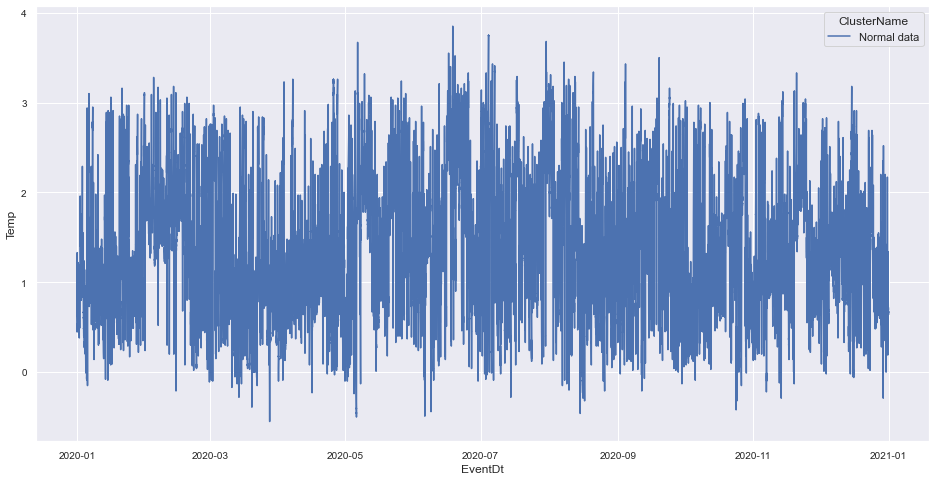

In [166]:
plt.figure(figsize=(16,8))
sns.lineplot(data= df_s_ThirdYear, x= df_s_ThirdYear.index, y='Temp', hue = 'ClusterName')

In [167]:
ourtlier2020_s = df_s_ThirdYear[df_s_ThirdYear['ClusterName'] == 'Outlier']
outlier2020count_s = len(ourtlier2020_s)
outlier2020count_s

0

### The Fourth Year of Df_S (2021)

In [168]:
df_s_FourthYear = df_s.dropna()
var = datetime(2021, 1, 1)
var2 = datetime(2022, 1, 1)
df_s_FourthYear = df_s_FourthYear[df_s_FourthYear.index > var]
df_s_FourthYear = df_s_FourthYear[df_s_FourthYear.index < var2]
df_s_FourthYear

Temp
EventDt                  
2021-01-01 00:05:00  0.65
2021-01-01 00:10:00  0.64
2021-01-01 00:15:00  0.65
2021-01-01 00:20:00  0.72
2021-01-01 00:25:00  0.77
...                   ...
2021-11-18 16:20:00  0.28
2021-11-18 16:25:00  0.27
2021-11-18 16:30:00  0.27
2021-11-18 16:35:00  0.24
2021-11-18 16:40:00  0.27

[92647 rows x 1 columns]

In [169]:
outliers = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
clusters = outliers.fit_predict(df_s_FourthYear)
df_s_FourthYear['Cluster'] = clusters
df_s_FourthYear

Temp  Cluster
EventDt                           
2021-01-01 00:05:00  0.65        0
2021-01-01 00:10:00  0.64        0
2021-01-01 00:15:00  0.65        0
2021-01-01 00:20:00  0.72        0
2021-01-01 00:25:00  0.77        0
...                   ...      ...
2021-11-18 16:20:00  0.28        0
2021-11-18 16:25:00  0.27        0
2021-11-18 16:30:00  0.27        0
2021-11-18 16:35:00  0.24        0
2021-11-18 16:40:00  0.27        0

[92647 rows x 2 columns]

In [170]:
df_s_FourthYear['ClusterName'] = df_s_FourthYear['Cluster'].map({0: "Normal data", -1: "Outlier"})
df_s_FourthYear

Temp  Cluster  ClusterName
EventDt                                        
2021-01-01 00:05:00  0.65        0  Normal data
2021-01-01 00:10:00  0.64        0  Normal data
2021-01-01 00:15:00  0.65        0  Normal data
2021-01-01 00:20:00  0.72        0  Normal data
2021-01-01 00:25:00  0.77        0  Normal data
...                   ...      ...          ...
2021-11-18 16:20:00  0.28        0  Normal data
2021-11-18 16:25:00  0.27        0  Normal data
2021-11-18 16:30:00  0.27        0  Normal data
2021-11-18 16:35:00  0.24        0  Normal data
2021-11-18 16:40:00  0.27        0  Normal data

[92647 rows x 3 columns]

<AxesSubplot:xlabel='EventDt', ylabel='Temp'>

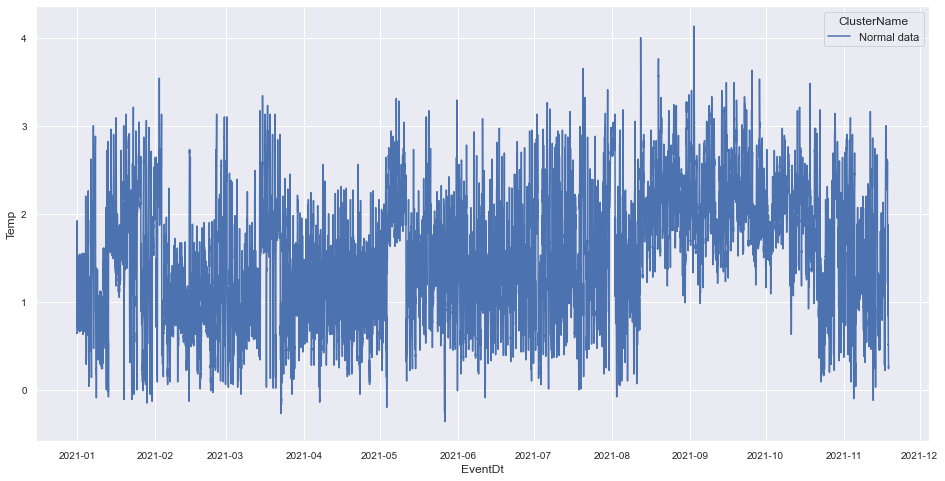

In [171]:
plt.figure(figsize=(16,8))
sns.lineplot(data= df_s_FourthYear, x= df_s_FourthYear.index, y='Temp', hue = 'ClusterName')

In [172]:
ourtlier2021_s = df_s_FourthYear[df_s_FourthYear['ClusterName'] == 'Outlier']
outlier2021count_s = len(ourtlier2021_s)
outlier2021count_s

0

## Merge the Refrigerator (DF_S) Dataframe into One Dataframe

In [173]:
frames = [ourtlier2019_s, ourtlier2020_s, ourtlier2021_s]
result = pd.concat(frames)
allOutlieramount = len(result)

In [174]:
whole_data = [df_s_FirstYear, df_s_SecondYear, df_s_ThirdYear, df_s_FourthYear]
sum_data = pd.concat(whole_data)
sum_data

Temp  Cluster  ClusterName
EventDt                                        
2018-11-18 16:50:00  1.23        0  Normal data
2018-11-18 16:55:00  1.24        0  Normal data
2018-11-18 17:00:00  1.20        0  Normal data
2018-11-18 17:05:00  1.18        0  Normal data
2018-11-18 17:10:00  1.17        0  Normal data
...                   ...      ...          ...
2021-11-18 16:20:00  0.28        0  Normal data
2021-11-18 16:25:00  0.27        0  Normal data
2021-11-18 16:30:00  0.27        0  Normal data
2021-11-18 16:35:00  0.24        0  Normal data
2021-11-18 16:40:00  0.27        0  Normal data

[315637 rows x 3 columns]

## Checking the Percentage of the Outliers

It's crucial to determine how much the outliers contribute inside the device; aside from displaying them and then clustering them, it's also crucial to determine the percentage it takes for the entire device to determine whether it needs to be checked more closely or replaced, and so on.

In [175]:
allDataAmount = len(sum_data)

#finding the %
def percentage(part, whole):
  Percentage = 100 * int(part)/int(whole)
  return Percentage
percent = percentage(allOutlieramount,allDataAmount)
print(f'Percentage: {round(percent,2)} %')

Percentage: 0.0 %


# Analysis for Device I (Mapping)

## Seasonality Overview

From the plot below, we can see that on the first plot is showing the outliers from device I in each month, the second plot is showing the overview for the entire week, and lastly the third plot is showing us the overview for the whole day (24 Hours).

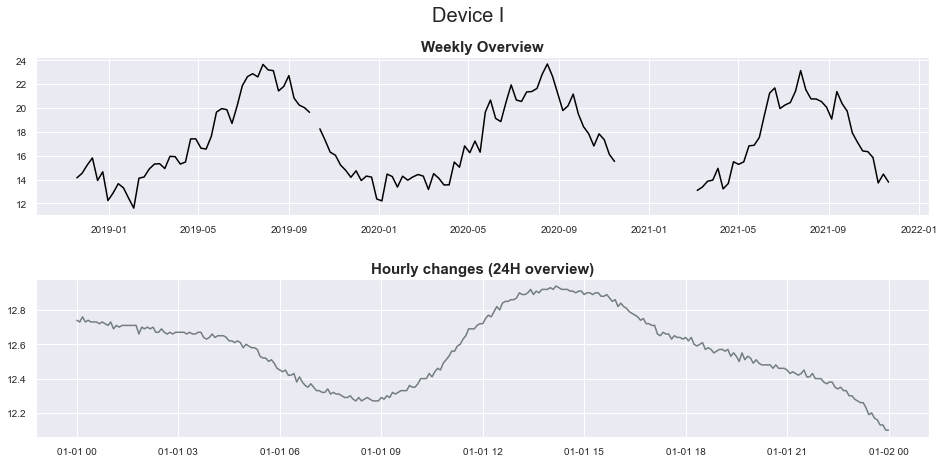

In [178]:
df_i_copy = df_i_daily.copy()
df_i_copy["Month"] = df_i_copy.index.to_period('M')

df_i_zoom = df_i.loc["2019-01-01 00:00:00":"2019-01-02 00:00:00"]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,7))
plt.subplots_adjust(hspace=0.4)
fig.suptitle('Device I',fontsize=20)
axes[0].plot(df_i_weekly,color='black' )
axes[1].plot(df_i_zoom,color='#717D7E')
axes[0].set_title('Weekly Overview', fontsize=15,fontweight='bold')
axes[1].set_title('Hourly changes (24H overview)', fontsize=15,fontweight='bold')

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)  
plt.show()

Based on the patterns, the evident gaps within a device can be noticed, then the sudden reduction over time in hourly changes, it is too soon to acknowledge anything, therefore a deeper look at the device is required.

## Monthly Examination
This will be a representation of the temperature view across the months in order to track the device's progress.

In [179]:
#copy the dataset
df_i_try=df_i.copy()
#convert dates variables into week, day and month
df_i_try["week"] = df_i_try.index.isocalendar().week
df_i_try["dayofmonth"] = df_i_try.index.day
df_i_try["month"] = df_i_try.index.month

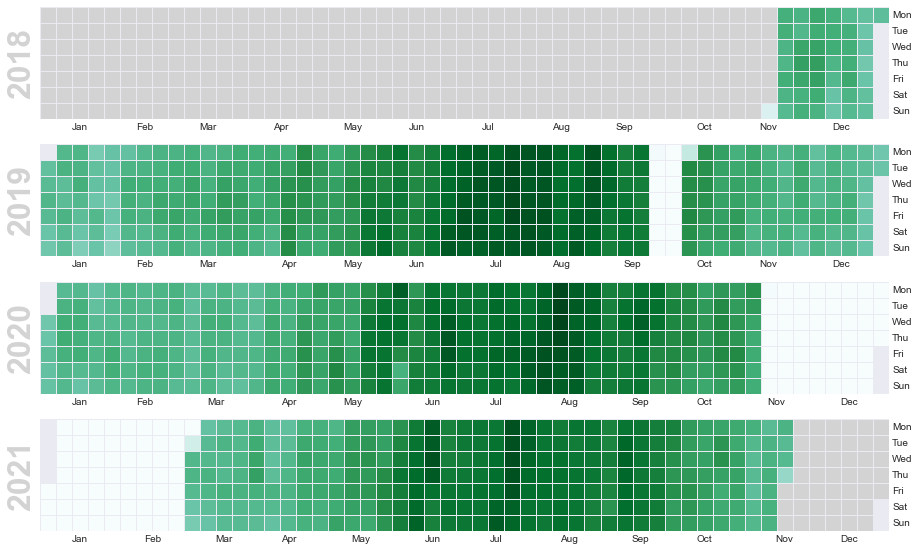

In [180]:
#visualise the heatmap with each month and each day of the week
fig, ax = calmap.calendarplot(df_i_try['Temp'],
                              fillcolor='lightgrey',
                              cmap='BuGn',
                              fig_kws={"figsize":(16,8)})

In comparison to previous devices, there is a clear gap between September and October in 2019, followed by a long gap between November 2020 and February 2021, which could indicate either the relocation of items or the replacement of the device, as there was previously a small gap that could indicate a battery strike. It's crucial to look at the pictures below to get a better understanding.

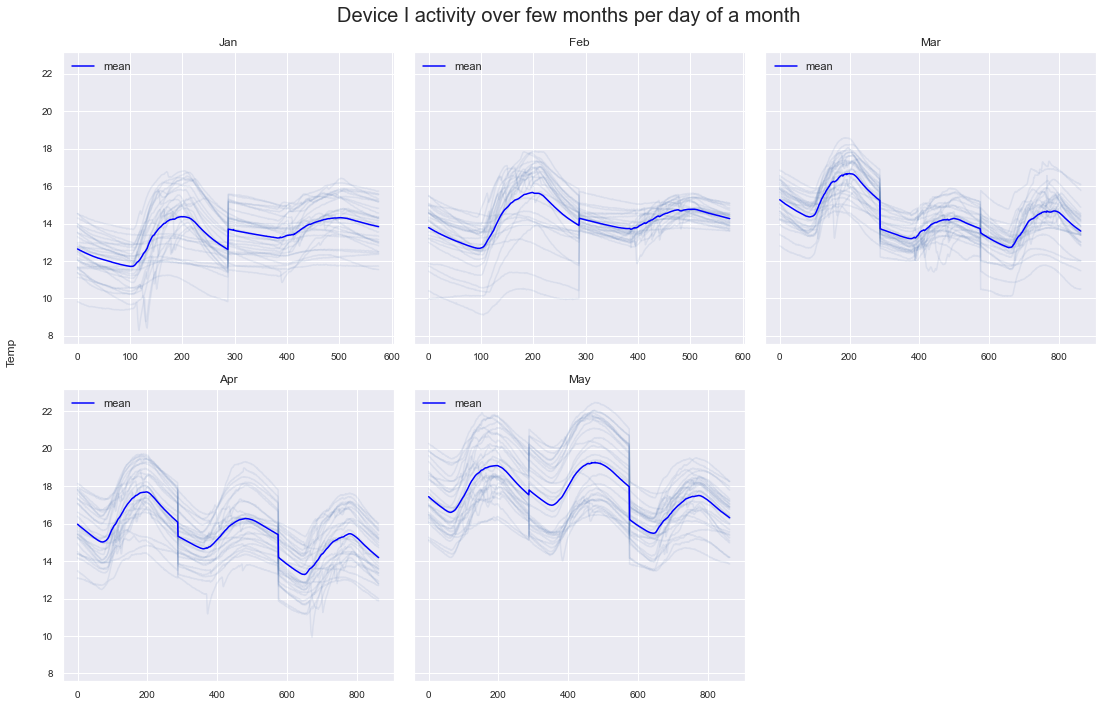

In [181]:
#plot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[15, 10], sharey=True)
fig.subplots_adjust(hspace=.5)
ax = ax.flatten()
sns_blue = sns.color_palette(as_cmap=True)
months = ["Jan", "Feb", "Mar", "Apr", "May"]
for z, month in enumerate(months):

    #origin
    daily_ts = []
    for _, ts in (
        df_i_try[["Temp", "dayofmonth", "month"]]
        .query(f"month == {z+1}") #next month
        .groupby("dayofmonth")
    ):
        daily_ts.append(ts.reset_index()["Temp"])
        ts.reset_index()["Temp"].plot(
            alpha=0.1, ax=ax[z], color=sns_blue, label="_no_legend_"
        )
        ax[z].set_title(month)

    #mean
    pd.concat(daily_ts, axis=1).mean(axis=1).plot(
        ax=ax[z], color="blue", label="mean", legend=True
    )
    ax[z].legend(loc="upper left", frameon=False)


fig.text(-0.02, 0.5, "Temp", va="center", rotation="vertical")
fig.suptitle("Device I activity over few months per day of a month",fontsize=20)
fig.delaxes(ax[-1])
fig.tight_layout()

It is noticeable that there has been a spike in the temperature range in May, and it has been extremely noticeable throughout each year that the sensor has been spiking in the temperature as it came to May and went through the summer. This is perplexing, and given the pattern has been consistent over time, it could indicate that there is heat emanating from the region itself. That's a reminder to look around the area as well, but keep a closer eye on the device for any gaps.

## Upper and Lower Limits

Upper and lower limits are taken from another dataset; for example, for device I, the upper limit is 25 and the bottom limit is 8; to show this, as well as the device's consistency through time, see the visual below.

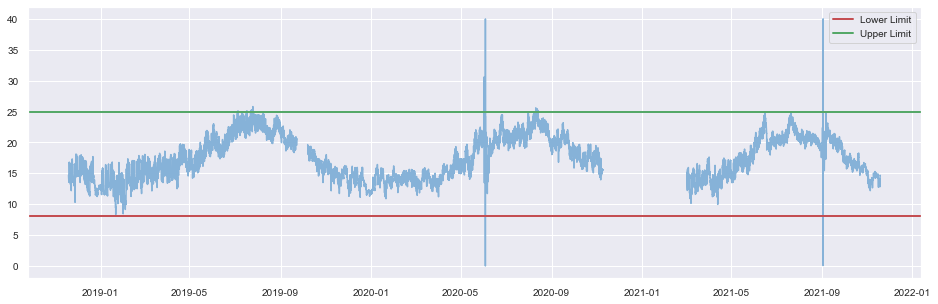

In [182]:
fig, axes = plt.subplots(1,1, figsize=(16,5))
plt.plot(df_i, color='#86b2d8')
plt.axhline(y=8,color='r',linestyle='-',label='Lower Limit',linewidth=2)
plt.axhline(y=25,color='g',linestyle='-',label='Upper Limit',linewidth=2)

plt.legend(prop={'size': 10})

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 

plt.show()

There are two key strickes that must be addressed before the prediction can be made, so oulier analysis, grouping, and elimination are used to prepare the data.

## Missing Data

In [183]:
df_i.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315648 entries, 2018-11-18 16:35:00 to 2021-11-18 16:30:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Temp    278713 non-null  float64
dtypes: float64(1)
memory usage: 12.9 MB


In [184]:
df_i.isna().sum()

Temp    36935
dtype: int64

<AxesSubplot:ylabel='EventDt'>

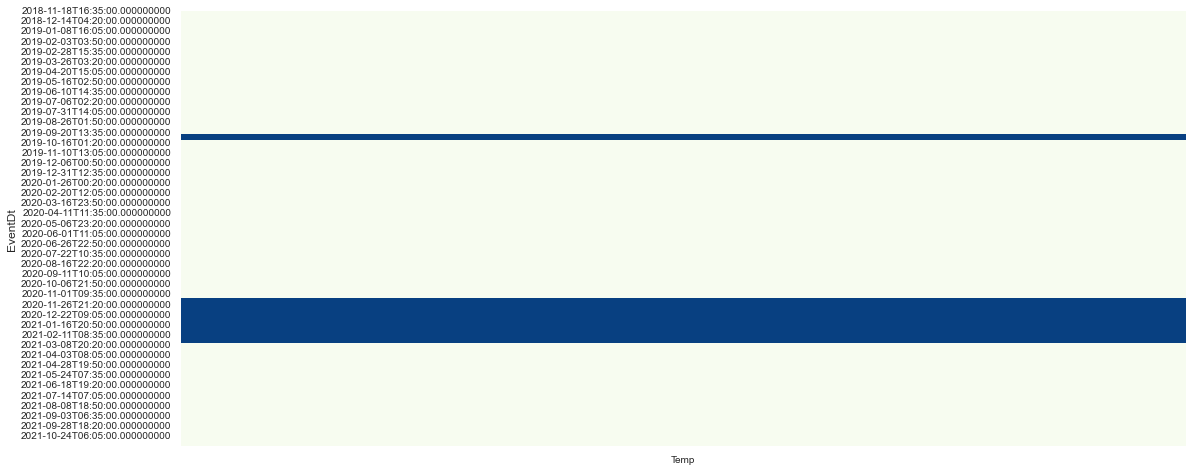

In [185]:
sns.heatmap(df_i.isnull(), cmap='GnBu', cbar=False)

In comparison to prior devices, this one has a lot more missing values, as can also be seen in the graphic above. If we put the analysis in and substitute missing data, it would hurt the models.

## Outliers Analyis

WARNING - (py.warnings._showwarnmsg) - C:\Users\shane\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)

WARNING - (py.warnings._showwarnmsg) - C:\Users\shane\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(



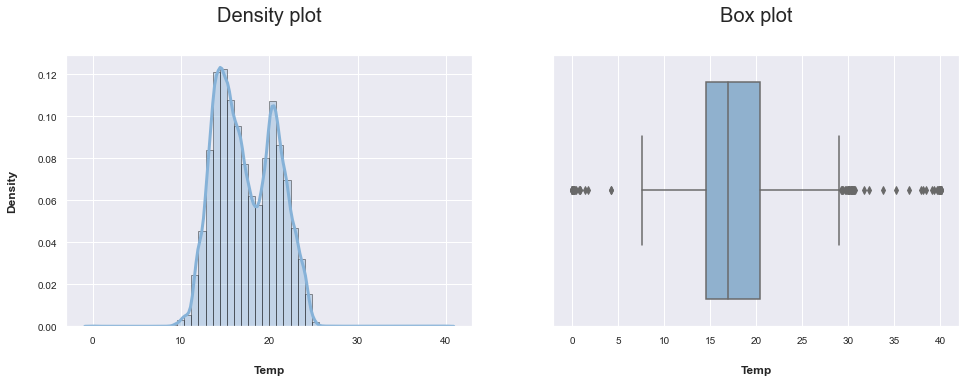

In [186]:
#desntiy plot
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df_i['Temp'],
             color='#86b2d8',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
plt.margins(0.05)

#extras
plt.title('Density plot',fontsize=20,y=1.1)
plt.ylabel('Density',fontweight='bold',labelpad=20)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

#box plot
plt.subplot(1,2,2)
sns.boxplot(df_i['Temp'],
             color='#86b2d8')
plt.margins(0.05)

#extras
plt.title('Box plot',fontsize=20,y=1.1)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

plt.show()

According to the density plot, the variable is responsible for two large spikes in the distribution, and the box plot has outliers on both sides; to clarify, the IQR method will be used.

In [187]:
#IQR method 
#Finding the IQR
per25_i = df_i['Temp'].quantile(0.25)
per75_i = df_i['Temp'].quantile(0.75)

#Finding the upper and lower limits
IQR_i=per75_i - per25_i
u_limit_i = per75_i + 1.5 * IQR_i
l_limit_i = per25_i - 1.5 * IQR_i

#Finding the outliers
trimed_df_i = df_i[df_i['Temp'] > u_limit_i]
df_i[df_i['Temp'] < l_limit_i] #figure out how to store both

#check results
trimed_df_i.sample(5)

Temp
EventDt                    
2020-06-03 14:10:00  35.208
2020-06-01 17:00:00  30.120
2020-06-01 15:55:00  30.150
2020-06-01 16:50:00  30.360
2020-06-01 15:50:00  30.030

It's useful to compare the same images with a trimmed dataset after elimination.

WARNING - (py.warnings._showwarnmsg) - C:\Users\shane\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)

WARNING - (py.warnings._showwarnmsg) - C:\Users\shane\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(



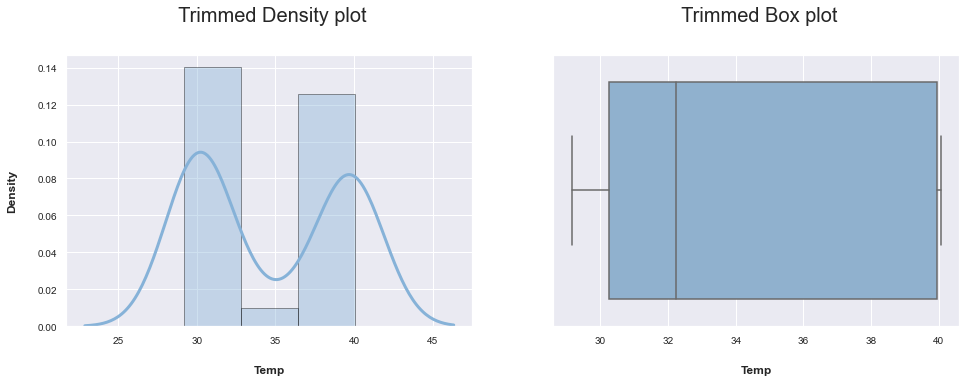

In [188]:
#desntiy plot
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(trimed_df_i['Temp'],
             color='#86b2d8',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
plt.margins(0.05)

#extras
plt.title(' Trimmed Density plot',fontsize=20,y=1.1)
plt.ylabel('Density',fontweight='bold',labelpad=20)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

#box plot
plt.subplot(1,2,2)
sns.boxplot(trimed_df_i['Temp'],
             color='#86b2d8')
plt.margins(0.05)

#extras
plt.title(' Trimmed Box plot',fontsize=20,y=1.1)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

plt.show()

It is visible as a clear focus on the upper limit of the data after trimming, but to eliminate it and also intarigate the lower limit, it is useful to apply capping and compare the visuals for the subsequent phases.

In [191]:
# an option to resolve outlier for like a final is to use capping
cap_df_i = df_i.copy()
#use a method for upper and lower limits
cap_df_i ['Temp'] = np.where(
   cap_df_i ['Temp'] > u_limit_i,
    u_limit_i,
    np.where(
        cap_df_i ['Temp'] < l_limit_i,
        l_limit_i,
        cap_df_i ['Temp']
    )
)

WARNING - (py.warnings._showwarnmsg) - C:\Users\shane\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)

WARNING - (py.warnings._showwarnmsg) - C:\Users\shane\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(



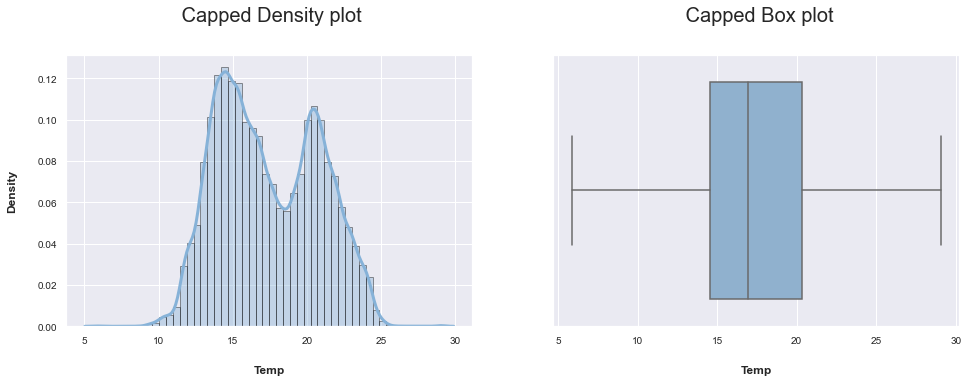

In [192]:
#visualise the capping as a final result
#desntiy plot
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(cap_df_i['Temp'],
             color='#86b2d8',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
plt.margins(0.05)

#extras
plt.title(' Capped Density plot',fontsize=20,y=1.1)
plt.ylabel('Density',fontweight='bold',labelpad=20)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

#box plot
plt.subplot(1,2,2)
sns.boxplot(cap_df_i ['Temp'],
             color='#86b2d8')
plt.margins(0.05)

#extras
plt.title(' Capped Box plot',fontsize=20,y=1.1)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

plt.show()

After capping the outliers, it's evident that the values are now just right, but in order to approach it in the model, clustering and outlier elimination are required to continue further.

## Clustering the Outliers

Here we're going to figure out the outliers, to be able to get a closer analysis we're going to split the Mapping (df_i) by year.

### The First Year of Df_I (2018)

In [193]:
df_i_FirstYear = df_i.dropna()
var = datetime(2019, 1, 1)
df_i_FirstYear = df_i_FirstYear[df_i_FirstYear.index < var]
df_i_FirstYear

Temp
EventDt                   
2018-11-18 16:35:00  14.60
2018-11-18 16:40:00  14.63
2018-11-18 16:45:00  14.60
2018-11-18 16:50:00  14.57
2018-11-18 16:55:00  14.59
...                    ...
2018-12-31 23:35:00  12.75
2018-12-31 23:40:00  12.77
2018-12-31 23:45:00  12.75
2018-12-31 23:50:00  12.76
2018-12-31 23:55:00  12.75

[12473 rows x 1 columns]

In [194]:
outliers = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
clusters = outliers.fit_predict(df_i_FirstYear)
df_i_FirstYear['Cluster'] = clusters
df_i_FirstYear

Temp  Cluster
EventDt                            
2018-11-18 16:35:00  14.60        0
2018-11-18 16:40:00  14.63        0
2018-11-18 16:45:00  14.60        0
2018-11-18 16:50:00  14.57        0
2018-11-18 16:55:00  14.59        0
...                    ...      ...
2018-12-31 23:35:00  12.75        0
2018-12-31 23:40:00  12.77        0
2018-12-31 23:45:00  12.75        0
2018-12-31 23:50:00  12.76        0
2018-12-31 23:55:00  12.75        0

[12473 rows x 2 columns]

In [195]:
df_i_FirstYear['ClusterName'] = df_i_FirstYear['Cluster'].map({0: "Normal data", -1: "Outlier"})
df_i_FirstYear

Temp  Cluster  ClusterName
EventDt                                         
2018-11-18 16:35:00  14.60        0  Normal data
2018-11-18 16:40:00  14.63        0  Normal data
2018-11-18 16:45:00  14.60        0  Normal data
2018-11-18 16:50:00  14.57        0  Normal data
2018-11-18 16:55:00  14.59        0  Normal data
...                    ...      ...          ...
2018-12-31 23:35:00  12.75        0  Normal data
2018-12-31 23:40:00  12.77        0  Normal data
2018-12-31 23:45:00  12.75        0  Normal data
2018-12-31 23:50:00  12.76        0  Normal data
2018-12-31 23:55:00  12.75        0  Normal data

[12473 rows x 3 columns]

<AxesSubplot:xlabel='EventDt', ylabel='Temp'>

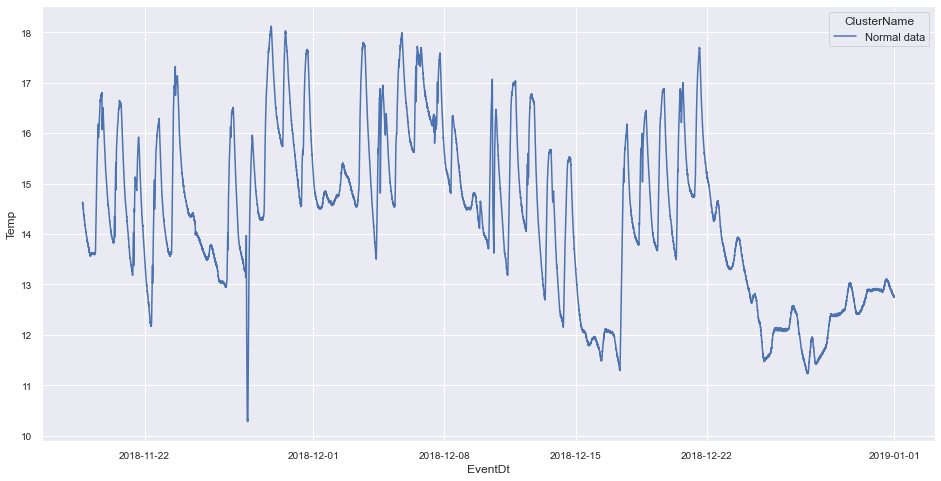

In [196]:
plt.figure(figsize=(16,8))
sns.lineplot(data= df_i_FirstYear, x= df_i_FirstYear.index, y='Temp', hue = 'ClusterName')

In [197]:
ourtlier2018_i = df_i_FirstYear[df_i_FirstYear['ClusterName'] == 'Outlier']
outlier2018count_i = len(ourtlier2018_i)
outlier2018count_i

0

### The Second Year of Df_I (2019)

In [198]:
df_i_SecondYear = df_i.dropna()
var = datetime(2019, 1, 1)
var2 = datetime(2020, 1, 1)
df_i_SecondYear = df_i_SecondYear[df_i_SecondYear.index > var]
df_i_SecondYear = df_i_SecondYear[df_i_SecondYear.index < var2]
df_i_SecondYear

Temp
EventDt                   
2019-01-01 00:05:00  12.73
2019-01-01 00:10:00  12.76
2019-01-01 00:15:00  12.73
2019-01-01 00:20:00  12.74
2019-01-01 00:25:00  12.73
...                    ...
2019-12-31 23:35:00  11.96
2019-12-31 23:40:00  11.92
2019-12-31 23:45:00  11.92
2019-12-31 23:50:00  11.92
2019-12-31 23:55:00  11.90

[100905 rows x 1 columns]

In [199]:
outliers = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
clusters = outliers.fit_predict(df_i_SecondYear)
df_i_SecondYear['Cluster'] = clusters
df_i_SecondYear

Temp  Cluster
EventDt                            
2019-01-01 00:05:00  12.73        0
2019-01-01 00:10:00  12.76        0
2019-01-01 00:15:00  12.73        0
2019-01-01 00:20:00  12.74        0
2019-01-01 00:25:00  12.73        0
...                    ...      ...
2019-12-31 23:35:00  11.96        0
2019-12-31 23:40:00  11.92        0
2019-12-31 23:45:00  11.92        0
2019-12-31 23:50:00  11.92        0
2019-12-31 23:55:00  11.90        0

[100905 rows x 2 columns]

In [200]:
df_i_SecondYear['ClusterName'] = df_i_SecondYear['Cluster'].map({0: "Normal data", -1: "Outlier"})
df_i_SecondYear

Temp  Cluster  ClusterName
EventDt                                         
2019-01-01 00:05:00  12.73        0  Normal data
2019-01-01 00:10:00  12.76        0  Normal data
2019-01-01 00:15:00  12.73        0  Normal data
2019-01-01 00:20:00  12.74        0  Normal data
2019-01-01 00:25:00  12.73        0  Normal data
...                    ...      ...          ...
2019-12-31 23:35:00  11.96        0  Normal data
2019-12-31 23:40:00  11.92        0  Normal data
2019-12-31 23:45:00  11.92        0  Normal data
2019-12-31 23:50:00  11.92        0  Normal data
2019-12-31 23:55:00  11.90        0  Normal data

[100905 rows x 3 columns]

<AxesSubplot:xlabel='EventDt', ylabel='Temp'>

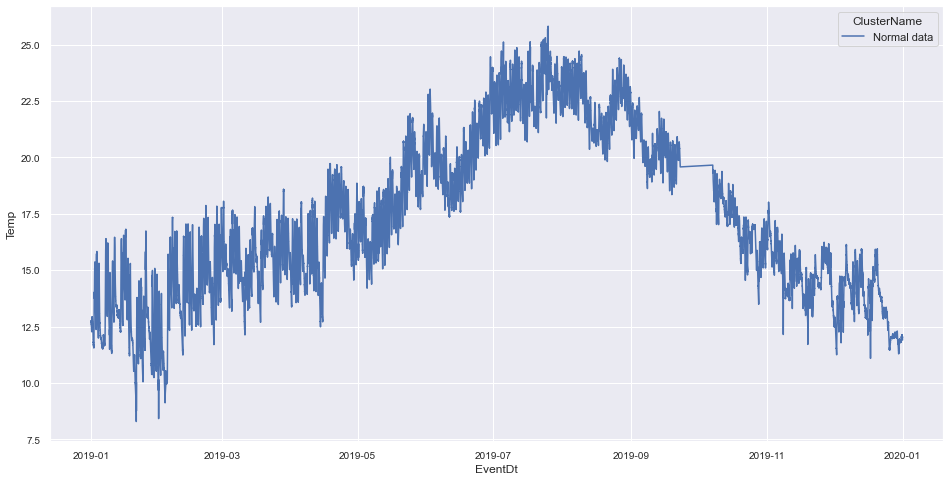

In [201]:
plt.figure(figsize=(16,8))
sns.lineplot(data= df_i_SecondYear, x= df_i_SecondYear.index, y='Temp', hue = 'ClusterName')

In [202]:
ourtlier2019_i = df_i_SecondYear[df_i_SecondYear['ClusterName'] == 'Outlier']
outlier2019count_i = len(ourtlier2019_i)
outlier2019count_i

0

### The Third Year of Df_I (2020)

In [203]:
df_i_ThirdYear = df_i.dropna()
var = datetime(2020, 1, 1)
var2 = datetime(2021, 1, 1)
df_i_ThirdYear = df_i_ThirdYear[df_i_ThirdYear.index > var]
df_i_ThirdYear = df_i_ThirdYear[df_i_ThirdYear.index < var2]
df_i_ThirdYear

Temp
EventDt                   
2020-01-01 00:05:00  11.89
2020-01-01 00:10:00  11.89
2020-01-01 00:15:00  11.87
2020-01-01 00:20:00  11.87
2020-01-01 00:25:00  11.84
...                    ...
2020-11-09 00:25:00  15.52
2020-11-09 00:30:00  15.51
2020-11-09 00:35:00  15.51
2020-11-09 00:40:00  15.48
2020-11-09 00:45:00  15.51

[90141 rows x 1 columns]

In [204]:
outliers = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
clusters = outliers.fit_predict(df_i_ThirdYear)
df_i_ThirdYear['Cluster'] = clusters
df_i_ThirdYear

Temp  Cluster
EventDt                            
2020-01-01 00:05:00  11.89        0
2020-01-01 00:10:00  11.89        0
2020-01-01 00:15:00  11.87        0
2020-01-01 00:20:00  11.87        0
2020-01-01 00:25:00  11.84        0
...                    ...      ...
2020-11-09 00:25:00  15.52        0
2020-11-09 00:30:00  15.51        0
2020-11-09 00:35:00  15.51        0
2020-11-09 00:40:00  15.48        0
2020-11-09 00:45:00  15.51        0

[90141 rows x 2 columns]

In [205]:
df_i_ThirdYear['ClusterName'] = df_i_ThirdYear['Cluster'].map({0: "Normal data", -1: "Outlier"})
df_i_ThirdYear

Temp  Cluster  ClusterName
EventDt                                         
2020-01-01 00:05:00  11.89        0  Normal data
2020-01-01 00:10:00  11.89        0  Normal data
2020-01-01 00:15:00  11.87        0  Normal data
2020-01-01 00:20:00  11.87        0  Normal data
2020-01-01 00:25:00  11.84        0  Normal data
...                    ...      ...          ...
2020-11-09 00:25:00  15.52        0  Normal data
2020-11-09 00:30:00  15.51        0  Normal data
2020-11-09 00:35:00  15.51        0  Normal data
2020-11-09 00:40:00  15.48        0  Normal data
2020-11-09 00:45:00  15.51        0  Normal data

[90141 rows x 3 columns]

<AxesSubplot:xlabel='EventDt', ylabel='Temp'>

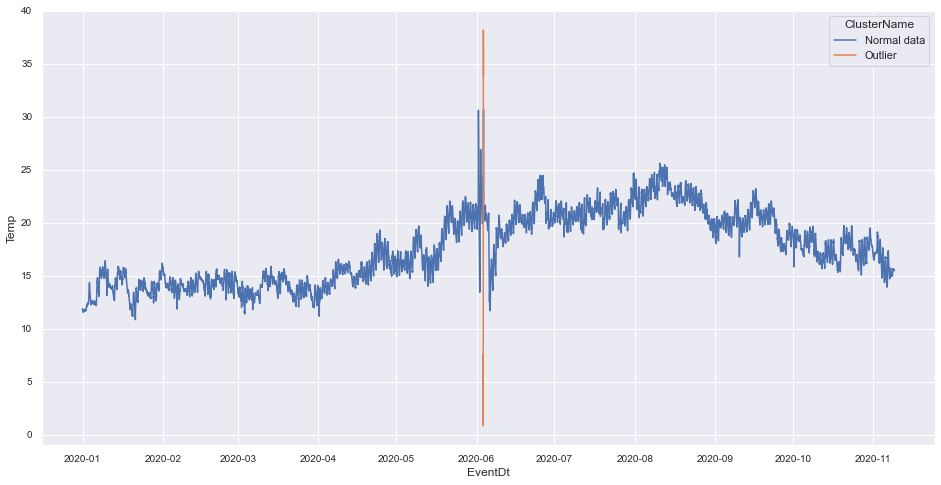

In [206]:
plt.figure(figsize=(16,8))
sns.lineplot(data= df_i_ThirdYear, x= df_i_ThirdYear.index, y='Temp', hue = 'ClusterName')

In [207]:
ourtlier2020_i = df_i_ThirdYear[df_i_ThirdYear['ClusterName'] == 'Outlier']
outlier2020count_i = len(ourtlier2020_i)
outlier2020count_i

6

### The Fourth Year of Df_I (2021)

In [208]:
df_i_FourthYear = df_i.dropna()
var = datetime(2021, 1, 1)
var2 = datetime(2022, 1, 1)
df_i_FourthYear = df_i_FourthYear[df_i_FourthYear.index > var]
df_i_FourthYear = df_i_FourthYear[df_i_FourthYear.index < var2]
df_i_FourthYear

Temp
EventDt                   
2021-03-02 14:30:00  15.10
2021-03-02 14:35:00  15.13
2021-03-02 14:40:00  15.13
2021-03-02 14:45:00  15.18
2021-03-02 14:50:00  15.16
...                    ...
2021-11-18 16:10:00  14.65
2021-11-18 16:15:00  14.66
2021-11-18 16:20:00  14.64
2021-11-18 16:25:00  14.65
2021-11-18 16:30:00  14.64

[75192 rows x 1 columns]

In [209]:
outliers = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
clusters = outliers.fit_predict(df_i_FourthYear)
df_i_FourthYear['Cluster'] = clusters
df_i_FourthYear

Temp  Cluster
EventDt                            
2021-03-02 14:30:00  15.10        0
2021-03-02 14:35:00  15.13        0
2021-03-02 14:40:00  15.13        0
2021-03-02 14:45:00  15.18        0
2021-03-02 14:50:00  15.16        0
...                    ...      ...
2021-11-18 16:10:00  14.65        0
2021-11-18 16:15:00  14.66        0
2021-11-18 16:20:00  14.64        0
2021-11-18 16:25:00  14.65        0
2021-11-18 16:30:00  14.64        0

[75192 rows x 2 columns]

In [210]:
df_i_FourthYear['ClusterName'] = df_i_FourthYear['Cluster'].map({0: "Normal data", -1: "Outlier"})
df_i_FourthYear

Temp  Cluster  ClusterName
EventDt                                         
2021-03-02 14:30:00  15.10        0  Normal data
2021-03-02 14:35:00  15.13        0  Normal data
2021-03-02 14:40:00  15.13        0  Normal data
2021-03-02 14:45:00  15.18        0  Normal data
2021-03-02 14:50:00  15.16        0  Normal data
...                    ...      ...          ...
2021-11-18 16:10:00  14.65        0  Normal data
2021-11-18 16:15:00  14.66        0  Normal data
2021-11-18 16:20:00  14.64        0  Normal data
2021-11-18 16:25:00  14.65        0  Normal data
2021-11-18 16:30:00  14.64        0  Normal data

[75192 rows x 3 columns]

<AxesSubplot:xlabel='EventDt', ylabel='Temp'>

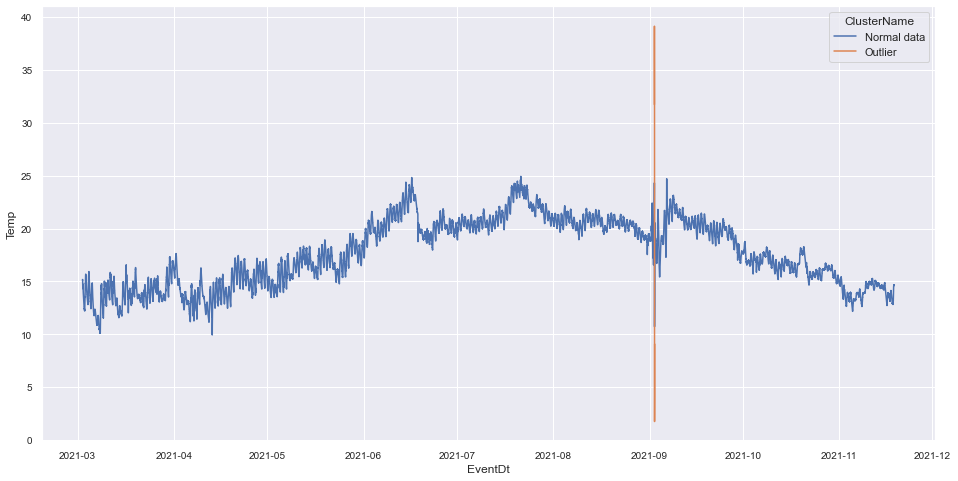

In [211]:
plt.figure(figsize=(16,8))
sns.lineplot(data= df_i_FourthYear, x= df_i_FourthYear.index, y='Temp', hue = 'ClusterName')

In [212]:
ourtlier2021_i = df_i_FourthYear[df_i_FourthYear['ClusterName'] == 'Outlier']
outlier2021count_i = len(ourtlier2021_i)
outlier2021count_i

10

## Merge the DF_I Dataframe into One Dataframe

In [213]:
frames = [ourtlier2019_i, ourtlier2020_i, ourtlier2021_i]
result = pd.concat(frames)
allOutlieramount = len(result)

In [214]:
whole_data = [df_i_FirstYear, df_i_SecondYear, df_i_ThirdYear, df_i_FourthYear]
sum_data = pd.concat(whole_data)
sum_data

Temp  Cluster  ClusterName
EventDt                                         
2018-11-18 16:35:00  14.60        0  Normal data
2018-11-18 16:40:00  14.63        0  Normal data
2018-11-18 16:45:00  14.60        0  Normal data
2018-11-18 16:50:00  14.57        0  Normal data
2018-11-18 16:55:00  14.59        0  Normal data
...                    ...      ...          ...
2021-11-18 16:10:00  14.65        0  Normal data
2021-11-18 16:15:00  14.66        0  Normal data
2021-11-18 16:20:00  14.64        0  Normal data
2021-11-18 16:25:00  14.65        0  Normal data
2021-11-18 16:30:00  14.64        0  Normal data

[278711 rows x 3 columns]

## Checking the Percentage of the Outliers

It's crucial to determine how much the outliers contribute inside the device; aside from displaying them and then clustering them, it's also crucial to determine the percentage it takes for the entire device to determine whether it needs to be checked more closely or replaced, and so on.

In [215]:
allDataAmount = len(sum_data)

#finding the %
def percentage(part, whole):
  Percentage = 100 * int(part)/int(whole)
  return Percentage
percent = percentage(allOutlieramount,allDataAmount)
print(f'Percentage: {round(percent,2)} %')

Percentage: 0.01 %


## Removing the Outliers

In [216]:
drop_Outliers_dfI = sum_data.drop(index = result.index)
drop_Outliers_dfI

Temp  Cluster  ClusterName
EventDt                                         
2018-11-18 16:35:00  14.60        0  Normal data
2018-11-18 16:40:00  14.63        0  Normal data
2018-11-18 16:45:00  14.60        0  Normal data
2018-11-18 16:50:00  14.57        0  Normal data
2018-11-18 16:55:00  14.59        0  Normal data
...                    ...      ...          ...
2021-11-18 16:10:00  14.65        0  Normal data
2021-11-18 16:15:00  14.66        0  Normal data
2021-11-18 16:20:00  14.64        0  Normal data
2021-11-18 16:25:00  14.65        0  Normal data
2021-11-18 16:30:00  14.64        0  Normal data

[278695 rows x 3 columns]

<AxesSubplot:xlabel='EventDt', ylabel='Temp'>

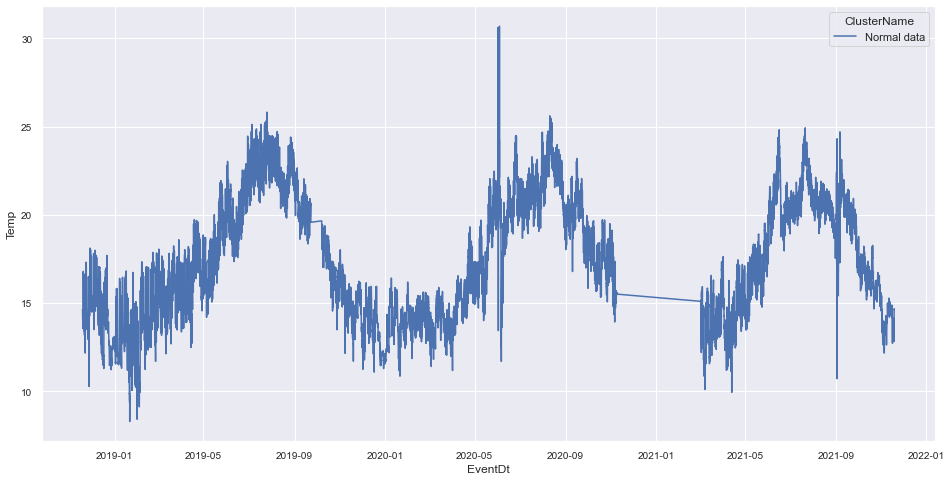

In [217]:
plt.figure(figsize=(16,8))
sns.lineplot(data= drop_Outliers_dfI, color='#C0D6EA', x= drop_Outliers_dfI.index, y='Temp', hue = 'ClusterName')

# Analysis for Device D (Storage)

## Seasonality Overview

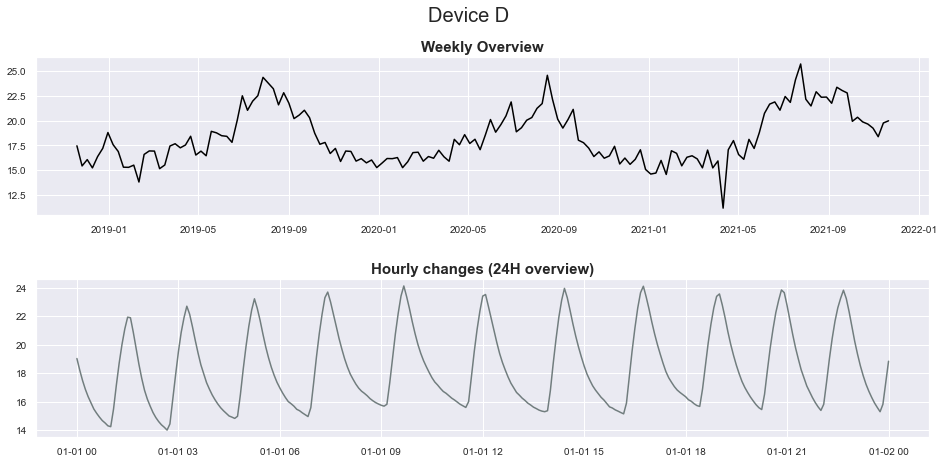

In [218]:
df_d_copy = df_d_daily.copy()
df_d_copy["Month"] = df_d_copy.index.to_period('M')

df_d_zoom = df_d.loc["2019-01-01 00:00:00":"2019-01-02 00:00:00"]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,7))
plt.subplots_adjust(hspace=0.4)
fig.suptitle('Device D',fontsize=20)
axes[0].plot(df_d_weekly,color='black' )
axes[1].plot(df_d_zoom,color='#717D7E')
axes[0].set_title('Weekly Overview', fontsize=15,fontweight='bold')
axes[1].set_title('Hourly changes (24H overview)', fontsize=15,fontweight='bold')

plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)  
plt.show()

The high pitch dips in three aspects may be noticed throughout such a pattern, followed by a regular distribution over hourly. This is a fascinating conclusion, but it is needed to examine at it more closely to understand it better.

## Monthly Examination
This will be a representation of the temperature view across the months in order to track the device's progress.

In [219]:
#copy the dataset
df_d_try=df_d.copy()
#convert dates variables into week, day and month
df_d_try["week"] = df_d_try.index.isocalendar().week
df_d_try["dayofmonth"] = df_d_try.index.day
df_d_try["month"] = df_d_try.index.month

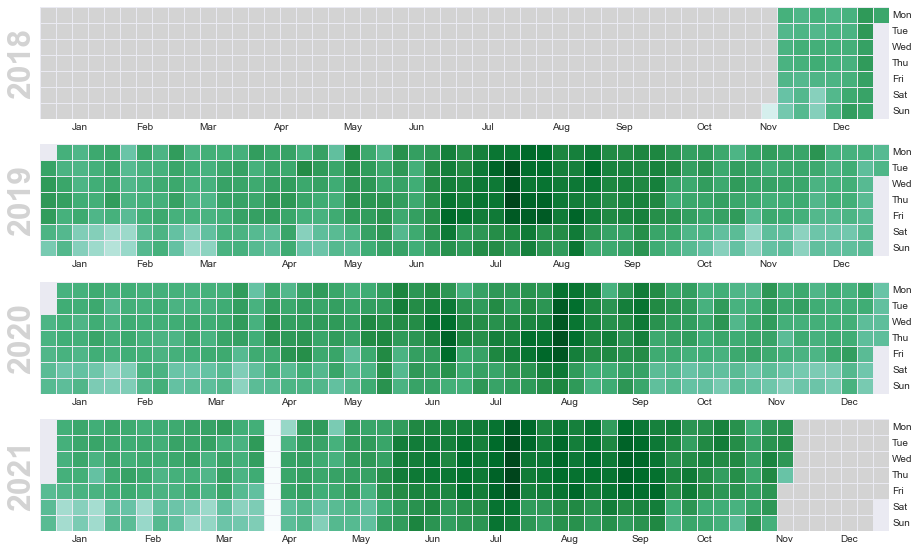

In [220]:
#visualise the heatmap with each month and each day of the week
fig, ax = calmap.calendarplot(df_d_try['Temp'],
                              fillcolor='lightgrey',
                              cmap='BuGn',
                              fig_kws={"figsize":(16,8)})

There are a few dark areas around the years, but there is also a one-week break in 2021; this is an intriguing allocation; it may be the checks on things or the replacement of a batery, as in the prior example.

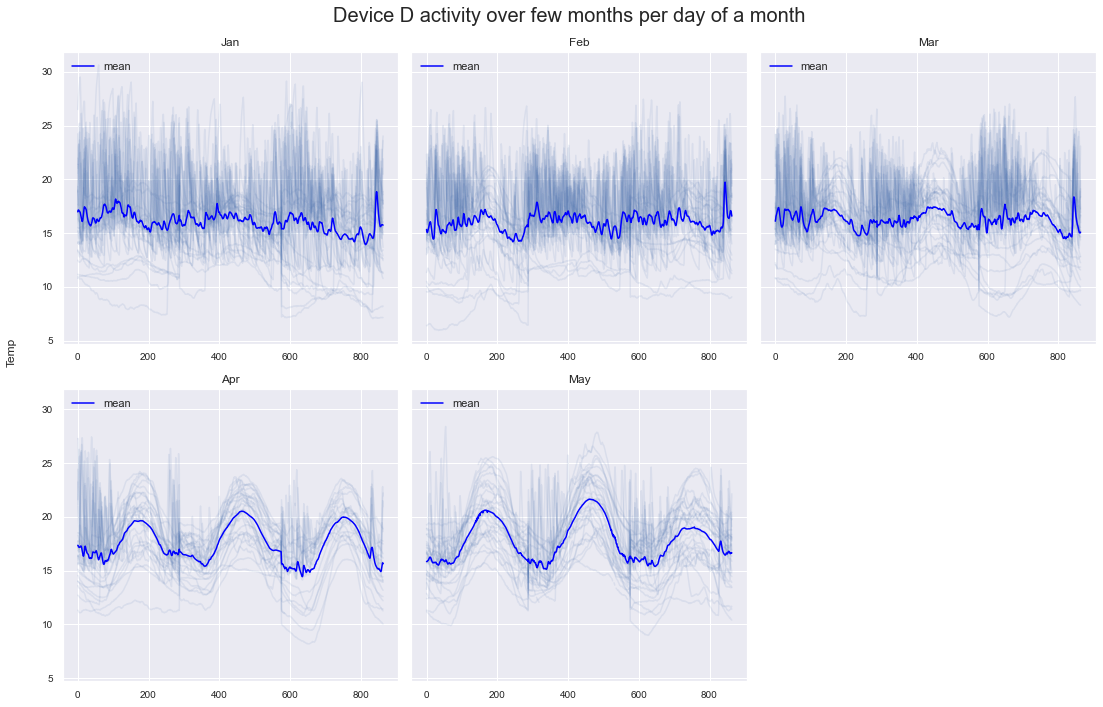

In [221]:
#plot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=[15, 10], sharey=True)
fig.subplots_adjust(hspace=.5)
ax = ax.flatten()
sns_blue = sns.color_palette(as_cmap=True)[0]
months = ["Jan", "Feb", "Mar", "Apr", "May"]
for q, month in enumerate(months):

    #origin
    daily_ts = []
    for _, ts in (
        df_d_try[["Temp", "dayofmonth", "month"]]
        .query(f"month == {q+1}") #next month
        .groupby("dayofmonth")
    ):
        daily_ts.append(ts.reset_index()["Temp"])
        ts.reset_index()["Temp"].plot(
            alpha=0.1, ax=ax[q], color=sns_blue, label="_no_legend_"
        )
        ax[q].set_title(month)

    #mean
    pd.concat(daily_ts, axis=1).mean(axis=1).plot(
        ax=ax[q], color="blue", label="mean", legend=True
    )
    ax[q].legend(loc="upper left", frameon=False)


fig.text(-0.02, 0.5, "Temp", va="center", rotation="vertical")
fig.suptitle("Device D activity over few months per day of a month",fontsize=20)
fig.delaxes(ax[-1])
fig.tight_layout()

Closer to spring and summer, the device had fewer temperature occurrences throughout the time displayed, but there were spikes in the temperature for the summer period, similar to the above one, and there was a break in between for likely batery switch or are movement. However, after the possible transition, it can be observed that, despite the three big spikes, the device remained quite consistent and held on to it.

## Missing Data

In [222]:
df_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315648 entries, 2018-11-18 16:15:00 to 2021-11-18 16:10:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Temp    313427 non-null  float64
dtypes: float64(1)
memory usage: 12.9 MB


In [223]:
df_d.isna().sum()

Temp    2221
dtype: int64

<AxesSubplot:ylabel='EventDt'>

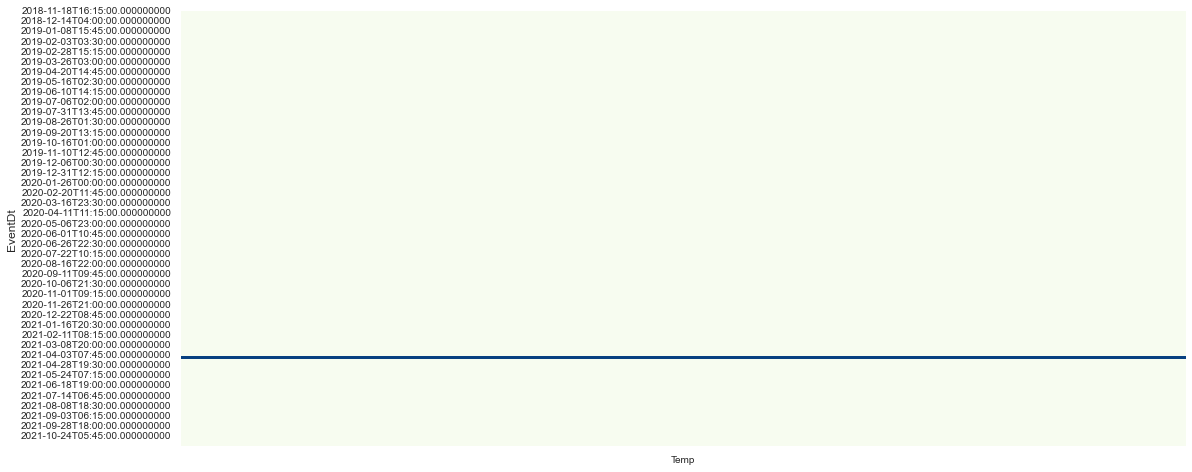

In [224]:
sns.heatmap(df_d.isnull(),cmap='GnBu', cbar=False)

As can be observed, device D has fewer missing data than device I, but there are still a handful that can impact the model further. Because this device has no limitations, it will be utilized to set boundaries based on outlier analysis.

## Outliers Analyis

WARNING - (py.warnings._showwarnmsg) - C:\Users\shane\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)

WARNING - (py.warnings._showwarnmsg) - C:\Users\shane\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(



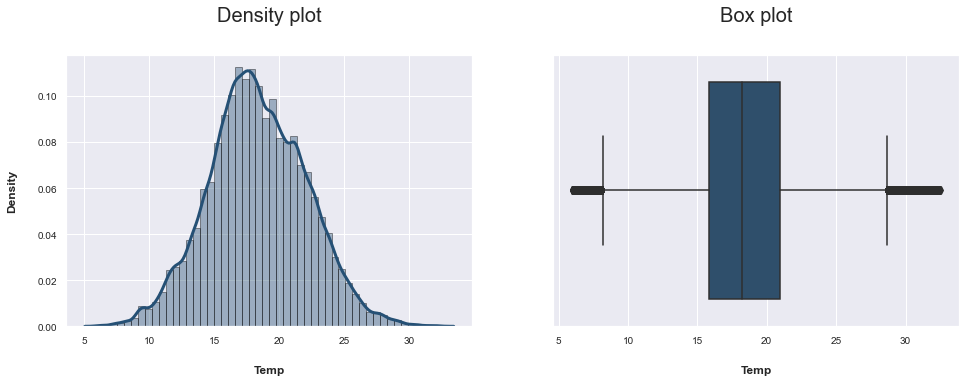

In [225]:
#desntiy plot
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(df_d['Temp'],
             color='#255075',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
plt.margins(0.05)
#255075
#extras
plt.title('Density plot',fontsize=20,y=1.1)
plt.ylabel('Density',fontweight='bold',labelpad=20)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

#box plot
plt.subplot(1,2,2)
sns.boxplot(df_d['Temp'],
             color='#255075')
plt.margins(0.05)

#extras
plt.title('Box plot',fontsize=20,y=1.1)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

plt.show()

It's a densely distributed density plot, but it's also clear in a boxplot that this device has a lot of them, and the next step will be to evaluate the borders to help limit them in the future.

In [226]:
#IQR method 
#Finding the IQR
per25_d = df_d['Temp'].quantile(0.25)
per75_d = df_d['Temp'].quantile(0.75)

#Finding the upper and lower limits
IQR_d=per75_d-per25_d
u_limit_d = per75_d + 1.5 * IQR_d
l_limit_d = per25_d - 1.5 * IQR_d

#Finding the outliers
trimed_df_d = df_d[df_d['Temp'] > u_limit_d]
df_d[df_d['Temp'] < l_limit_d] #check upon fixing this 

#check results
trimed_df_d.sample(5)

Temp
EventDt                   
2021-07-23 15:40:00  30.31
2021-07-23 15:50:00  30.31
2019-07-26 12:50:00  28.89
2020-08-13 12:50:00  29.11
2021-07-22 15:55:00  31.25

After trimming, it's crucial to visualize the top limit to see the difference between the previous phase and then proceed.

WARNING - (py.warnings._showwarnmsg) - C:\Users\shane\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)

WARNING - (py.warnings._showwarnmsg) - C:\Users\shane\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(



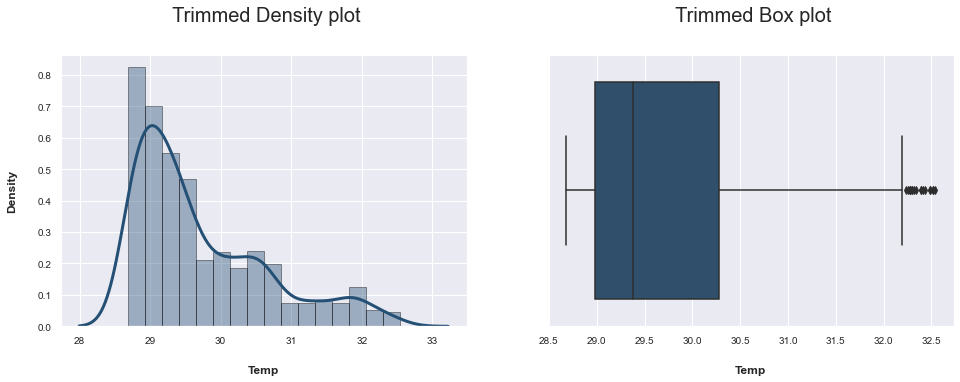

In [227]:
#desntiy plot
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(trimed_df_d['Temp'],
             color='#255075',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
plt.margins(0.05)

#extras
plt.title(' Trimmed Density plot',fontsize=20,y=1.1)
plt.ylabel('Density',fontweight='bold',labelpad=20)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

#box plot
plt.subplot(1,2,2)
sns.boxplot(trimed_df_d['Temp'],
             color='#255075')
plt.margins(0.05)

#extras
plt.title(' Trimmed Box plot',fontsize=20,y=1.1)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

plt.show()

Despite the fact that there are some outliers to account for, the density is clearly approaching the left side and subsequently decreasing on the right, capping is useful to include the lower limits.

In [229]:
# an option to resolve outlier for like a final is to use capping
cap_df_d = df_d.copy()
#use a method for upper and lower limits
cap_df_d ['Temp'] = np.where(
   cap_df_d ['Temp'] > u_limit_d,
    u_limit_d,
    np.where(
        cap_df_d ['Temp'] < l_limit_d,
        l_limit_d,
        cap_df_d ['Temp']
    )
)

WARNING - (py.warnings._showwarnmsg) - C:\Users\shane\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)

WARNING - (py.warnings._showwarnmsg) - C:\Users\shane\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(



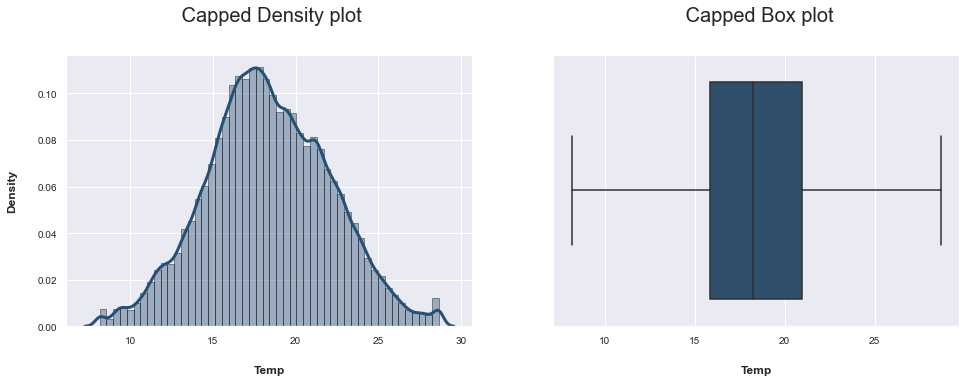

In [230]:
#visualise the capping as a final result
#desntiy plot
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(cap_df_d['Temp'],
             color='#255075',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
plt.margins(0.05)

#extras
plt.title(' Capped Density plot',fontsize=20,y=1.1)
plt.ylabel('Density',fontweight='bold',labelpad=20)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

#box plot
plt.subplot(1,2,2)
sns.boxplot(cap_df_d ['Temp'],
             color='#255075')
plt.margins(0.05)

#extras
plt.title(' Capped Box plot',fontsize=20,y=1.1)
plt.xlabel('Temp',fontweight='bold',labelpad=20)

plt.show()

The desnity is obvious and powerful, with almost equal skewing, but it is not the final stage in this research; clustering and outlier removal are required to prepare the data.

## Clustering the Outliers

Here we're going to figure out the outliers, to be able to get a closer analysis we're going to split the Storage (df_d) by year.

### The First Year of Df_D (2018)

In [231]:
df_d_FirstYear = df_d.dropna()
var = datetime(2019, 1, 1)
df_d_FirstYear = df_d_FirstYear[df_d_FirstYear.index < var]
df_d_FirstYear

Temp
EventDt                   
2018-11-18 16:15:00  15.16
2018-11-18 16:20:00  15.03
2018-11-18 16:25:00  14.88
2018-11-18 16:30:00  14.82
2018-11-18 16:35:00  15.96
...                    ...
2018-12-31 23:35:00  21.77
2018-12-31 23:40:00  22.56
2018-12-31 23:45:00  21.98
2018-12-31 23:50:00  20.98
2018-12-31 23:55:00  19.97

[12477 rows x 1 columns]

In [232]:
outliers = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
clusters = outliers.fit_predict(df_d_FirstYear)
df_d_FirstYear['Cluster'] = clusters
df_d_FirstYear

Temp  Cluster
EventDt                            
2018-11-18 16:15:00  15.16        0
2018-11-18 16:20:00  15.03        0
2018-11-18 16:25:00  14.88        0
2018-11-18 16:30:00  14.82        0
2018-11-18 16:35:00  15.96        0
...                    ...      ...
2018-12-31 23:35:00  21.77        0
2018-12-31 23:40:00  22.56        0
2018-12-31 23:45:00  21.98        0
2018-12-31 23:50:00  20.98        0
2018-12-31 23:55:00  19.97        0

[12477 rows x 2 columns]

In [233]:
df_d_FirstYear['ClusterName'] = df_d_FirstYear['Cluster'].map({0: "Normal data", -1: "Outlier"})
df_d_FirstYear

Temp  Cluster  ClusterName
EventDt                                         
2018-11-18 16:15:00  15.16        0  Normal data
2018-11-18 16:20:00  15.03        0  Normal data
2018-11-18 16:25:00  14.88        0  Normal data
2018-11-18 16:30:00  14.82        0  Normal data
2018-11-18 16:35:00  15.96        0  Normal data
...                    ...      ...          ...
2018-12-31 23:35:00  21.77        0  Normal data
2018-12-31 23:40:00  22.56        0  Normal data
2018-12-31 23:45:00  21.98        0  Normal data
2018-12-31 23:50:00  20.98        0  Normal data
2018-12-31 23:55:00  19.97        0  Normal data

[12477 rows x 3 columns]

<AxesSubplot:xlabel='EventDt', ylabel='Temp'>

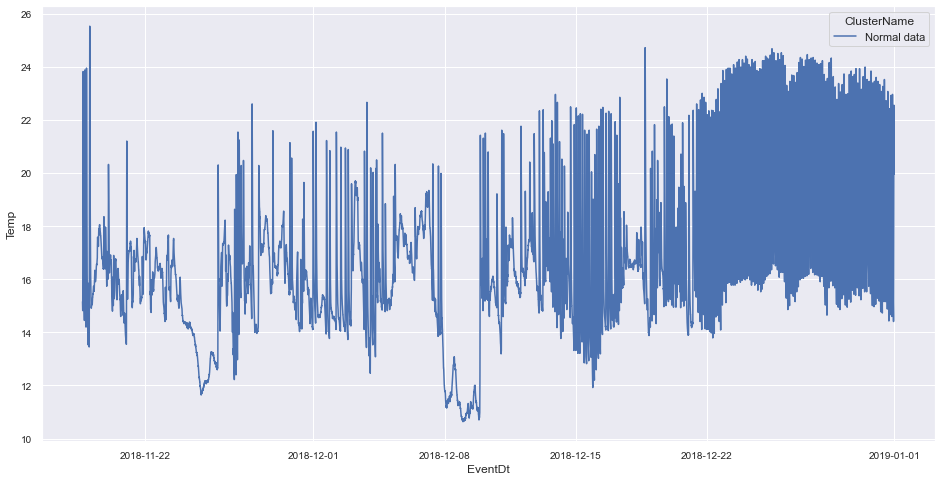

In [234]:
plt.figure(figsize=(16,8))
sns.lineplot(data= df_d_FirstYear, x= df_d_FirstYear.index, y='Temp', hue = 'ClusterName')

In [235]:
ourtlier2018_d = df_d_FirstYear[df_d_FirstYear['ClusterName'] == 'Outlier']
outlier2018count_d = len(ourtlier2018_d)
outlier2018count_d

0

### The Second Year of Df_D (2019)

In [236]:
df_d_SecondYear = df_d.dropna()
var = datetime(2019, 1, 1)
var2 = datetime(2020, 1, 1)
df_d_SecondYear = df_d_SecondYear[df_d_SecondYear.index > var]
df_d_SecondYear = df_d_SecondYear[df_d_SecondYear.index < var2]
df_d_SecondYear

Temp
EventDt                   
2019-01-01 00:05:00  18.21
2019-01-01 00:10:00  17.48
2019-01-01 00:15:00  16.86
2019-01-01 00:20:00  16.34
2019-01-01 00:25:00  15.91
...                    ...
2019-12-31 23:35:00  13.90
2019-12-31 23:40:00  15.70
2019-12-31 23:45:00  17.59
2019-12-31 23:50:00  19.20
2019-12-31 23:55:00  20.76

[105091 rows x 1 columns]

In [237]:
outliers = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
clusters = outliers.fit_predict(df_d_SecondYear)
df_d_SecondYear['Cluster'] = clusters
df_d_SecondYear

Temp  Cluster
EventDt                            
2019-01-01 00:05:00  18.21        0
2019-01-01 00:10:00  17.48        0
2019-01-01 00:15:00  16.86        0
2019-01-01 00:20:00  16.34        0
2019-01-01 00:25:00  15.91        0
...                    ...      ...
2019-12-31 23:35:00  13.90        0
2019-12-31 23:40:00  15.70        0
2019-12-31 23:45:00  17.59        0
2019-12-31 23:50:00  19.20        0
2019-12-31 23:55:00  20.76        0

[105091 rows x 2 columns]

In [238]:
df_d_SecondYear['ClusterName'] = df_d_SecondYear['Cluster'].map({0: "Normal data", -1: "Outlier"})
df_d_SecondYear

Temp  Cluster  ClusterName
EventDt                                         
2019-01-01 00:05:00  18.21        0  Normal data
2019-01-01 00:10:00  17.48        0  Normal data
2019-01-01 00:15:00  16.86        0  Normal data
2019-01-01 00:20:00  16.34        0  Normal data
2019-01-01 00:25:00  15.91        0  Normal data
...                    ...      ...          ...
2019-12-31 23:35:00  13.90        0  Normal data
2019-12-31 23:40:00  15.70        0  Normal data
2019-12-31 23:45:00  17.59        0  Normal data
2019-12-31 23:50:00  19.20        0  Normal data
2019-12-31 23:55:00  20.76        0  Normal data

[105091 rows x 3 columns]

<AxesSubplot:xlabel='EventDt', ylabel='Temp'>

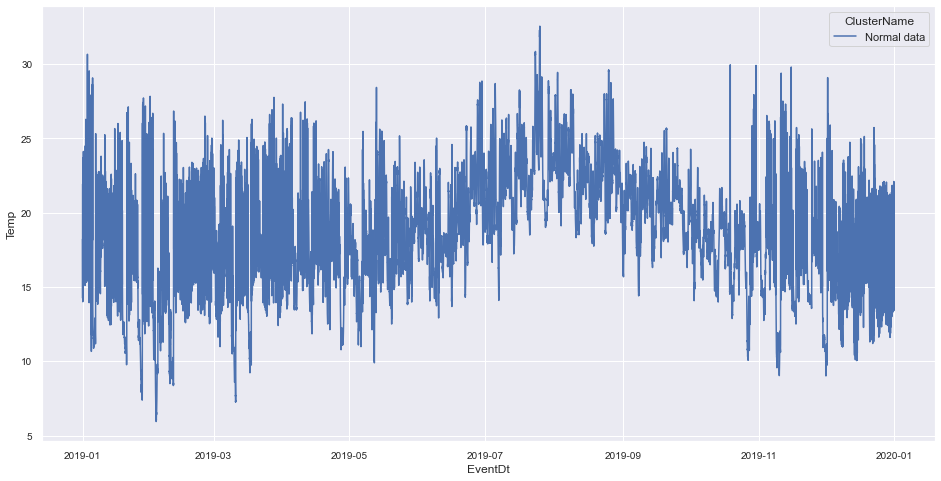

In [239]:
plt.figure(figsize=(16,8))
sns.lineplot(data= df_d_SecondYear, x= df_d_SecondYear.index, y='Temp', hue = 'ClusterName')

In [240]:
ourtlier2019_d = df_d_SecondYear[df_d_SecondYear['ClusterName'] == 'Outlier']
outlier2019count_d = len(ourtlier2019_d)
outlier2019count_d

0

### The Third Year of Df_D (2020)

In [241]:
df_d_ThirdYear = df_d.dropna()
var = datetime(2020, 1, 1)
var2 = datetime(2021, 1, 1)
df_d_ThirdYear = df_d_ThirdYear[df_d_ThirdYear.index > var]
df_d_ThirdYear = df_d_ThirdYear[df_d_ThirdYear.index < var2]
df_d_ThirdYear

Temp
EventDt                   
2020-01-01 00:05:00  21.55
2020-01-01 00:10:00  20.89
2020-01-01 00:15:00  20.07
2020-01-01 00:20:00  19.30
2020-01-01 00:25:00  18.70
...                    ...
2020-12-31 23:35:00  11.73
2020-12-31 23:40:00  11.56
2020-12-31 23:45:00  11.43
2020-12-31 23:50:00  11.39
2020-12-31 23:55:00  12.50

[105381 rows x 1 columns]

In [242]:
outliers = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
clusters = outliers.fit_predict(df_d_ThirdYear)
df_d_ThirdYear['Cluster'] = clusters
df_d_ThirdYear

Temp  Cluster
EventDt                            
2020-01-01 00:05:00  21.55        0
2020-01-01 00:10:00  20.89        0
2020-01-01 00:15:00  20.07        0
2020-01-01 00:20:00  19.30        0
2020-01-01 00:25:00  18.70        0
...                    ...      ...
2020-12-31 23:35:00  11.73        0
2020-12-31 23:40:00  11.56        0
2020-12-31 23:45:00  11.43        0
2020-12-31 23:50:00  11.39        0
2020-12-31 23:55:00  12.50        0

[105381 rows x 2 columns]

In [243]:
df_d_ThirdYear['ClusterName'] = df_d_ThirdYear['Cluster'].map({0: "Normal data", -1: "Outlier"})
df_d_ThirdYear

Temp  Cluster  ClusterName
EventDt                                         
2020-01-01 00:05:00  21.55        0  Normal data
2020-01-01 00:10:00  20.89        0  Normal data
2020-01-01 00:15:00  20.07        0  Normal data
2020-01-01 00:20:00  19.30        0  Normal data
2020-01-01 00:25:00  18.70        0  Normal data
...                    ...      ...          ...
2020-12-31 23:35:00  11.73        0  Normal data
2020-12-31 23:40:00  11.56        0  Normal data
2020-12-31 23:45:00  11.43        0  Normal data
2020-12-31 23:50:00  11.39        0  Normal data
2020-12-31 23:55:00  12.50        0  Normal data

[105381 rows x 3 columns]

<AxesSubplot:xlabel='EventDt', ylabel='Temp'>

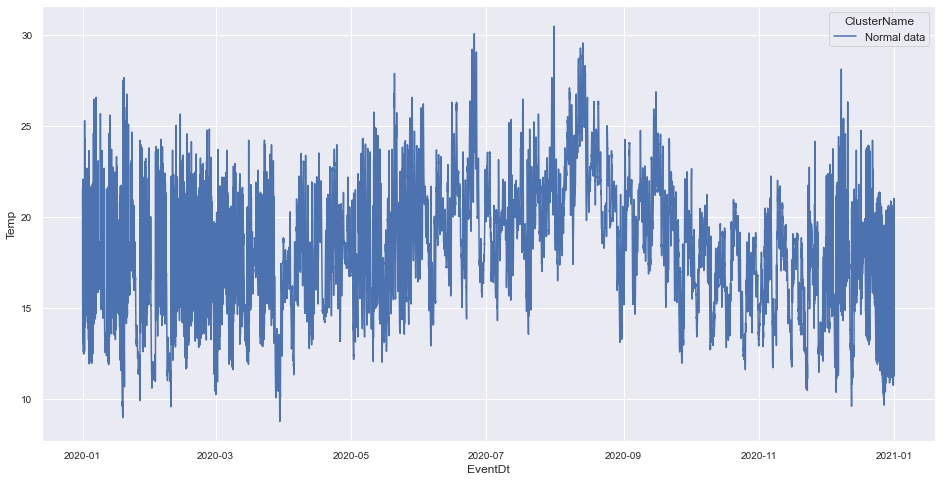

In [244]:
plt.figure(figsize=(16,8))
sns.lineplot(data= df_d_ThirdYear, x= df_d_ThirdYear.index, y='Temp', hue = 'ClusterName')

In [245]:
ourtlier2020_d = df_d_ThirdYear[df_d_ThirdYear['ClusterName'] == 'Outlier']
outlier2020count_d = len(ourtlier2020_d)
outlier2020count_d

0

### The Fourth Year of Df_D (2021)

In [246]:
df_d_FourthYear = df_d.dropna()
var = datetime(2021, 1, 1)
var2 = datetime(2022, 1, 1)
df_d_FourthYear = df_d_FourthYear[df_d_FourthYear.index > var]
df_d_FourthYear = df_d_FourthYear[df_d_FourthYear.index < var2]
df_d_FourthYear

Temp
EventDt                   
2021-01-01 00:05:00  16.41
2021-01-01 00:10:00  18.04
2021-01-01 00:15:00  19.62
2021-01-01 00:20:00  20.83
2021-01-01 00:25:00  20.76
...                    ...
2021-11-18 15:50:00  21.53
2021-11-18 15:55:00  21.47
2021-11-18 16:00:00  21.62
2021-11-18 16:05:00  21.58
2021-11-18 16:10:00  21.66

[90475 rows x 1 columns]

In [247]:
outliers = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None)
clusters = outliers.fit_predict(df_d_FourthYear)
df_d_FourthYear['Cluster'] = clusters
df_d_FourthYear

Temp  Cluster
EventDt                            
2021-01-01 00:05:00  16.41        0
2021-01-01 00:10:00  18.04        0
2021-01-01 00:15:00  19.62        0
2021-01-01 00:20:00  20.83        0
2021-01-01 00:25:00  20.76        0
...                    ...      ...
2021-11-18 15:50:00  21.53        0
2021-11-18 15:55:00  21.47        0
2021-11-18 16:00:00  21.62        0
2021-11-18 16:05:00  21.58        0
2021-11-18 16:10:00  21.66        0

[90475 rows x 2 columns]

In [248]:
df_d_FourthYear['ClusterName'] = df_d_FourthYear['Cluster'].map({0: "Normal data", -1: "Outlier"})
df_d_FourthYear

Temp  Cluster  ClusterName
EventDt                                         
2021-01-01 00:05:00  16.41        0  Normal data
2021-01-01 00:10:00  18.04        0  Normal data
2021-01-01 00:15:00  19.62        0  Normal data
2021-01-01 00:20:00  20.83        0  Normal data
2021-01-01 00:25:00  20.76        0  Normal data
...                    ...      ...          ...
2021-11-18 15:50:00  21.53        0  Normal data
2021-11-18 15:55:00  21.47        0  Normal data
2021-11-18 16:00:00  21.62        0  Normal data
2021-11-18 16:05:00  21.58        0  Normal data
2021-11-18 16:10:00  21.66        0  Normal data

[90475 rows x 3 columns]

<AxesSubplot:xlabel='EventDt', ylabel='Temp'>

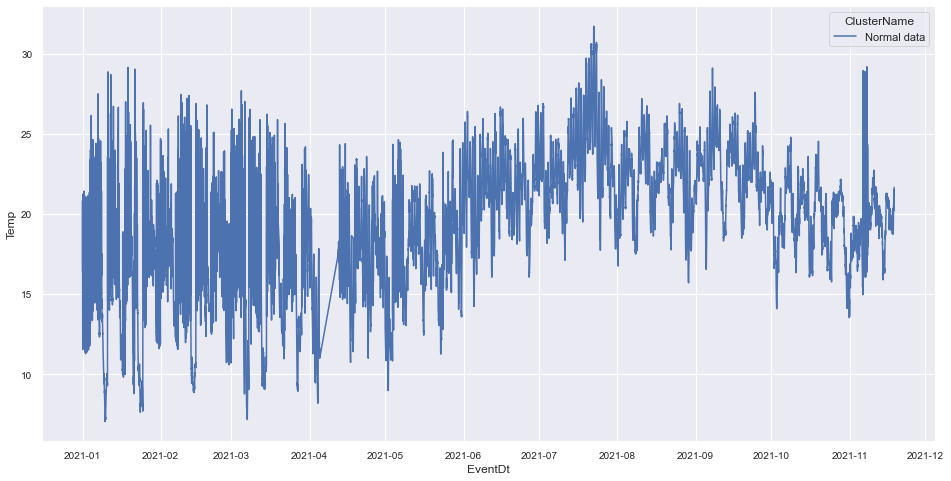

In [249]:
plt.figure(figsize=(16,8))
sns.lineplot(data= df_d_FourthYear, x= df_d_FourthYear.index, y='Temp', hue = 'ClusterName')

In [250]:
ourtlier2021_d = df_d_FourthYear[df_d_FourthYear['ClusterName'] == 'Outlier']
outlier2021count_d = len(ourtlier2021_d)
outlier2021count_d

0

## Merge the DF_D Dataframe into One Dataframe

In [251]:
frames = [ourtlier2019_d, ourtlier2020_d, ourtlier2021_d]
result = pd.concat(frames)
allOutlieramount = len(result)

In [258]:
whole_data = [df_d_FirstYear, df_d_SecondYear, df_d_ThirdYear, df_d_FourthYear]
sum_data = pd.concat(whole_data)
sum_data

Temp  Cluster  ClusterName
EventDt                                         
2018-11-18 16:15:00  15.16        0  Normal data
2018-11-18 16:20:00  15.03        0  Normal data
2018-11-18 16:25:00  14.88        0  Normal data
2018-11-18 16:30:00  14.82        0  Normal data
2018-11-18 16:35:00  15.96        0  Normal data
...                    ...      ...          ...
2021-11-18 15:50:00  21.53        0  Normal data
2021-11-18 15:55:00  21.47        0  Normal data
2021-11-18 16:00:00  21.62        0  Normal data
2021-11-18 16:05:00  21.58        0  Normal data
2021-11-18 16:10:00  21.66        0  Normal data

[313424 rows x 3 columns]

## Checking the Percentage of the Outliers

It's crucial to determine how much the outliers contribute inside the device; aside from displaying them and then clustering them, it's also crucial to determine the percentage it takes for the entire device to determine whether it needs to be checked more closely or replaced, and so on.

In [253]:
allDataAmount = len(sum_data)

#finding the %
def percentage(part, whole):
  Percentage = 100 * int(part)/int(whole)
  return Percentage
percent = percentage(allOutlieramount,allDataAmount)
print(f'Percentage: {round(percent,2)} %')

Percentage: 0.0 %


# Modeling

## Prefered Algorithm

In [49]:
def prepareData(df):
    shape = [-1] + [len(level) for level in df.columns.remove_unused_levels().levels]
    return df.values.reshape(shape)

def createDelayedColumns(series, times):
    cols = []
    column_index = []
    for time in times:
        cols.append(series.shift(-time))
        lag_fmt = "t+{time}" if time > 0 else "t{time}" if time < 0 else "t"
        column_index += [(lag_fmt.format(time=time), col_name)
                        for col_name in series.columns]
    df = pd.concat(cols, axis=1)
    df.columns = pd.MultiIndex.from_tuples(column_index)
    return df

In [50]:
## Copying desired dataframe
df_copy = df_a.copy()
df_copy = df_copy.fillna(method="ffill")

scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(df_copy)

df_copy_scaled = df_copy
df_copy_scaled["Temp"] = scaler.transform(df_copy)

## Processing data
previousDays = 20
## Which day we predict (1=Next Day)
afterDays = 1

X = createDelayedColumns(df_copy_scaled, times=range(-previousDays+1,1)).iloc[previousDays:-afterDays]
y = createDelayedColumns(df_copy_scaled, times=[afterDays]).iloc[previousDays:-afterDays]

## Creating train and test datasets
train_slice = slice(None, "2020-12-28")
test_slice = slice("2021-01-01", None)
X_train, y_train = X.loc[train_slice], y.loc[train_slice]
X_test, y_test = X.loc[test_slice], y.loc[test_slice]

## Converting our Training dataset into 3D dataset
## (Values, LookBack, Features)
X_train_3D = prepareData(X_train)
X_test_3D = prepareData(X_test)

steps_back = len(X_train_3D[1])

In [51]:
## Creating our GRU model
model_simpleRNN = keras.models.Sequential()
model_simpleRNN.add(keras.layers.SimpleRNN(50, return_sequences=True, input_shape=(steps_back,1)))
model_simpleRNN.add(keras.layers.SimpleRNN(25))
model_simpleRNN.add(keras.layers.Dense(1))

model_simpleRNN.compile(loss="mse", optimizer="adam", metrics=["mae"])
model_simpleRNN.summary()

## Training our Model
history_simpleRNN = model_simpleRNN.fit(X_train_3D, y_train, epochs=5, 
                                        batch_size=128, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 50)            2600      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 25)                1900      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 4,526
Trainable params: 4,526
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1562/1562 [==============================] - 7s 4ms/step - loss: 3.0925e-04 - mae: 0.0056 - val_loss: 2.4477e-05 - val_mae: 0.0014
Epoch 2/5
1562/1562 [==============================] - 6s 4ms/step - loss: 5.1360e-05 - mae: 0.0037 - val_loss: 1.6877e-05 - val_mae: 0.0022
Epoch 3/5
1562/1562 [===============

In [52]:
## Creating our GRU model
model_GRU = keras.models.Sequential()
model_GRU.add(keras.layers.GRU(50, return_sequences=True, input_shape=(steps_back,1)))
# model_LSTM.add(Dropout(0.2))
model_GRU.add(keras.layers.GRU(25))
# model_LSTM.add(Dropout(0.2))
model_GRU.add(keras.layers.Dense(1))

model_GRU.compile(loss="mse", optimizer="adam", metrics=["mae"])
model_GRU.summary()

## Training our Model
history_GRU = model_GRU.fit(X_train_3D, y_train, epochs=5, 
                                        batch_size=128, validation_split=0.1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 50)            7950      
                                                                 
 gru_1 (GRU)                 (None, 25)                5775      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 13,751
Trainable params: 13,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1562/1562 [==============================] - 19s 11ms/step - loss: 3.7609e-04 - mae: 0.0046 - val_loss: 2.7170e-05 - val_mae: 8.6482e-04
Epoch 2/5
1562/1562 [==============================] - 17s 11ms/step - loss: 3.8036e-05 - mae: 0.0021 - val_loss: 1.3901e-05 - val_mae: 9.0233e-04
Epoch 3/5
1562/1562 

In [53]:
model_LSTM = keras.models.Sequential()

model_LSTM.add(LSTM(input_shape=(steps_back,1),units=50,return_sequences=True))
# model_LSTM.add(Dropout(0.2))

model_LSTM.add(LSTM(units=25,return_sequences=False))
# model_LSTM.add(Dropout(0.2))

model_LSTM.add(Dense(units=1, activation='sigmoid'))
model_LSTM.compile(loss='mse', optimizer='adam', metrics=['mae'])

history_LSTM = model_LSTM.fit(X_train_3D, y_train, epochs=5, 
                                        batch_size=128, validation_split=0.1)

Epoch 1/5
1562/1562 [==============================] - 20s 11ms/step - loss: 0.0068 - mae: 0.0326 - val_loss: 0.0028 - val_mae: 0.0093
Epoch 2/5
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0052 - mae: 0.0266 - val_loss: 0.0027 - val_mae: 0.0074
Epoch 3/5
1562/1562 [==============================] - 18s 11ms/step - loss: 0.0051 - mae: 0.0255 - val_loss: 0.0027 - val_mae: 0.0079
Epoch 4/5
1562/1562 [==============================] - 18s 11ms/step - loss: 0.0050 - mae: 0.0248 - val_loss: 0.0030 - val_mae: 0.0194
Epoch 5/5
1562/1562 [==============================] - 18s 11ms/step - loss: 0.0050 - mae: 0.0244 - val_loss: 0.0027 - val_mae: 0.0061


<AxesSubplot:>

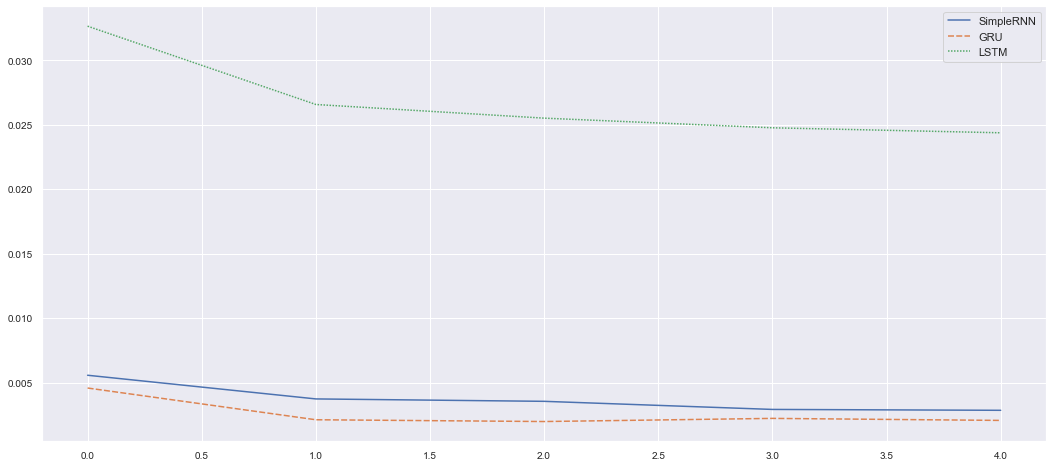

In [54]:
mae_df = pd.DataFrame()
mae_df["SimpleRNN"] = history_simpleRNN.history.get("mae")
mae_df["GRU"] = history_GRU.history.get("mae")
mae_df["LSTM"] = history_LSTM.history.get("mae")
mae_df

sns.lineplot(data=mae_df)

Based on the mean absolute error we will be selecting GRU (Gated Recurrent Unit) as our algorithm of choice

## Device K Predictions

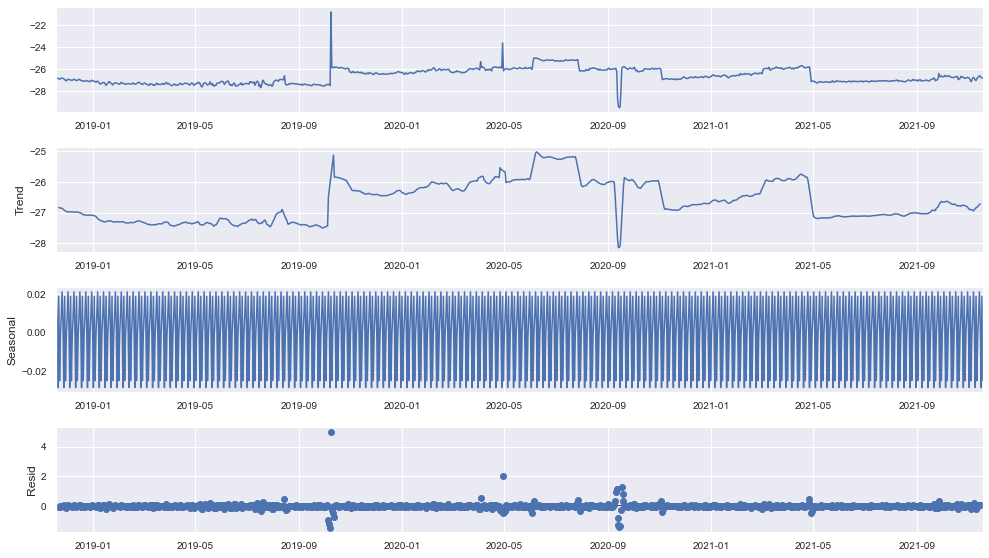

In [70]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(df_k_daily,model='additive')
fig = result.plot()

### GRU

In [371]:
df_copy = df_k_rmv

scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(df_copy)

df_copy_scaled = df_copy
df_copy_scaled["Temp"] = scaler.transform(df_copy)
df_copy_scaled

Temp
EventDt                      
2018-11-18 16:40:00  0.250000
2018-11-18 16:45:00  0.175000
2018-11-18 16:50:00  0.067857
2018-11-18 16:55:00 -0.060714
2018-11-18 17:00:00 -0.146429
...                       ...
2021-11-18 16:15:00 -0.114286
2021-11-18 16:20:00 -0.046429
2021-11-18 16:25:00  0.032143
2021-11-18 16:30:00  0.032143
2021-11-18 16:35:00 -0.050000

[314714 rows x 1 columns]

In [372]:
## Look back (How many days in the past we check for prediction)
previousDays = 20
## Which day we predict (1=Next Day)
afterDays = 1

X = createDelayedColumns(df_copy_scaled, times=range(-previousDays+1,1)).iloc[previousDays:-afterDays]
y = createDelayedColumns(df_copy_scaled, times=[afterDays]).iloc[previousDays:-afterDays]

In [373]:
X

t-19      t-18      t-17      t-16      t-15  \
                         Temp      Temp      Temp      Temp      Temp   
EventDt                                                                 
2018-11-18 18:20:00  0.175000  0.067857 -0.060714 -0.146429 -0.196429   
2018-11-18 18:25:00  0.067857 -0.060714 -0.146429 -0.196429 -0.207143   
2018-11-18 18:30:00 -0.060714 -0.146429 -0.196429 -0.207143 -0.171429   
2018-11-18 18:35:00 -0.146429 -0.196429 -0.207143 -0.171429 -0.132143   
2018-11-18 18:40:00 -0.196429 -0.207143 -0.171429 -0.132143 -0.103571   
...                       ...       ...       ...       ...       ...   
2021-11-18 16:10:00 -0.128571 -0.253571 -0.296429 -0.296429 -0.264286   
2021-11-18 16:15:00 -0.253571 -0.296429 -0.296429 -0.264286 -0.207143   
2021-11-18 16:20:00 -0.296429 -0.296429 -0.264286 -0.207143 -0.171429   
2021-11-18 16:25:00 -0.296429 -0.264286 -0.207143 -0.171429 -0.114286   
2021-11-18 16:30:00 -0.264286 -0.207143 -0.171429 -0.114286 -0.075000   

                         t-14      t-13      t-12      t-11      t-10  \
                         Temp      Temp      Temp      Temp      Temp   
EventDt                                                                 
2018-11-18 18:20:00 -0.207143 -0.171429 -0.132143 -0.103571 -0.057143   
2018-11-18 18:25:00 -0.171429 -0.132143 -0.103571 -0.057143  0.000000   
2018-11-18 18:30:00 -0.132143 -0.103571 -0.057143  0.000000  0.050000   
2018-11-18 18:35:00 -0.103571 -0.057143  0.000000  0.050000  0.121429   
2018-11-18 18:40:00 -0.057143  0.000000  0.050000  0.121429  0.185714   
...                       ...       ...       ...       ...       ...   
2021-11-18 16:10:00 -0.207143 -0.171429 -0.114286 -0.075000 -0.014286   
2021-11-18 16:15:00 -0.171429 -0.114286 -0.075000 -0.014286  0.067857   
2021-11-18 16:20:00 -0.114286 -0.075000 -0.014286  0.067857  0.132143   
2021-11-18 16:25:00 -0.075000 -0.014286  0.067857  0.132143  0.107143   
2021-11-18 16:30:00 -0.014286  0.067857  0.132143  0.107143  0.014286   

                          t-9       t-8       t-7       t-6       t-5  \
                         Temp      Temp      Temp      Temp      Temp   
EventDt                                                                 
2018-11-18 18:20:00  0.000000  0.050000  0.121429  0.185714  0.232143   
2018-11-18 18:25:00  0.050000  0.121429  0.185714  0.232143  0.221429   
2018-11-18 18:30:00  0.121429  0.185714  0.232143  0.221429  0.150000   
2018-11-18 18:35:00  0.185714  0.232143  0.221429  0.150000  0.046429   
2018-11-18 18:40:00  0.232143  0.221429  0.150000  0.046429 -0.085714   
...                       ...       ...       ...       ...       ...   
2021-11-18 16:10:00  0.067857  0.132143  0.107143  0.014286 -0.096429   
2021-11-18 16:15:00  0.132143  0.107143  0.014286 -0.096429 -0.228571   
2021-11-18 16:20:00  0.107143  0.014286 -0.096429 -0.228571 -0.282143   
2021-11-18 16:25:00  0.014286 -0.096429 -0.228571 -0.282143 -0.264286   
2021-11-18 16:30:00 -0.096429 -0.228571 -0.282143 -0.264286 -0.239286   

                          t-4       t-3       t-2       t-1         t  
                         Temp      Temp      Temp      Temp      Temp  
EventDt                                                                
2018-11-18 18:20:00  0.221429  0.150000  0.046429 -0.085714 -0.178571  
2018-11-18 18:25:00  0.150000  0.046429 -0.085714 -0.178571 -0.232143  
2018-11-18 18:30:00  0.046429 -0.085714 -0.178571 -0.232143 -0.257143  
2018-11-18 18:35:00 -0.085714 -0.178571 -0.232143 -0.257143 -0.232143  
2018-11-18 18:40:00 -0.178571 -0.232143 -0.257143 -0.232143 -0.182143  
...                       ...       ...       ...       ...       ...  
2021-11-18 16:10:00 -0.228571 -0.282143 -0.264286 -0.239286 -0.185714  
2021-11-18 16:15:00 -0.282143 -0.264286 -0.239286 -0.185714 -0.114286  
2021-11-18 16:20:00 -0.264286 -0.239286 -0.185714 -0.114286 -0.046429  
2021-11-18 16:25:00 -0.239286 -0.185714 -0.114286 -0.046429  0.032143  
2021-11-18 16:30:00 

In [374]:
y

t+1
                         Temp
EventDt                      
2018-11-18 18:20:00 -0.232143
2018-11-18 18:25:00 -0.257143
2018-11-18 18:30:00 -0.232143
2018-11-18 18:35:00 -0.182143
2018-11-18 18:40:00 -0.146429
...                       ...
2021-11-18 16:10:00 -0.114286
2021-11-18 16:15:00 -0.046429
2021-11-18 16:20:00  0.032143
2021-11-18 16:25:00  0.032143
2021-11-18 16:30:00 -0.050000

[314693 rows x 1 columns]

In [375]:
print(X.shape, y.shape)

(314693, 20) (314693, 1)


In [376]:
## Creating train and test datasets
train_slice = slice(None, "2020-12-28")
test_slice = slice("2021-01-01", None)
X_train, y_train = X.loc[train_slice], y.loc[train_slice]
X_test, y_test = X.loc[test_slice], y.loc[test_slice]

In [377]:
## Converting our Training dataset into 3D dataset
## (Values, LookBack, Features)
X_train_3D = prepareData(X_train)
X_test_3D = prepareData(X_test)

steps_back = len(X_train_3D[1])
print(X_train_3D.shape, X_test_3D.shape)

(221227, 20, 1) (92604, 20, 1)


In [378]:
## Creating our GRU model
model = keras.models.Sequential()
model.add(keras.layers.GRU(50, return_sequences=True, input_shape=(steps_back,1)))
model.add(keras.layers.GRU(25))
model.add(keras.layers.Dense(1))

model.compile(loss="mse", optimizer="adam", metrics=["mae"])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 20, 50)            7950      
                                                                 
 gru_11 (GRU)                (None, 25)                5775      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 13,751
Trainable params: 13,751
Non-trainable params: 0
_________________________________________________________________


In [379]:
# # Training our Model
# history = model.fit(X_train_3D, y_train, epochs=5, 
#                                         batch_size=128, validation_split=0.1)

# model.save('./models/Device K/')

## Loading our model
model = keras.models.load_model('./models/Device K/')

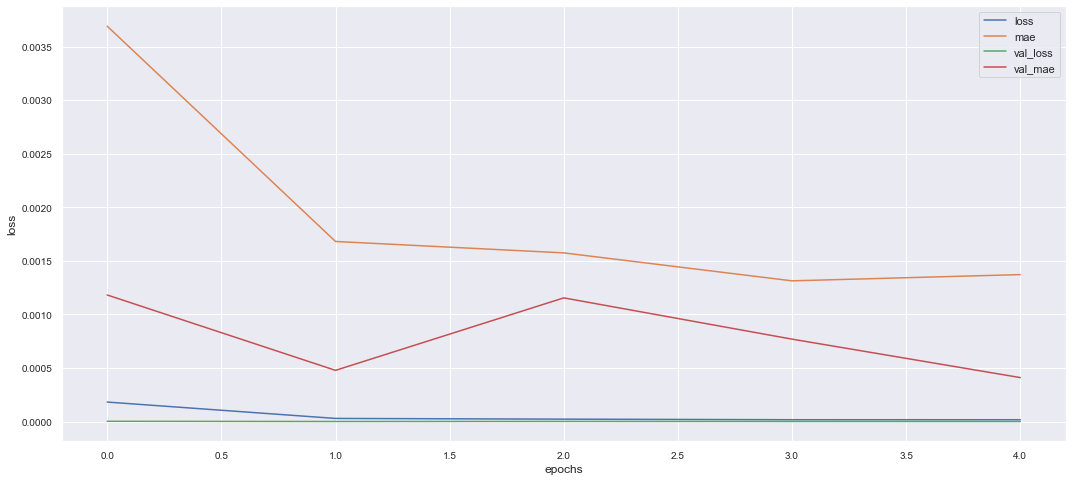

In [380]:
pd.DataFrame(history.history).plot()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid(True)
plt.show()

In [381]:
preds = model.predict(X_test_3D)
preds.shape

(92604, 1)

In [382]:
preds = scaler.inverse_transform(preds)

Ytest=np.asanyarray(y_test)  
Ytest=Ytest.reshape(-1,1) 
Ytest = scaler.inverse_transform(y_test)

Ytrain=np.asanyarray(y_train)  
Ytrain=Ytrain.reshape(-1,1) 
Ytrain = scaler.inverse_transform(y_train)

mean_squared_error(Ytest,preds)

0.02178398428117701

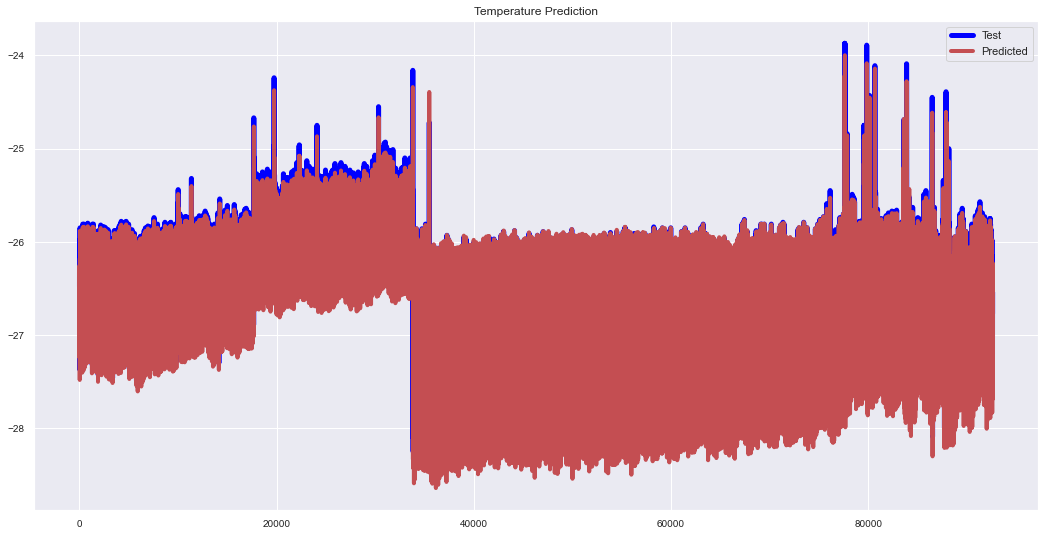

In [383]:
plt.figure(figsize=(18,9))
plt.plot(Ytest , 'blue', linewidth=5)
plt.plot(preds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Temperature Prediction")
plt.show()

In [84]:
#### Prediction
## Store forecast
forecast = [] 
## How many days should be predicted
periods = 10 
## How many previous days should be used
length=20
first_eval_batch = data_scaled[-steps_back:]
## Shaping starting data
current_batch = first_eval_batch.reshape((1, steps_back, 1))
for i in range(periods):
    ## Get prediction value
    current_pred = model.predict(current_batch)[0] 
    ## Store prediction value
    forecast.append(current_pred) 
    ## Update the batch and drop the first value to keep the set length
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [85]:
## Reverse the MinMax scaling on the forecast
forecast = scaler.inverse_transform(forecast)

In [86]:
## Create a date range from the last available datapoint
last_timestamp = (df_copy.tail(1).index + timedelta(minutes=5)).strftime("%d/%m/%Y, %H:%M:%S")[0]
forecast_index = pd.date_range(start=last_timestamp,periods=periods,freq='5T')

In [87]:
## Combine the prediction values and date range into a dataframe
forecast_df = pd.DataFrame(data=forecast,
                           index=forecast_index,
                           columns=['Forecast']) 

forecast_df['Forecast']= forecast_df['Forecast'].astype(float)
forecast_df

Forecast
2021-11-18 16:40:00 -26.899050
2021-11-18 16:45:00 -27.060407
2021-11-18 16:50:00 -27.122449
2021-11-18 16:55:00 -27.092629
2021-11-18 17:00:00 -26.982852
2021-11-18 17:05:00 -26.820172
2021-11-18 17:10:00 -26.634692
2021-11-18 17:15:00 -26.454829
2021-11-18 17:20:00 -26.302565
2021-11-18 17:25:00 -26.190939

In [88]:
## Reverse the MinMax scaling on the original dataframe
df_copy["Temp"] = scaler.inverse_transform(df_copy)

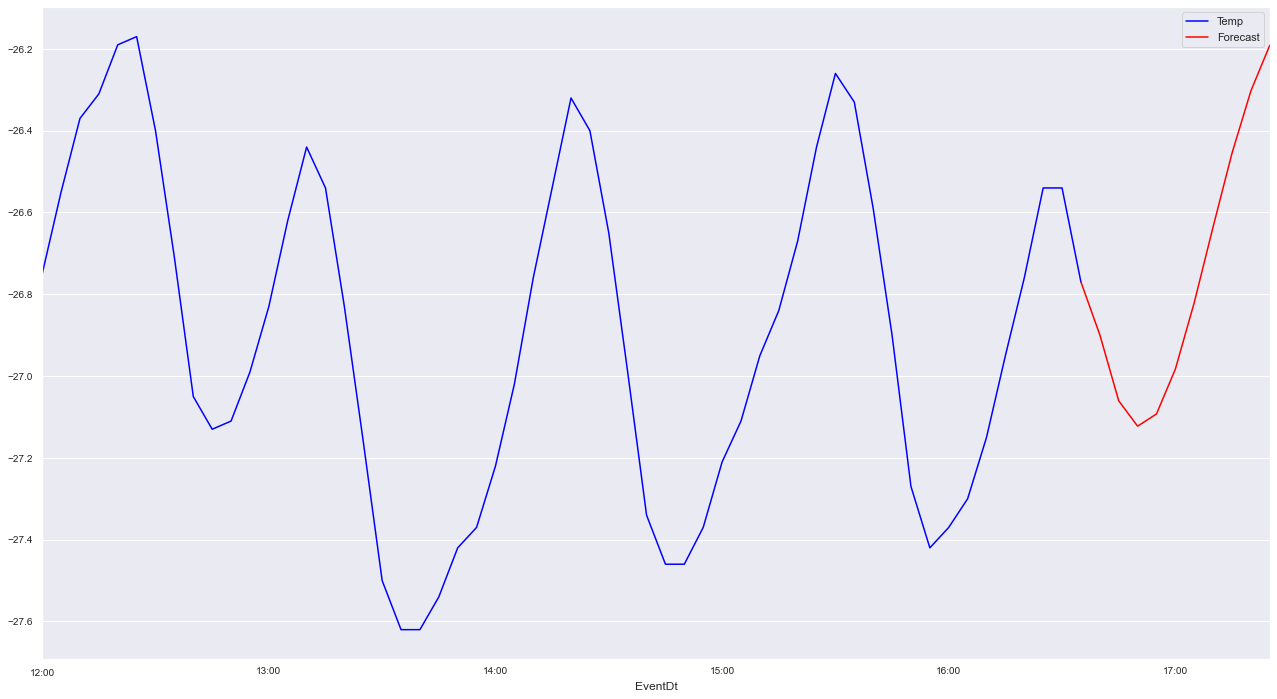

In [89]:
## Add the last available datapoint to the start of the prediction to connect the graph
end_data = (df_copy.tail(1).index).strftime("%d/%m/%Y, %H:%M:%S")[0]
end_pred = (forecast_df.tail(1).index).strftime("%d/%m/%Y, %H:%M:%S")[0]

ix = pd.date_range(start=end_data, end=end_pred, freq='5T')
forecast_df = forecast_df.reindex(ix)

forecast_df.at[end_data,"Forecast"] = df_copy[-1:]["Temp"].astype(float)

## Plot the data
ax = df_copy.loc["2021-11-18 12:00:00":].plot(figsize=(22,12), color='blue')
forecast_df.plot(ax=ax, color='red');

## Device I Predictions

### GRU

In [429]:
df_copy = df_i_rmv

scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(df_copy)

df_copy_scaled = df_copy
df_copy_scaled["Temp"] = scaler.transform(df_copy)
df_copy_scaled

Temp
EventDt                      
2018-11-18 16:35:00 -0.298572
2018-11-18 16:40:00 -0.295575
2018-11-18 16:45:00 -0.298572
2018-11-18 16:50:00 -0.301568
2018-11-18 16:55:00 -0.299570
...                       ...
2021-11-18 16:10:00 -0.293577
2021-11-18 16:15:00 -0.292578
2021-11-18 16:20:00 -0.294576
2021-11-18 16:25:00 -0.293577
2021-11-18 16:30:00 -0.294576

[278614 rows x 1 columns]

In [430]:
previousDays = 20
## Which day we predict (1=Next Day)
afterDays = 1

X = createDelayedColumns(df_copy_scaled, times=range(-previousDays+1,1)).iloc[previousDays:-afterDays]
y = createDelayedColumns(df_copy_scaled, times=[afterDays]).iloc[previousDays:-afterDays]
print(X.shape, y.shape)

(278593, 20) (278593, 1)


In [431]:
## Creating train and test datasets
train_slice = slice(None, "2020-12-28")
test_slice = slice("2021-01-01", None)
X_train, y_train = X.loc[train_slice], y.loc[train_slice]
X_test, y_test = X.loc[test_slice], y.loc[test_slice]

In [432]:
## Converting our Training dataset into 3D dataset
## (Values, LookBack, Features)
X_train_3D = prepareData(X_train)
X_test_3D = prepareData(X_test)

steps_back = len(X_train_3D[1])
print(X_train_3D.shape, X_test_3D.shape)

(203425, 20, 1) (75168, 20, 1)


In [433]:
## Creating our GRU model
model = keras.models.Sequential()
model.add(keras.layers.GRU(50, return_sequences=True, input_shape=(steps_back,1)))
model.add(keras.layers.GRU(25))
model.add(keras.layers.Dense(1))

model.compile(loss="mse", optimizer="adam", metrics=["mae"])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_14 (GRU)                (None, 20, 50)            7950      
                                                                 
 gru_15 (GRU)                (None, 25)                5775      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                                                                 
Total params: 13,751
Trainable params: 13,751
Non-trainable params: 0
_________________________________________________________________


In [434]:
# # Training our Model
# history = model.fit(X_train_3D, y_train, epochs=5, 
#                                         batch_size=128, validation_split=0.1)
# model.save('./models/Device I/')

## Loading our model
model = keras.models.load_model('./models/Device I/')

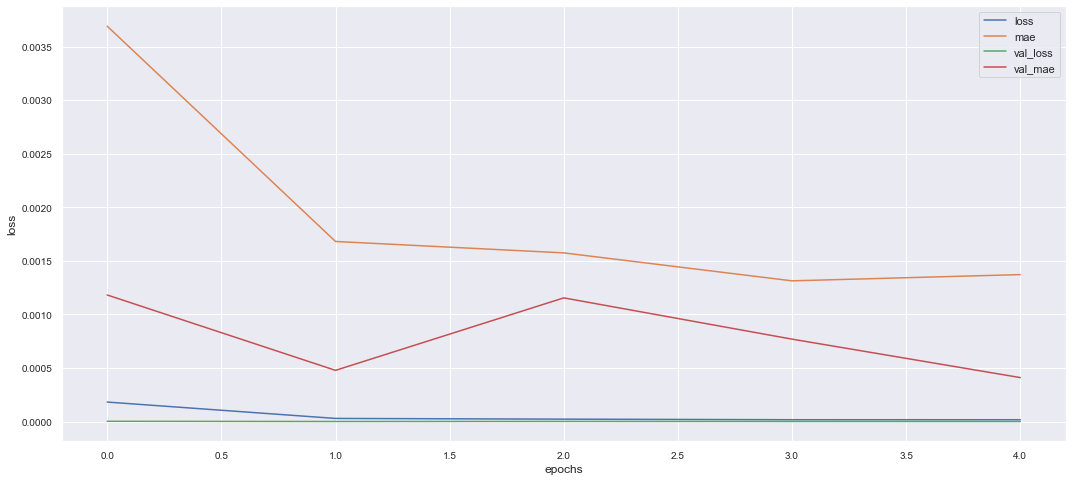

In [435]:
pd.DataFrame(history.history).plot()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid(True)
plt.show()

In [436]:
preds = model.predict(X_test_3D)
preds.shape

(75168, 1)

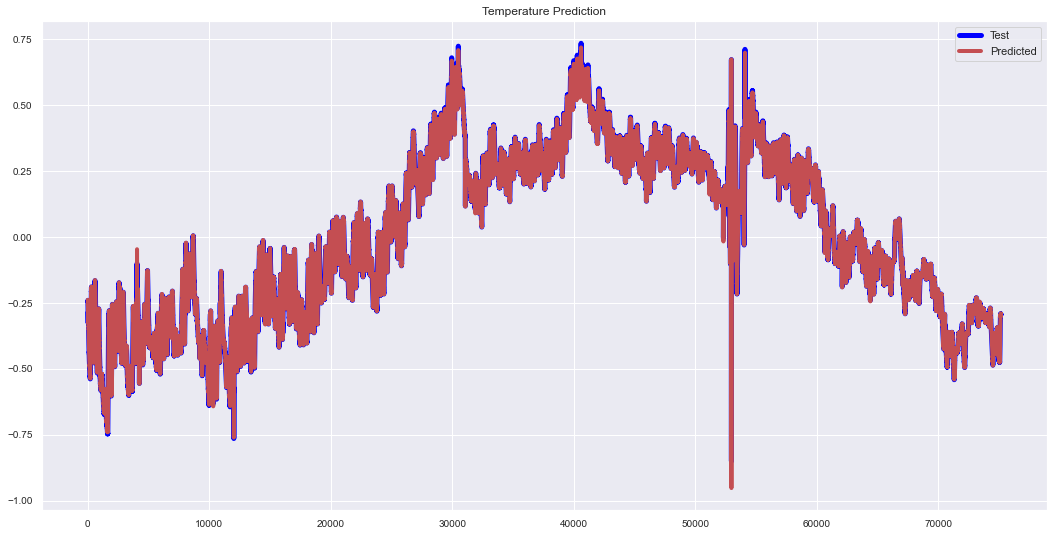

In [437]:
preds = scaler.inverse_transform(preds)

Ytest=np.asanyarray(y_test)  
Ytest=Ytest.reshape(-1,1) 
Ytest = scaler.inverse_transform(y_test)

Ytrain=np.asanyarray(y_train)  
Ytrain=Ytrain.reshape(-1,1) 
Ytrain = scaler.inverse_transform(y_train)

mean_squared_error(Ytest,preds)

plt.figure(figsize=(18,9))
plt.plot(Ytest , 'blue', linewidth=5)
plt.plot(preds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Temperature Prediction")
plt.show()

In [64]:
#### Prediction
## Store forecast
forecast = [] 
## How many days should be predicted
periods = 10 
## How many previous days should be used
length=20
first_eval_batch = data_scaled[-steps_back:]
## Shaping starting data
current_batch = first_eval_batch.reshape((1, steps_back, 1))
for i in range(periods):
    ## Get prediction value
    current_pred = model.predict(current_batch)[0] 
    ## Store prediction value
    forecast.append(current_pred) 
    ## Update the batch and drop the first value to keep the set length
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [65]:
## Reverse the MinMax scaling on the forecast
forecast = scaler.inverse_transform(forecast)

In [66]:
## Create a date range from the last available datapoint
last_timestamp = (df_copy.tail(1).index + timedelta(minutes=5)).strftime("%d/%m/%Y, %H:%M:%S")[0]
forecast_index = pd.date_range(start=last_timestamp,periods=periods,freq='5T')

In [67]:
## Combine the prediction values and date range into a dataframe
forecast_df = pd.DataFrame(data=forecast,
                           index=forecast_index,
                           columns=['Forecast']) 

forecast_df['Forecast']= forecast_df['Forecast'].astype(float)
forecast_df

Forecast
2021-11-18 16:35:00  14.642307
2021-11-18 16:40:00  14.648934
2021-11-18 16:45:00  14.657018
2021-11-18 16:50:00  14.665747
2021-11-18 16:55:00  14.674721
2021-11-18 17:00:00  14.683782
2021-11-18 17:05:00  14.692867
2021-11-18 17:10:00  14.701953
2021-11-18 17:15:00  14.711034
2021-11-18 17:20:00  14.720105

In [68]:
## Reverse the MinMax scaling on the original dataframe
df_copy["Temp"] = scaler.inverse_transform(df_copy)

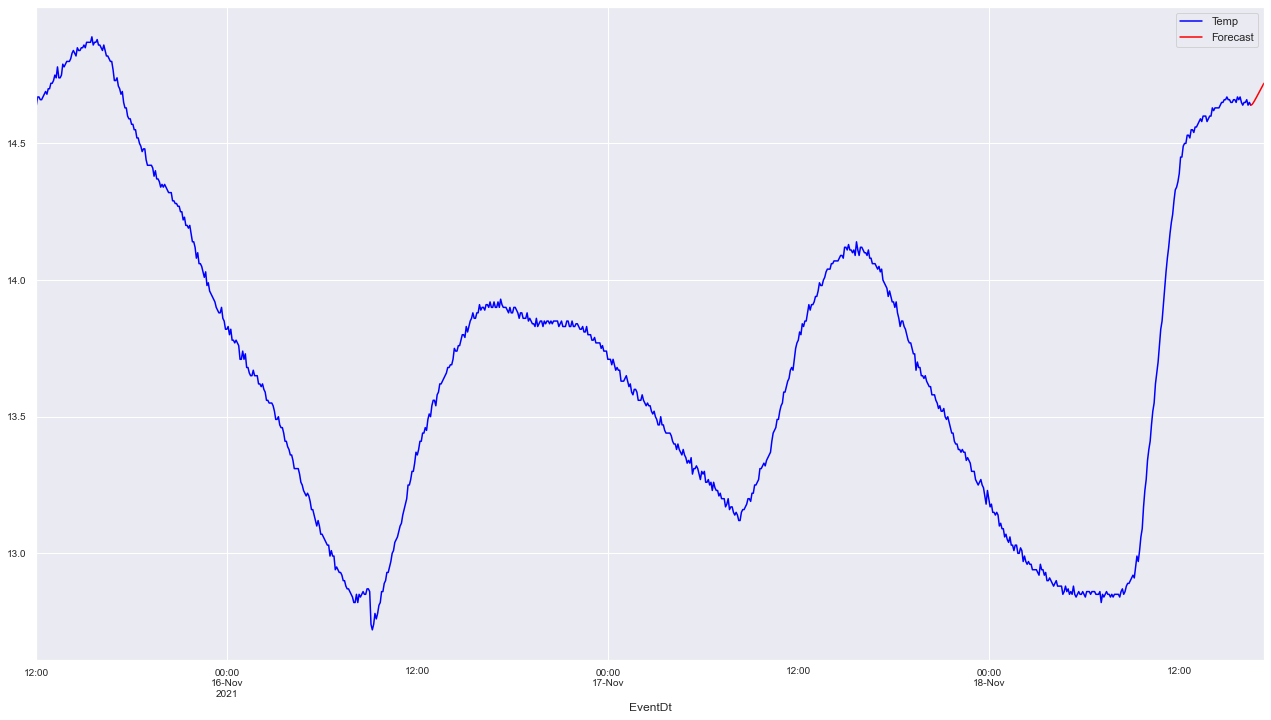

In [69]:
## Add the last available datapoint to the start of the prediction to connect the graph
end_data = (df_copy.tail(1).index).strftime("%d/%m/%Y, %H:%M:%S")[0]
end_pred = (forecast_df.tail(1).index).strftime("%d/%m/%Y, %H:%M:%S")[0]

ix = pd.date_range(start=end_data, end=end_pred, freq='5T')
forecast_df = forecast_df.reindex(ix)

forecast_df.at[end_data,"Forecast"] = df_copy[-1:]["Temp"].astype(float)

## Plot the data
ax = df_copy.loc["2021-11-15 12:00:00":].plot(figsize=(22,12), color='blue')
forecast_df.plot(ax=ax, color='red');

## Device S predictions

In [90]:
df_s_daily

Temp
EventDt             
2018-11-18  1.119767
2018-11-19  1.457917
2018-11-20  1.675347
2018-11-21  1.848229
2018-11-22  1.921597
...              ...
2021-11-14  1.146146
2021-11-15  1.027743
2021-11-16  1.436840
2021-11-17  1.883576
2021-11-18  1.571294

[1097 rows x 1 columns]

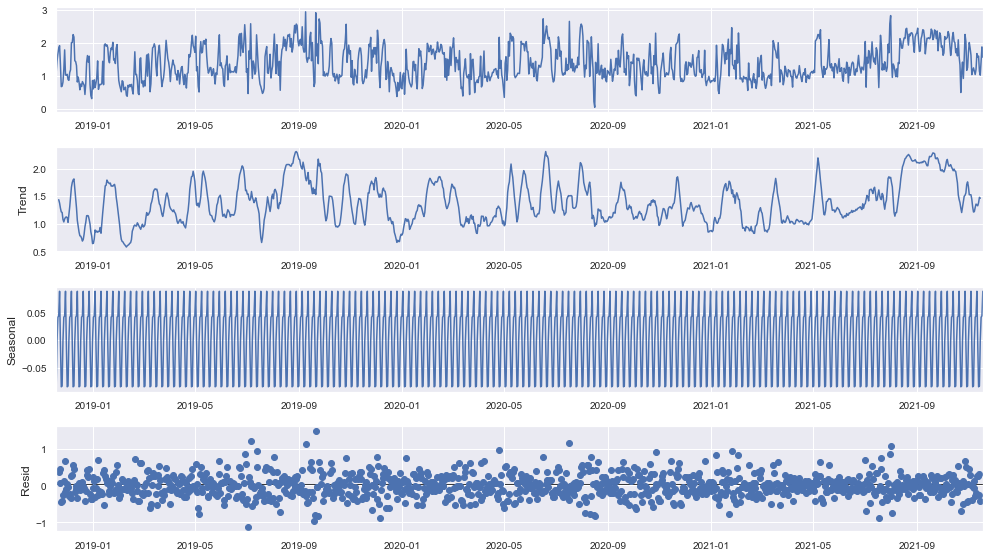

In [91]:
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result = seasonal_decompose(df_s_daily,model='additive')
fig = result.plot()

### GRU

In [438]:
df_copy = df_s_rmv

scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(df_copy)

df_copy_scaled = df_copy
df_copy_scaled["Temp"] = scaler.transform(df_copy)
df_copy_scaled

Temp
EventDt                      
2018-11-18 16:50:00 -0.104072
2018-11-18 16:55:00 -0.099548
2018-11-18 17:00:00 -0.117647
2018-11-18 17:05:00 -0.126697
2018-11-18 17:10:00 -0.131222
...                       ...
2021-11-18 16:20:00 -0.533937
2021-11-18 16:25:00 -0.538462
2021-11-18 16:30:00 -0.538462
2021-11-18 16:35:00 -0.552036
2021-11-18 16:40:00 -0.538462

[315270 rows x 1 columns]

In [439]:
previousDays = 20
## Which day we predict (1=Next Day)
afterDays = 1

X = createDelayedColumns(df_copy_scaled, times=range(-previousDays+1,1)).iloc[previousDays:-afterDays]
y = createDelayedColumns(df_copy_scaled, times=[afterDays]).iloc[previousDays:-afterDays]
print(X.shape, y.shape)

(315249, 20) (315249, 1)


In [440]:
## Creating train and test datasets
train_slice = slice(None, "2020-12-28")
test_slice = slice("2021-01-01", None)
X_train, y_train = X.loc[train_slice], y.loc[train_slice]
X_test, y_test = X.loc[test_slice], y.loc[test_slice]

In [441]:
## Converting our Training dataset into 3D dataset
## (Values, LookBack, Features)
X_train_3D = prepareData(X_train)
X_test_3D = prepareData(X_test)

steps_back = len(X_train_3D[1])
print(X_train_3D.shape, X_test_3D.shape)

(221795, 20, 1) (92590, 20, 1)


In [442]:
## Creating our GRU model
model = keras.models.Sequential()
model.add(keras.layers.GRU(50, return_sequences=True, input_shape=(steps_back,1)))
model.add(keras.layers.GRU(25))
model.add(keras.layers.Dense(1))

model.compile(loss="mse", optimizer="adam", metrics=["mae"])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_16 (GRU)                (None, 20, 50)            7950      
                                                                 
 gru_17 (GRU)                (None, 25)                5775      
                                                                 
 dense_8 (Dense)             (None, 1)                 26        
                                                                 
Total params: 13,751
Trainable params: 13,751
Non-trainable params: 0
_________________________________________________________________


In [443]:
# ## Training our Model
# history = model.fit(X_train_3D, y_train, epochs=5, 
#                                         batch_size=128, validation_split=0.1)

# model.save('./models/Device S/')

## Loading our model
model = keras.models.load_model('./models/Device S/')

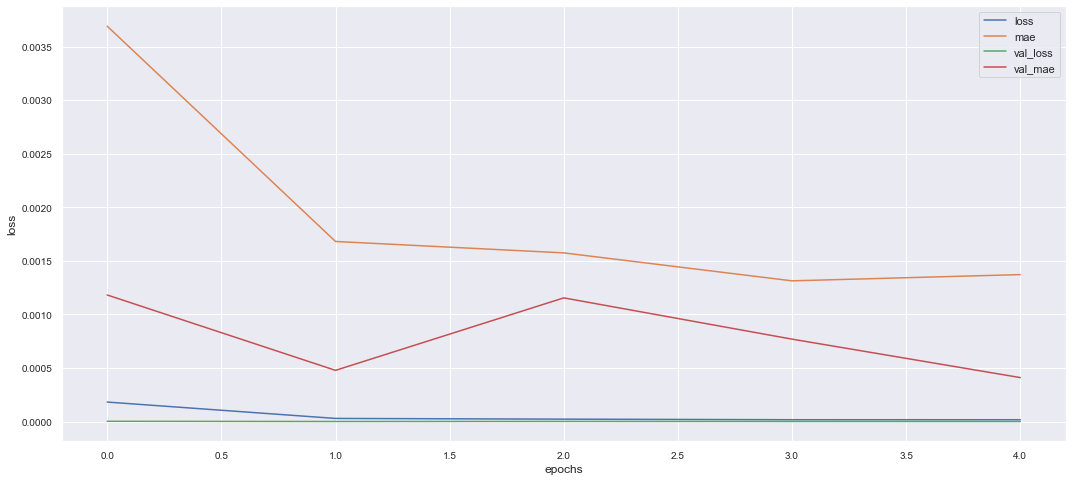

In [444]:
pd.DataFrame(history.history).plot()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid(True)
plt.show()

In [445]:
preds = model.predict(X_test_3D)
preds.shape

(92590, 1)

0.0009599918218666807


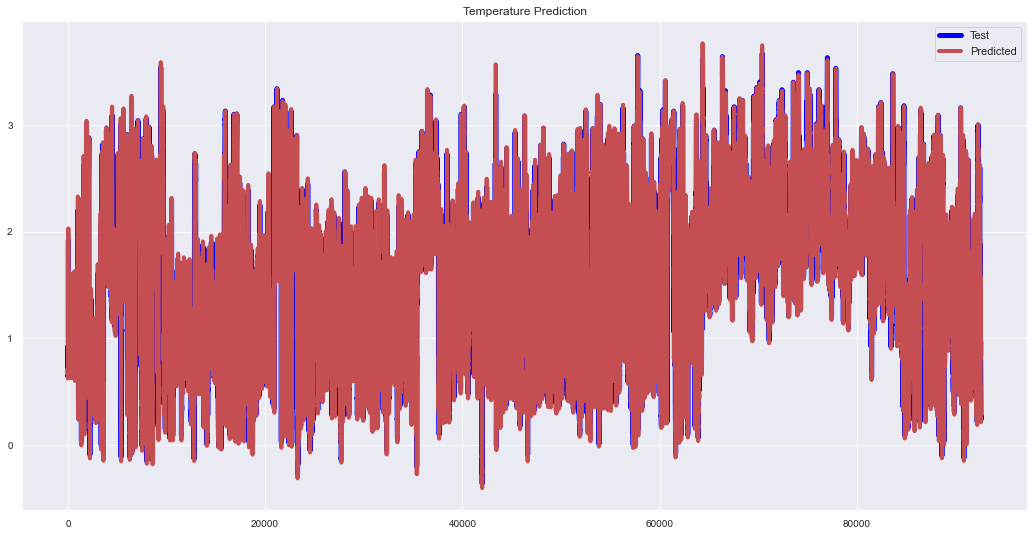

In [446]:
preds = scaler.inverse_transform(preds)

Ytest=np.asanyarray(y_test)  
Ytest=Ytest.reshape(-1,1) 
Ytest = scaler.inverse_transform(y_test)

Ytrain=np.asanyarray(y_train)  
Ytrain=Ytrain.reshape(-1,1) 
Ytrain = scaler.inverse_transform(y_train)

print(mean_squared_error(Ytest,preds))

plt.figure(figsize=(18,9))
plt.plot(Ytest , 'blue', linewidth=5)
plt.plot(preds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Temperature Prediction")
plt.show()

In [101]:
#### Prediction
## Store forecast
forecast = [] 
## How many days should be predicted
periods = 10 
## How many previous days should be used
length=20
first_eval_batch = data_scaled[-steps_back:]
## Shaping starting data
current_batch = first_eval_batch.reshape((1, steps_back, 1))
for i in range(periods):
    ## Get prediction value
    current_pred = model.predict(current_batch)[0] 
    ## Store prediction value
    forecast.append(current_pred) 
    ## Update the batch and drop the first value to keep the set length
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [102]:
## Reverse the MinMax scaling on the forecast
forecast = scaler.inverse_transform(forecast)

In [103]:
## Create a date range from the last available datapoint
last_timestamp = (df_copy.tail(1).index + timedelta(minutes=5)).strftime("%d/%m/%Y, %H:%M:%S")[0]
forecast_index = pd.date_range(start=last_timestamp,periods=periods,freq='5T')

In [104]:
## Combine the prediction values and date range into a dataframe
forecast_df = pd.DataFrame(data=forecast,
                           index=forecast_index,
                           columns=['Forecast']) 

forecast_df['Forecast']= forecast_df['Forecast'].astype(float)
forecast_df

Forecast
2021-11-18 16:45:00  0.271764
2021-11-18 16:50:00  0.270618
2021-11-18 16:55:00  0.262654
2021-11-18 17:00:00  0.248019
2021-11-18 17:05:00  0.227422
2021-11-18 17:10:00  0.202263
2021-11-18 17:15:00  0.173882
2021-11-18 17:20:00  0.143361
2021-11-18 17:25:00  0.111529
2021-11-18 17:30:00  0.078990

In [105]:
## Reverse the MinMax scaling on the original dataframe
df_copy["Temp"] = scaler.inverse_transform(df_copy)

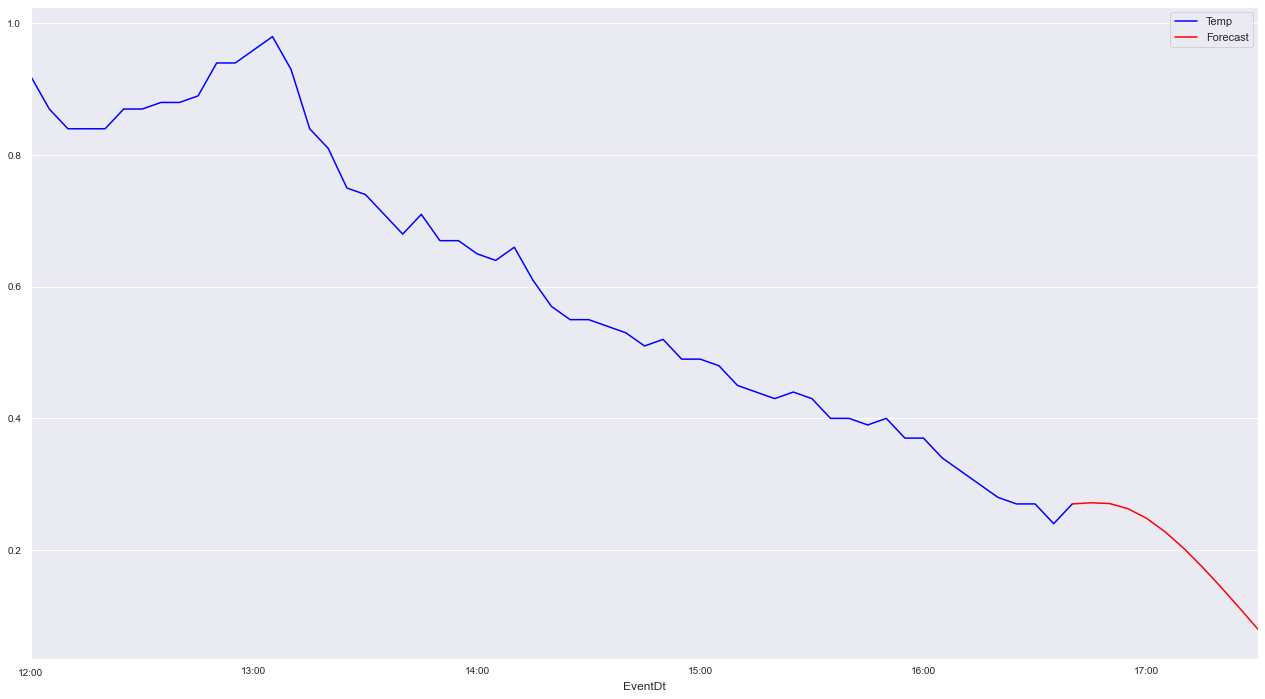

In [106]:
## Add the last available datapoint to the start of the prediction to connect the graph
end_data = (df_copy.tail(1).index).strftime("%d/%m/%Y, %H:%M:%S")[0]
end_pred = (forecast_df.tail(1).index).strftime("%d/%m/%Y, %H:%M:%S")[0]

ix = pd.date_range(start=end_data, end=end_pred, freq='5T')
forecast_df = forecast_df.reindex(ix)

forecast_df.at[end_data,"Forecast"] = df_copy[-1:]["Temp"].astype(float)

## Plot the data
ax = df_copy.loc["2021-11-18 12:00:00":].plot(figsize=(22,12), color='blue')
forecast_df.plot(ax=ax, color='red');

## Device D predictions

### GRU

In [447]:
df_copy = df_d_rmv

scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(df_copy)

df_copy_scaled = df_copy
df_copy_scaled["Temp"] = scaler.transform(df_copy)
df_copy_scaled

Temp
EventDt                      
2018-11-18 16:15:00 -0.285205
2018-11-18 16:20:00 -0.296791
2018-11-18 16:25:00 -0.310160
2018-11-18 16:30:00 -0.315508
2018-11-18 16:35:00 -0.213904
...                       ...
2021-11-18 15:50:00  0.282531
2021-11-18 15:55:00  0.277184
2021-11-18 16:00:00  0.290553
2021-11-18 16:05:00  0.286988
2021-11-18 16:10:00  0.294118

[312795 rows x 1 columns]

In [448]:
previousDays = 20
## Which day we predict (1=Next Day)
afterDays = 1

X = createDelayedColumns(df_copy_scaled, times=range(-previousDays+1,1)).iloc[previousDays:-afterDays]
y = createDelayedColumns(df_copy_scaled, times=[afterDays]).iloc[previousDays:-afterDays]
print(X.shape, y.shape)

(312774, 20) (312774, 1)


In [449]:
## Creating train and test datasets
train_slice = slice(None, "2020-12-28")
test_slice = slice("2021-01-01", None)
X_train, y_train = X.loc[train_slice], y.loc[train_slice]
X_test, y_test = X.loc[test_slice], y.loc[test_slice]

In [450]:
## Converting our Training dataset into 3D dataset
## (Values, LookBack, Features)
X_train_3D = prepareData(X_train)
X_test_3D = prepareData(X_test)

steps_back = len(X_train_3D[1])
print(X_train_3D.shape, X_test_3D.shape)

(221693, 20, 1) (90217, 20, 1)


In [451]:
## Creating our GRU model
model = keras.models.Sequential()
model.add(keras.layers.GRU(50, return_sequences=True, input_shape=(steps_back,1)))
model.add(keras.layers.GRU(25))
model.add(keras.layers.Dense(1))

model.compile(loss="mse", optimizer="adam", metrics=["mae"])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_18 (GRU)                (None, 20, 50)            7950      
                                                                 
 gru_19 (GRU)                (None, 25)                5775      
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 13,751
Trainable params: 13,751
Non-trainable params: 0
_________________________________________________________________


In [452]:
# ## Training our Model
# history = model.fit(X_train_3D, y_train, epochs=5, 
#                                         batch_size=128, validation_split=0.1)

# model.save('./models/Device D/')

## Loading our model
model = keras.models.load_model('./models/Device D/')

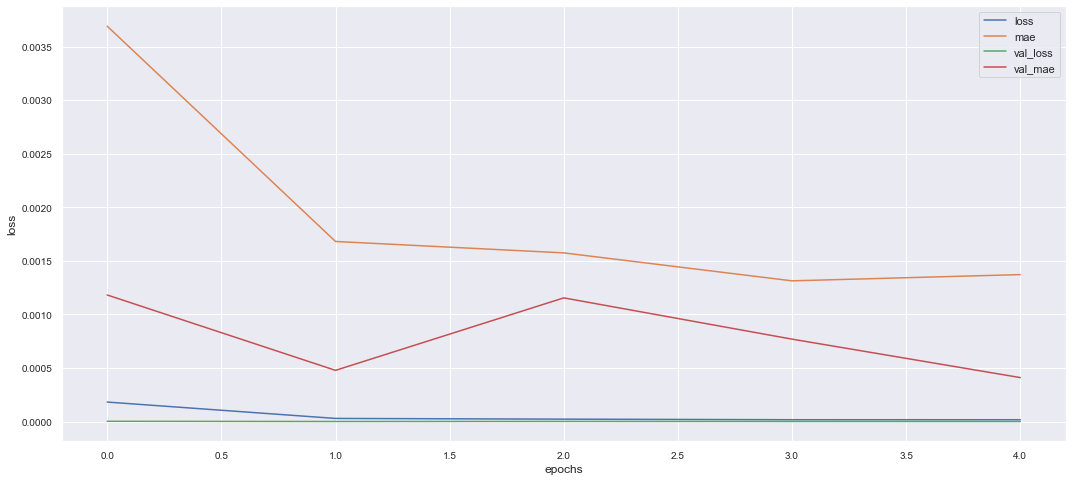

In [453]:
pd.DataFrame(history.history).plot()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid(True)
plt.show()

In [454]:
preds = model.predict(X_test_3D)
preds.shape

(90217, 1)

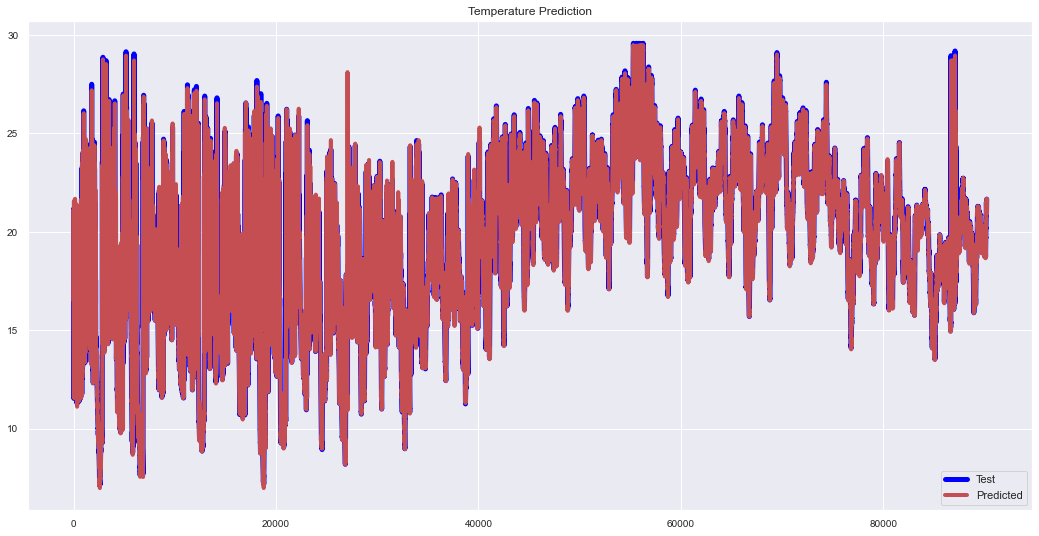

In [455]:
preds = scaler.inverse_transform(preds)

Ytest=np.asanyarray(y_test)  
Ytest=Ytest.reshape(-1,1) 
Ytest = scaler.inverse_transform(y_test)

Ytrain=np.asanyarray(y_train)  
Ytrain=Ytrain.reshape(-1,1) 
Ytrain = scaler.inverse_transform(y_train)

mean_squared_error(Ytest,preds)

plt.figure(figsize=(18,9))
plt.plot(Ytest , 'blue', linewidth=5)
plt.plot(preds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Temperature Prediction")
plt.show()

In [116]:
#### Prediction
## Store forecast
forecast = [] 
## How many days should be predicted
periods = 10 
## How many previous days should be used
length=20
first_eval_batch = data_scaled[-steps_back:]
## Shaping starting data
current_batch = first_eval_batch.reshape((1, steps_back, 1))
for i in range(periods):
    ## Get prediction value
    current_pred = model.predict(current_batch)[0] 
    ## Store prediction value
    forecast.append(current_pred) 
    ## Update the batch and drop the first value to keep the set length
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [117]:
## Reverse the MinMax scaling on the forecast
forecast = scaler.inverse_transform(forecast)

In [118]:
## Create a date range from the last available datapoint
last_timestamp = (df_copy.tail(1).index + timedelta(minutes=5)).strftime("%d/%m/%Y, %H:%M:%S")[0]
forecast_index = pd.date_range(start=last_timestamp,periods=periods,freq='5T')

In [119]:
## Combine the prediction values and date range into a dataframe
forecast_df = pd.DataFrame(data=forecast,
                           index=forecast_index,
                           columns=['Forecast']) 

forecast_df['Forecast']= forecast_df['Forecast'].astype(float)
forecast_df

Forecast
2021-11-18 16:15:00  21.672761
2021-11-18 16:20:00  21.594811
2021-11-18 16:25:00  21.451830
2021-11-18 16:30:00  21.269608
2021-11-18 16:35:00  21.070282
2021-11-18 16:40:00  20.870534
2021-11-18 16:45:00  20.681236
2021-11-18 16:50:00  20.508183
2021-11-18 16:55:00  20.353304
2021-11-18 17:00:00  20.215815

In [120]:
## Reverse the MinMax scaling on the original dataframe
df_copy["Temp"] = scaler.inverse_transform(df_copy)

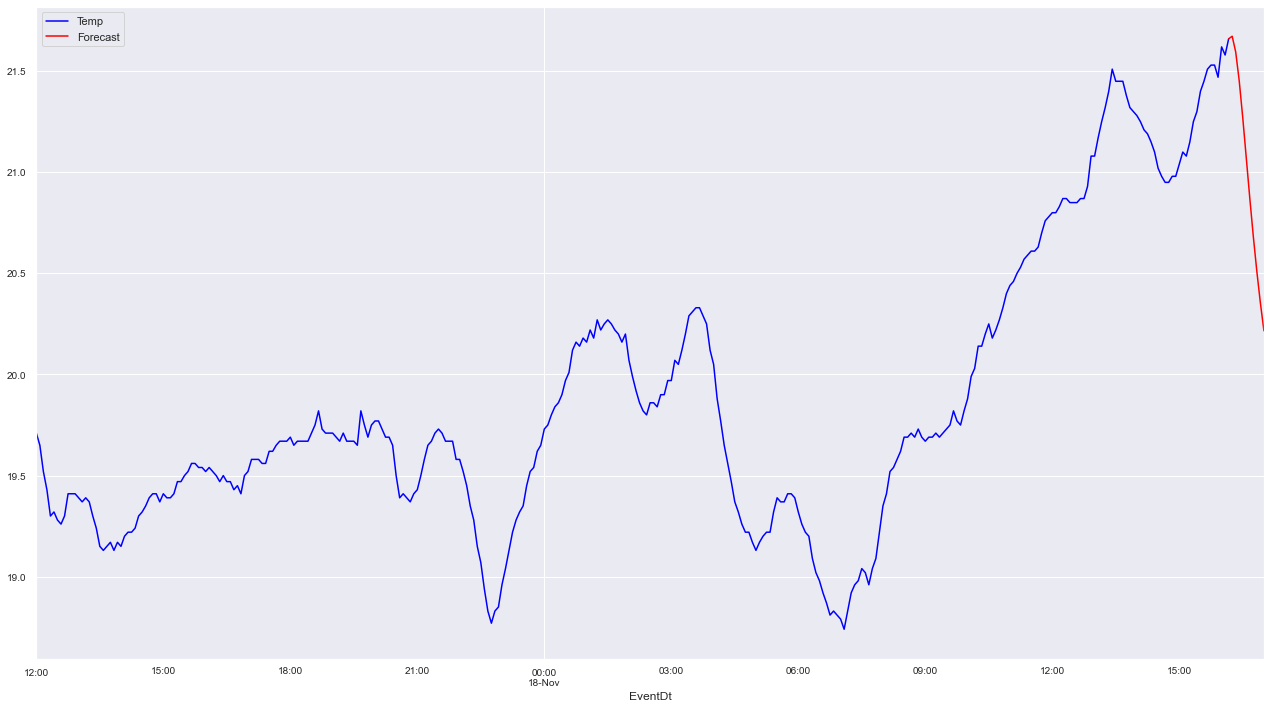

In [121]:
## Add the last available datapoint to the start of the prediction to connect the graph
end_data = (df_copy.tail(1).index).strftime("%d/%m/%Y, %H:%M:%S")[0]
end_pred = (forecast_df.tail(1).index).strftime("%d/%m/%Y, %H:%M:%S")[0]

ix = pd.date_range(start=end_data, end=end_pred, freq='5T')
forecast_df = forecast_df.reindex(ix)

forecast_df.at[end_data,"Forecast"] = df_copy[-1:]["Temp"].astype(float)

## Plot the data
ax = df_copy.loc["2021-11-17 12:00:00":].plot(figsize=(22,12), color='blue')
forecast_df.plot(ax=ax, color='red');